In [54]:
import glob
import scipy.stats as stats
from scipy.optimize import curve_fit
import datetime
from datetime import timezone, timedelta
from dateutil.parser import parse

import numpy as np
import os
import pathlib

import pandas as pd

import xarray as xr

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
#plt.rc('mathtext', fontset="cm")
%matplotlib inline
import seaborn as sns

from pyproj import Transformer
from shapely.geometry import Polygon
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, r2_score, pairwise_distances
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import OPTICS, cluster_optics_dbscan
from st_dbscan import ST_DBSCAN
import time
import geopandas as gpd

## Data preparation

In [55]:
path_crowd = 'C:/Users/Jérôme/Documents/PhD/Crowdsourced data/data/'
file_crowd = 'crowd_complete_2015-05-12_2023-10-15.csv'
file_sensor = 'sensor_complete_2018-07-09_2023-09-07.csv'
crowd_data = pd.read_csv(path_crowd + file_crowd).drop(columns=['Unnamed: 0'])
convert_dict = {'ID':str, 'x':int, 'y':int, 'size':int, 'CustomTime':str,
                'CustomLocation':str, 'OsVersion':str, 'AppVersion':str}
crowd_data = crowd_data.astype(convert_dict)
sensor_data = pd.read_csv(path_crowd + file_sensor).drop(columns=['Unnamed: 0'])

OUTPUT_FOLDER = 'C:/Users/Jérôme/Documents/PhD/Crowdsourced data/analysis/plots/'

C:\Users\Jérôme\AppData\Local\Temp\ipykernel_7864\1403564680.py:4: DtypeWarning: Columns (10,11,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  crowd_data = pd.read_csv(path_crowd + file_crowd).drop(columns=['Unnamed: 0'])


### Functions for preparing crowdsourced hail report

In [56]:
def enrich_crowd_data(cr_data):
    crowd_data = cr_data.copy()
    
    crowd_data['Time'] = pd.to_datetime(crowd_data['Time'], format='%Y-%m-%d %H:%M:%S')
    crowd_data['months'] = crowd_data['Time'].dt.to_period('M')
    crowd_data['years'] = crowd_data['Time'].dt.to_period('Y')
    crowd_data['month_name'] = crowd_data['Time'].dt.month_name()
    crowd_data['month_number'] = crowd_data['Time'].dt.month
    crowd_data['hour'] = crowd_data['Time'].dt.hour
    crowd_data['Time_only'] = crowd_data['Time'].dt.time
    
    cond_season = [crowd_data['month_number'].isin([12,1,2]), crowd_data['month_number'].isin([3,4,5]),
                   crowd_data['month_number'].isin([6,7,8]), crowd_data['month_number'].isin([9,10,11])]
    val_season = ['DJF', 'MAM', 'JJA', 'SON']
    crowd_data['season_name'] = np.select(cond_season, val_season)

    conditions2 = [
        (crowd_data['size'] == 10) | (crowd_data['size'] == 0),
        (crowd_data['size'] == 11) | (crowd_data['size'] == 1),
        (crowd_data['size'] == 12),
        (crowd_data['size'] == 2) | (crowd_data['size'] == 13),
        (crowd_data['size'] == 3) | (crowd_data['size'] == 14),
        (crowd_data['size'] == 15),
        (crowd_data['size'] == 16) | (crowd_data['size'] == 4)]

    # create a list of the values we want to assign for each condition
    values = ['No hail', 'smallest size', '5-8mm', '23mm', '32mm', '43mm', 'largest size']
    values2 = ['No hail', '< 10 [mm]', '10 [mm]', '20 [mm]', '30 [mm]', '50 [mm]', '>70 [mm]']
    values3 = [0, 5, 10, 20, 30, 50, 70]

    crowd_data['size_mixed'] = np.select(conditions2, values)
    crowd_data['size_mixed_new'] = np.select(conditions2, values2)
    crowd_data['size_mixed_num'] = np.select(conditions2, values3)

    inProj = 'epsg:21781' # CH1903 / LV03, see https://epsg.io/21781
    outProj = 'epsg:4326' # WGS84, see https://epsg.io/4326
    transformer = Transformer.from_crs(inProj, outProj)

    coords_crowd = transformer.transform(crowd_data['x'],crowd_data['y'])
    
    crowd_data['x_10km'] = round(crowd_data['x'] / 10000) * 10000
    crowd_data['y_10km'] = round(crowd_data['y'] / 10000) * 10000
    
    crowd_data['x_pix_center'] = round((crowd_data['x']-500) / 1000) * 1000 + 500
    crowd_data['y_pix_center'] = round((crowd_data['y']-500) / 1000) * 1000 + 500

    coords_crowd_500 = transformer.transform(crowd_data['xr'],crowd_data['yr'])
    coords_crowd_1000 = transformer.transform(crowd_data['x_1000m'],crowd_data['y_1000m'])
    coords_crowd_2000 = transformer.transform(crowd_data['x_2000m'],crowd_data['y_2000m'])
    coords_crowd_10km = transformer.transform(crowd_data['x_10km'],crowd_data['y_10km'])

    crowd_data['Lat'] = coords_crowd[0].tolist()
    crowd_data['Lon'] = coords_crowd[1].tolist()

    crowd_data['Lat_500m'] = coords_crowd_500[0].tolist()
    crowd_data['Lon_500m'] = coords_crowd_500[1].tolist()

    crowd_data['Lat_1000m'] = coords_crowd_1000[0].tolist()
    crowd_data['Lon_1000m'] = coords_crowd_1000[1].tolist()

    crowd_data['Lat_2000m'] = coords_crowd_2000[0].tolist()
    crowd_data['Lon_2000m'] = coords_crowd_2000[1].tolist()
    
    crowd_data['Lat_10km'] = coords_crowd_10km[0].tolist()
    crowd_data['Lon_10km'] = coords_crowd_10km[1].tolist()


    temp = crowd_data.groupby(['ID'])
    crowd_data = crowd_data.set_index(['ID'])
    crowd_data['user_reports'] = temp.size()
    crowd_data = crowd_data.reset_index()
    
    crowd_data['Flag_CZC'] = 0
    crowd_data.loc[crowd_data['maxCZC_t15_r4']<=35, 'Flag_CZC'] = 1
    
    crowd_data['Flag_BZC_D'] = 0
    crowd_data.loc[crowd_data['maxBZC_t10_r2']<=0, 'Flag_BZC_D'] = 1
    
    crowd_data['Flag_BZC_C'] = 0
    crowd_data.loc[crowd_data['maxBZC_t15_r4']<=0, 'Flag_BZC_C'] = 1
    
    crowd_data['Flag_BZC_B'] = 0
    crowd_data.loc[crowd_data['maxBZC_t5_r2']<=0, 'Flag_BZC_B'] = 1
    
    crowd_data['Flag_BZC_A'] = 0
    crowd_data.loc[crowd_data['maxBZC_ts_r0']<=0, 'Flag_BZC_A'] = 1
    
    crowd_data['Flag_MZC_B'] = 0
    crowd_data.loc[crowd_data['maxMZC_t5_r2']<=0, 'Flag_MZC_B'] = 1
    
    crowd_data['Flag_MZC_A'] = 0
    crowd_data.loc[crowd_data['maxMZC_ts_r0']<=0, 'Flag_MZC_A'] = 1
    
    crowd_data['Flag_MZC_C'] = 0
    crowd_data.loc[crowd_data['maxMZC_t15_r4']<=0, 'Flag_MZC_C'] = 1
    
    fields = crowd_data.columns.values.tolist()
    EZC = sorted([s for s in fields if 'EZC' in s])
    for l in EZC:
        crowd_data[l] = crowd_data[l]*1000
    
    crowd_data['EZC45-H0'] = crowd_data['maxEZC45_t15_r4'] - crowd_data['maxHZT_t15_r4']
    crowd_data['Flag_EZCH0'] = 0
    crowd_data.loc[crowd_data['EZC45-H0']<0, 'Flag_EZCH0'] = 1
    
    crowd_data = crowd_data.sort_values(by=['Time'])
    crowd_data = crowd_data.drop_duplicates(subset=['ID', 'xr', 'yr', 'Timer', 'size'])
    crowd_data['max_size'] = crowd_data.groupby(['x_pix_center', 'y_pix_center', 'Timer'])['size_range_all_num'].transform('max')
    
    crowd_data = crowd_data.loc[(crowd_data['Flag_30min']==0) & (crowd_data['Flag_blacklist']==0) & (crowd_data['Flag_N_day_ID_4']==0)]
    
    return crowd_data

In [57]:
cr = enrich_crowd_data(crowd_data)

reports = cr.loc[~((cr['size']==0) | (cr['size']==10))].copy()
reports['size_text'] = reports['size_text'].apply(str)

C:\Users\Jérôme\AppData\Local\Temp\ipykernel_7864\2073106796.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  crowd_data['months'] = crowd_data['Time'].dt.to_period('M')
C:\Users\Jérôme\AppData\Local\Temp\ipykernel_7864\2073106796.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  crowd_data['years'] = crowd_data['Time'].dt.to_period('Y')


### Functions for preparing hail sensor data and hail events

In [58]:
def make_sensors_filtered(reports_data, filter_field, field_value):
    # Filtered data
    sensors_filtered = reports_data[(reports_data['status'] == 0) & (reports_data['diameter'] > 0)
                                    & (reports_data['kin_energy'] > 0) & (reports_data['digits'] > 50)
                                    & (reports_data['calib_factor'] != 0) & (reports_data['calib_factor'].notnull())
                                   & (reports_data[filter_field] >= field_value)]

    # Remove duplicates (same sensor and same Time)
    sensors_filtered = sensors_filtered.drop_duplicates(subset=['sensorName', 'Time'], keep='first')

    temp = sensors_filtered.groupby(['sensorName','days'])
    sensors_filtered = sensors_filtered.set_index(['sensorName', 'days'])
    sensors_filtered['daily_count_by_sensor'] = temp.size()
    sensors_filtered['day_sensor_ID'] = sensors_filtered.groupby(['sensorName','days']).ngroup()
    sensors_filtered = sensors_filtered.reset_index()
    sensors_filtered['Day_D_max'] = sensors_filtered.groupby(['day_sensor_ID'])['diameter'].transform('max')

    sensors_filtered['diameter_est'] = np.power(sensors_filtered['kin_energy']/0.0462285,1/4)*10
    sensors_filtered['vt_est'] = 13.77 * np.power(sensors_filtered['diameter_est']/10,0.5)

    sensors_filtered['m_est'] = 2 * sensors_filtered['kin_energy']/(sensors_filtered['vt_est']**2)

    sensors_filtered['d_H20'] = np.where(sensors_filtered['diameter_est']<22.1,
                                                    np.power(sensors_filtered['kin_energy']/0.0107,1/4.59)*10,
                                                    np.power(sensors_filtered['kin_energy']/0.0243,1/3.55)*10)

    sensors_filtered['m_H20'] = 0.372 * np.power(sensors_filtered['d_H20']/10,2.69)

    sensors_filtered['area_H20'] = 0.62 * np.power(sensors_filtered['d_H20']/10,1.96)
    sensors_filtered['area_est'] = np.pi/4 * np.power(sensors_filtered['diameter_est']/10,2)

    sensors_filtered['vt_H20'] = np.where(sensors_filtered['d_H20']<15.9,
                                                    np.power(7.6*sensors_filtered['d_H20']/10, 0.89),
                                                    np.power(8.4*sensors_filtered['d_H20']/10, 0.67))

    sensors_filtered['KE_H20'] = 0.5 * sensors_filtered['m_H20'] * sensors_filtered['vt_H20']**2

    sensors_filtered['ratio_H20'] = sensors_filtered['d_H20']/sensors_filtered['diameter_est']

    sensors_filtered = sensors_filtered.sort_values(['sensorName', 'Time'], ascending=[True, True])
    sensors_filtered['Time2'] = pd.to_datetime(sensors_filtered['Time'])
    sensors_filtered['Time2'] = sensors_filtered['Time2'].dt.tz_localize(timezone.utc)

    conditions2 = [(sensors_filtered['kin_energy'] <= 0.07),
                   ((sensors_filtered['kin_energy'] > 0.07) & (sensors_filtered['kin_energy'] <= 0.13)),
                   ((sensors_filtered['kin_energy'] > 0.13) & (sensors_filtered['kin_energy'] <= 0.26)),
                   ((sensors_filtered['kin_energy'] > 0.26) & (sensors_filtered['kin_energy'] <= 0.67)),
                   ((sensors_filtered['kin_energy'] > 0.67) & (sensors_filtered['kin_energy'] <= 3.8)),
                  (sensors_filtered['kin_energy'] > 3.8)]

    val2 = [0.064, 0.18, 0.332, 0.5, 0.87, 0.994]
    sensors_filtered['dead_time'] = np.select(conditions2, val2)
    
    sensors_filtered['Flag_BZC_A'] = 0
    sensors_filtered.loc[sensors_filtered['maxBZC_ts_r0']<=0, 'Flag_BZC_A'] = 1
    
    sensors_filtered['Flag_BZC_B'] = 0
    sensors_filtered.loc[sensors_filtered['maxBZC_t5_r2']<=0, 'Flag_BZC_B'] = 1
    
    sensors_filtered['Flag_BZC_D'] = 0
    sensors_filtered.loc[sensors_filtered['maxBZC_t10_r2']<=0, 'Flag_BZC_D'] = 1

    sensors_filtered['Flag_BZC_C'] = 0
    sensors_filtered.loc[sensors_filtered['maxBZC_t15_r4']<=0, 'Flag_BZC_C'] = 1
    
    sensors_filtered['Flag_MZC_A'] = 0
    sensors_filtered.loc[sensors_filtered['maxMZC_ts_r0']<=0, 'Flag_MZC_A'] = 1
    
    sensors_filtered['Flag_MZC_B'] = 0
    sensors_filtered.loc[sensors_filtered['maxMZC_t5_r2']<=0, 'Flag_MZC_B'] = 1

    sensors_filtered['Flag_MZC_C'] = 0
    sensors_filtered.loc[sensors_filtered['maxMZC_t15_r4']<=0, 'Flag_MZC_C'] = 1 

    sensors_filtered['Flag_CZC'] = 0
    sensors_filtered.loc[sensors_filtered['maxCZC_t15_r4']<=35, 'Flag_CZC'] = 1
    
    sensors_filtered['month_number'] = sensors_filtered['Time2'].dt.month
    sensors_filtered['month_name'] = sensors_filtered['Time2'].dt.month_name()
    
    cond_season = [sensors_filtered['month_number'].isin([12,1,2]), sensors_filtered['month_number'].isin([3,4,5]),
                   sensors_filtered['month_number'].isin([6,7,8]), sensors_filtered['month_number'].isin([9,10,11])]
    val_season = ['DJF', 'MAM', 'JJA', 'SON']
    sensors_filtered['season_name'] = np.select(cond_season, val_season)
    
    return sensors_filtered

In [59]:
def make_sensors_data(sensors_data, EVENT_MIN_TIME):
    
    data = sensors_filtered.copy()
    data['Time_diff'] = data['Time2'].diff().dt.total_seconds()
    data['Time_diff_p'] = np.where((data['Time_diff']<0) | (data['Time_diff'].abs()/EVENT_MIN_TIME >=1),1,0)
    data = data.assign(Event_ID=data.Time_diff_p.cumsum())
    data['Event_start'] = data.groupby(['Event_ID'])['Time2'].transform('min')
    data['Event_end'] = data.groupby(['Event_ID'])['Time2'].transform('max')
    data['Event_duration'] = (data['Event_end'] - data['Event_start']).dt.total_seconds()
    data['Time_0'] = (data['Time2'] - data['Event_start']).dt.total_seconds()
    data['Time_rel'] = data['Time_0']/data['Event_duration']
    temp = data.groupby(['Event_ID'])
    data = data.set_index(['Event_ID'])
    data['Event_hits'] = temp.size()
    data['Event_density'] = data['Event_hits']/SENSOR_SURFACE
    data = data.reset_index()
    data.drop(['Time_diff_p'], axis=1, inplace=True)
    data['Event_tot_dead_time'] = data.groupby(['Event_ID'])['dead_time'].transform('sum')

    data['Event_hit_rate'] = np.where(data['Event_duration']>0,
                                                        data['Event_hits']/data['Event_duration'],
                                                        0)

    data['Event_hit_rate_adj2'] = np.where(data['Event_duration']>0,
                                                        data['Event_hits']/(data['Event_duration'] - data['Event_tot_dead_time']),
                                                        0)
    data['Event_hits_adj2'] = np.where(data['Event_duration']>0,(data['Event_hit_rate_adj2'] * data['Event_duration']).round(0).astype(int),
                                                    1)
    data['Event_hits_diff2'] = data['Event_hits_adj2'] - data['Event_hits']

    data['dt'] = data['Time_diff'].abs()
    data['dt_next'] = data['Time2'].diff(periods=-1).dt.total_seconds().abs()
    data['dt'] = data['dt'].where(data['dt']<=EVENT_MIN_TIME, other=np.NaN)
    data['dt_next'] = data['dt_next'].where(data['dt']<=EVENT_MIN_TIME, other=np.NaN)
    data['Event_dt_avg'] = data.groupby(['Event_ID'])['dt'].transform(lambda x: x.mean(skipna=True))
    data['Event_dt_min'] = data.groupby(['Event_ID'])['dt'].transform(lambda x: x.min(skipna=True))
    data['Event_inst_hit_rate'] = 1/data['dt']
    data['Event_inst_hit_rate_max'] = data.groupby(['Event_ID'])['Event_inst_hit_rate'].transform(lambda x: x.max(skipna=True))
    data['Event_inst_hit_rate_avg'] = data.groupby(['Event_ID'])['Event_inst_hit_rate'].transform(lambda x: x.mean(skipna=True))
    data['Event_inst_hit_rate_std'] = data.groupby(['Event_ID'])['Event_inst_hit_rate'].transform(lambda x: x.std(skipna=True))
    data['dt'].fillna(0, inplace=True)
    data['dt_next'].fillna(0, inplace=True)
    data['Event_inst_hit_rate'].fillna(0, inplace=True)

    data['Occurrences'] = 1
    roll_calc = data.groupby('Event_ID').rolling('10s', on='Time2', center=True)['Occurrences'].sum()
    roll_calc2 = data.groupby('Event_ID').rolling('30s', on='Time2', center=True)['Occurrences'].sum()
    data = data.set_index(["Event_ID", "Time2"])
    data["10s_hit_rate"] = roll_calc
    data["30s_hit_rate"] = roll_calc2
    data=data.reset_index()
    data['Event_10s_hit_rate_max'] = data.groupby(['Event_ID'])['10s_hit_rate'].transform('max')
    data['Event_30s_hit_rate_max'] = data.groupby(['Event_ID'])['30s_hit_rate'].transform('max')
    data['Event_10s_hit_rate_avg'] = data.groupby(['Event_ID'])['10s_hit_rate'].transform('mean')
    data['Event_30s_hit_rate_avg'] = data.groupby(['Event_ID'])['30s_hit_rate'].transform('mean')
    data['Event_10s_hit_rate_std'] = data.groupby(['Event_ID'])['10s_hit_rate'].transform('std')
    data['Event_30s_hit_rate_std'] = data.groupby(['Event_ID'])['30s_hit_rate'].transform('std')
    
    conditions = [(data['Event_hits'] == 1),
                   ((data['Event_hits'] > 1) & (data['Event_hits'] <= 5)),
                   ((data['Event_hits'] > 5) & (data['Event_hits'] <= 25)),
                  (data['Event_hits'] > 25)]

    val = ['1 impact', '2-5 impacts', '6-25 impacts', '> 25 impacts']
    data['Event_hits_group'] = np.select(conditions, val)

    
    data['Event_KEdensity_tot'] = data.groupby(['Event_ID'])['kin_energy'].transform('sum')/SENSOR_SURFACE
    data['Event_KEFlux_tot'] = data['Event_KEdensity_tot']/data['Event_duration']
    data['Event_KE_max'] = data.groupby(['Event_ID'])['kin_energy'].transform('max')
    data['Event_D_max'] = data.groupby(['Event_ID'])['diameter'].transform('max')
    data['Event_D_mean'] = data.groupby(['Event_ID'])['diameter'].transform('mean')
    data['Event_D_max_vicinity'] = (data['Event_D_max'] - 5.06)/0.493
    
    data['Event_count'] = data.groupby(['Event_hits'])['Event_ID'].transform('nunique')
    data['meanCZC_t5_r2_ev'] = data.groupby(['Event_ID'])['maxCZC_t5_r2'].transform('mean')
    data['meanCZC_ts_r0_ev'] = data.groupby(['Event_ID'])['maxCZC_ts_r0'].transform('mean')
    data['meanBZC_t5_r2_ev'] = data.groupby(['Event_ID'])['maxBZC_t5_r2'].transform('mean')
    data['meanBZC_t15_r4_ev'] = data.groupby(['Event_ID'])['maxBZC_t15_r4'].transform('mean')
    data['meanBZC_ts_r0_ev'] = data.groupby(['Event_ID'])['maxBZC_ts_r0'].transform('mean')
    data['meanBZC_t10_r2_ev'] = data.groupby(['Event_ID'])['maxBZC_t15_r4'].transform('mean')
    
    data['meanMZC_t5_r2_ev'] = data.groupby(['Event_ID'])['maxMZC_t5_r2'].transform('mean')
    data['meanMZC_t15_r4_ev'] = data.groupby(['Event_ID'])['maxMZC_t15_r4'].transform('mean')
    data['meanMZC_ts_r0_ev'] = data.groupby(['Event_ID'])['maxMZC_ts_r0'].transform('mean')
    data['meanMZC_t10_r2_ev'] = data.groupby(['Event_ID'])['maxMZC_t10_r2'].transform('mean')
    
    data['Event_Flag_MZC_A'] = data.groupby(['Event_ID'])['Flag_MZC_A'].transform('mean')
    data['Event_Flag_MZC_B'] = data.groupby(['Event_ID'])['Flag_MZC_B'].transform('mean')
    data['Event_Flag_MZC_C'] = data.groupby(['Event_ID'])['Flag_MZC_C'].transform('mean')
    
    data['Event_Flag_BZC_A'] = data.groupby(['Event_ID'])['Flag_BZC_A'].transform('mean')
    data['Event_Flag_BZC_B'] = data.groupby(['Event_ID'])['Flag_BZC_B'].transform('mean')
    data['Event_Flag_BZC_C'] = data.groupby(['Event_ID'])['Flag_BZC_C'].transform('mean')
    data['Event_Flag_BZC_D'] = data.groupby(['Event_ID'])['Flag_BZC_D'].transform('mean')
    
    data['Event_Flag_CZC'] = data.groupby(['Event_ID'])['Flag_CZC'].transform('mean')

    return data

In [60]:
def make_hail_events_full(data):
    
    hail_events = data.groupby('Event_ID')['Event_hits','Event_hits_group','Event_count','Event_hits_adj2','Event_duration','Event_D_max','Event_D_mean','daily_count_by_sensor',
                                           'Event_dt_min', 'Event_dt_avg','Event_tot_dead_time','Event_inst_hit_rate_avg','Event_10s_hit_rate_avg','Event_30s_hit_rate_avg',
                                           'Event_inst_hit_rate_std','Event_10s_hit_rate_std','Event_30s_hit_rate_std',
                                           'Event_hit_rate','Event_inst_hit_rate_max','Event_10s_hit_rate_max','Event_30s_hit_rate_max',
                                           'Event_hit_rate_adj2', 'Event_hits_diff2',
                                           'Event_density','Event_start','Event_end',
                                           'sensorName','installDate','days',
                                           'meanCZC_t5_r2_ev','meanCZC_ts_r0_ev', 'meanBZC_t5_r2_ev', 'meanBZC_ts_r0_ev', 'meanBZC_t15_r4_ev', 'meanBZC_t10_r2_ev',
                                           'meanMZC_t5_r2_ev', 'meanMZC_ts_r0_ev', 'meanMZC_t15_r4_ev', 'meanMZC_t10_r2_ev',
                                           'Event_Flag_BZC_A', 'Event_Flag_BZC_B', 'Event_Flag_BZC_C', 'Event_Flag_CZC', 'Event_Flag_BZC_D',
                                           'Event_Flag_MZC_A', 'Event_Flag_MZC_B', 'Event_Flag_MZC_C',
                                           'Event_KEdensity_tot','Event_KEFlux_tot',
                                           'Event_KE_max','Event_D_max_vicinity','region','season_name', 'month_name', 'month_number'].agg('min')

    idx = data.groupby(['Event_ID'])['diameter'].transform(max) == data['diameter']
    max_d = data.loc[idx,['Event_ID','Time_0']].set_index('Event_ID')
    max_d2 = max_d.groupby('Event_ID').agg('min')
    max_d_ = data.loc[idx,['Event_ID','Time_rel']].set_index('Event_ID')
    max_d_2 = max_d_.groupby('Event_ID').agg('min')
    df3 = pd.merge(hail_events, max_d2, how="inner", on = 'Event_ID')
    hail_events_full = pd.merge(df3, max_d_2, how="inner", on = 'Event_ID')
    
    return hail_events_full

def make_sensors_sel(data, data2, HIT_TH, HIT_TH_UP):
    hail_events_sel = data.loc[(data['Event_hits'] >= HIT_TH) & (data['Event_hits'] <= HIT_TH_UP)]
    sensors_ev_sel = data2.loc[(data2['Event_hits'] >= HIT_TH) & (data2['Event_hits'] <= HIT_TH_UP)]
    
    return hail_events_sel, sensors_ev_sel

### Functions to compute contingency tables and skill scores

In [61]:
def make_contingency2(data, display=True):
    
    A = data['A'].sum()
    B = data['B'].sum()
    C = data['C'].sum()
    D = data['D'].sum()
    
    n = A+B+C+D
    n_obs = A+C
    n_forecast = A+B
    base_rate = n_obs/n
    
    if n_obs > 0:
        H = A/n_obs
        Bias = n_forecast/n_obs
    else:
        H = 0
        Bias = 0
    
    if (n_obs + B) > 0:
        CSI = A/(n_obs+B)
    else:
        CSI = 0
        
    F = B/(B+D)
    
    if n_forecast > 0:
        fcast_rate = n_obs/n_forecast
        FAR = B/n_forecast
    else:
        FAR = 0
        fcast_rate = 0
        
    PC = (A+D)/n
    PSS = H - F
    
    if base_rate > 0:
        HSS = (2*base_rate*(1-base_rate)*(H-F))/(base_rate + base_rate*(1-2*base_rate)*H + (1-base_rate)*(1-2*base_rate)*F)
    else:
        HSS = 0
    
    if display:
        print(contingency)
        print('H: %f' % H)
        print('F: %f' % F)
        print('FAR: %f' % FAR)
        print('CSI: %F' % CSI)
        print('Bias: %F' % Bias)
        print('Proportion Correct: %F' % PC)
        print('Pierce Skill Score: %F' % PSS)
    return A, B, C, D, n, H, F, FAR, CSI, Bias, PC, PSS, n_obs, base_rate, fcast_rate, HSS

In [62]:
def make_contingency3(data):
    
    A = data['A'].sum()
    B = data['B'].sum()
    C = data['C'].sum()
    
    n_obs = A+C
    n_forecast = A+B
    
    if n_obs > 0:
        H = A/n_obs
        Bias = n_forecast/n_obs
    else:
        H = 0
        Bias = 0
    
    if (n_obs + B) > 0:
        CSI = A/(n_obs+B)
    else:
        CSI = 0
    
    if n_forecast > 0:
        fcast_rate = n_obs/n_forecast
        FAR = B/n_forecast
    else:
        FAR = 0
        fcast_rate = 0
    
    return A, B, C, H, FAR, CSI, Bias

## Figures

### Figure 1

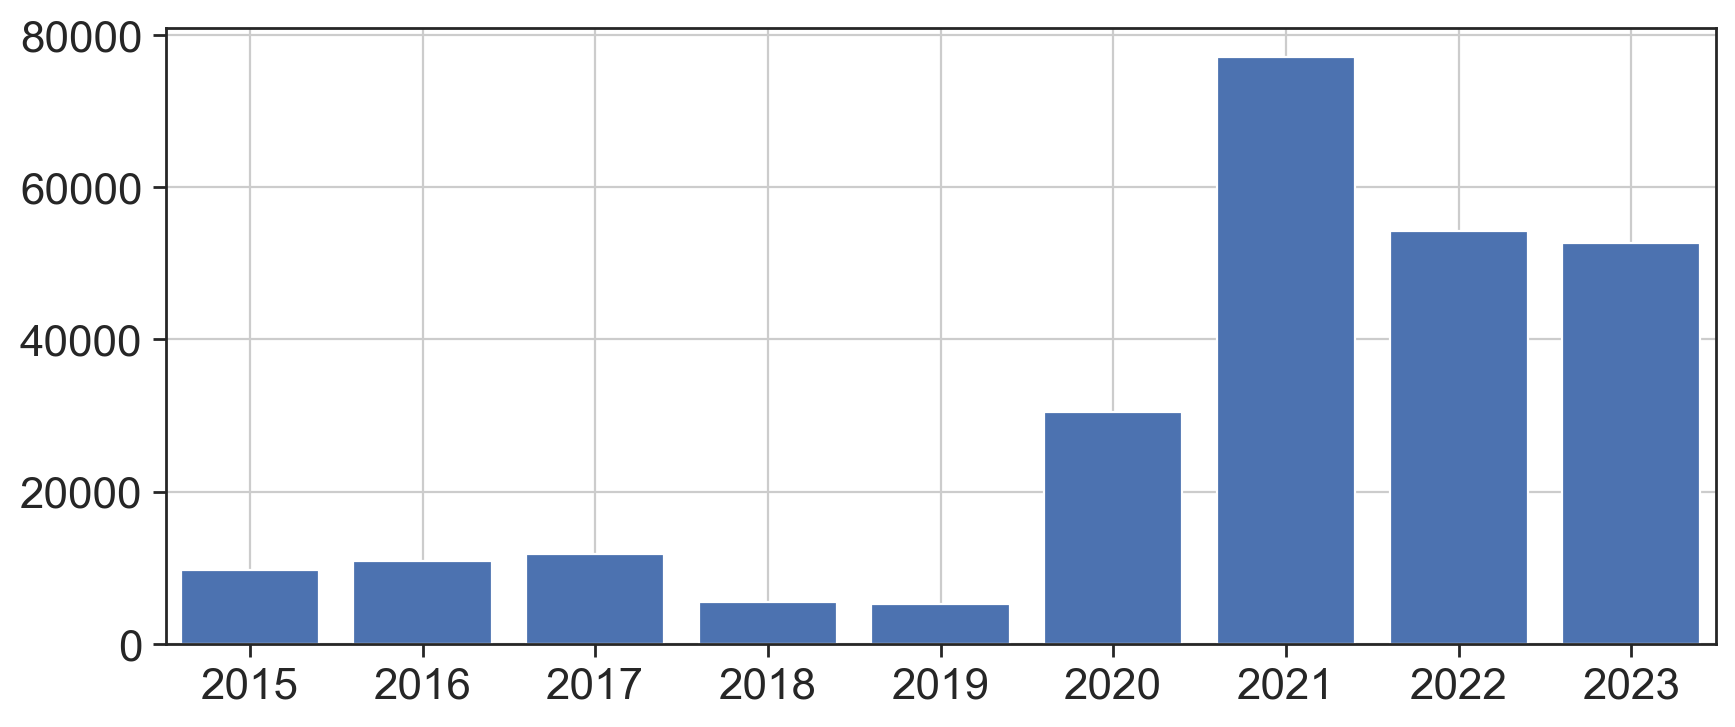

In [63]:
sns.set(style='ticks', context='paper', font_scale=1.8)
nmeas_valid = []

startdate = '2015'
enddate = '2024'
months = pd.date_range(startdate,enddate,freq='Y').strftime('%Y')

for i,s in enumerate(months):
    nmeas_valid.append(len(reports[reports['years'] == s]))
                         
plt.figure(figsize = (10,4), dpi = 200)
ax = plt.subplot()
plt.bar(range(len(months)),nmeas_valid)
#plt.title('Number of crowdsourced reports per year')
plt.xticks(range(len(months)), months)
min_loc = 1
max_loc = 1
ax.xaxis.set_major_locator(MultipleLocator(max_loc))
ax.xaxis.set_minor_locator(MultipleLocator(min_loc))
plt.margins(x=0.01, tight=True)
plt.grid()
plt.savefig('plots/crowdsourced_barplot_years.png',bbox_inches = 'tight',dpi=200)

### Figure 2

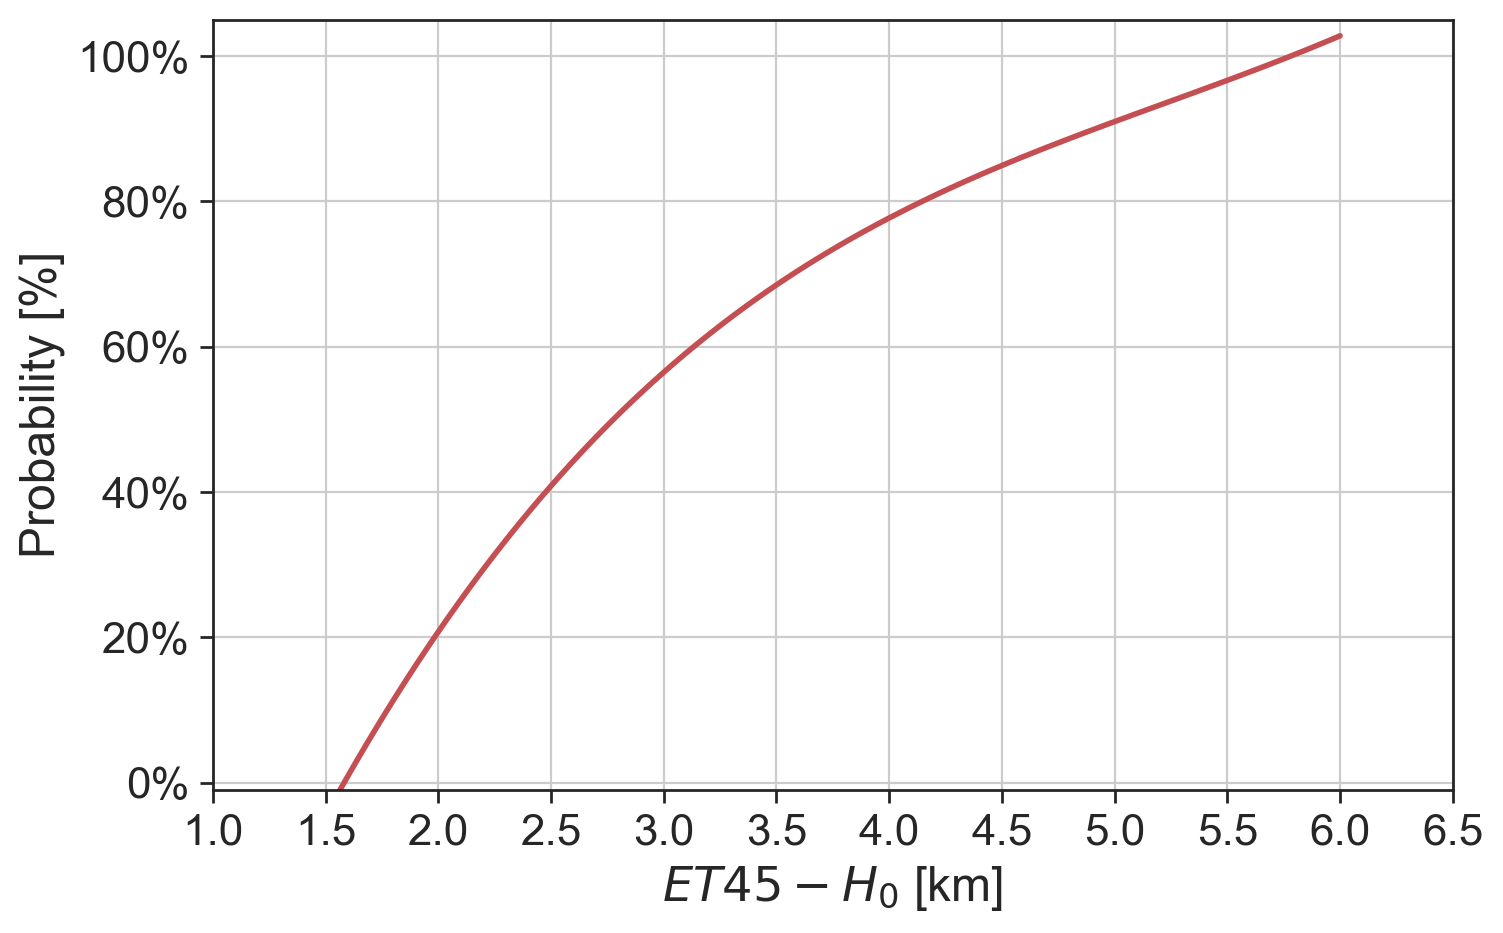

In [64]:
import matplotlib.ticker as mtick
sns.set(style='ticks', context='paper', font_scale=1.8)
plt.figure(figsize = (8,5), dpi = 200)
ax1 = plt.subplot()
lower_limit = 1.5
upper_limit = 6
num_pts = 100
x = np.linspace(lower_limit, upper_limit, num_pts)
y = np.polyval([0.01086,-0.17018,1.00184,-1.20231], x)
plt.grid()
ax1.plot(x, y, '-r',lw=2)
x_poh = [1.59,1.8,1.97,2.17,2.4,2.7,3.07,3.55,4.2,5,5.8,6.5]
y_poh = np.arange(0,1.1,0.1)
y_poh = np.append(y_poh, y_poh[-1])
#ax2 = ax1.twinx()
#ax1.step(x_poh, y_poh, where='post',lw=2)
plt.xlim(1,6.5)
plt.ylim(-0.01,1.05)
plt.xticks(np.arange(1, 6.6, step=0.5))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('$ET45-H_0$ [km]')
plt.ylabel('Probability [%]')
plt.margins(x=0.01, tight=True)

plt.savefig('plots/POH_fit.png',bbox_inches = 'tight',dpi=200)

### Figure 3

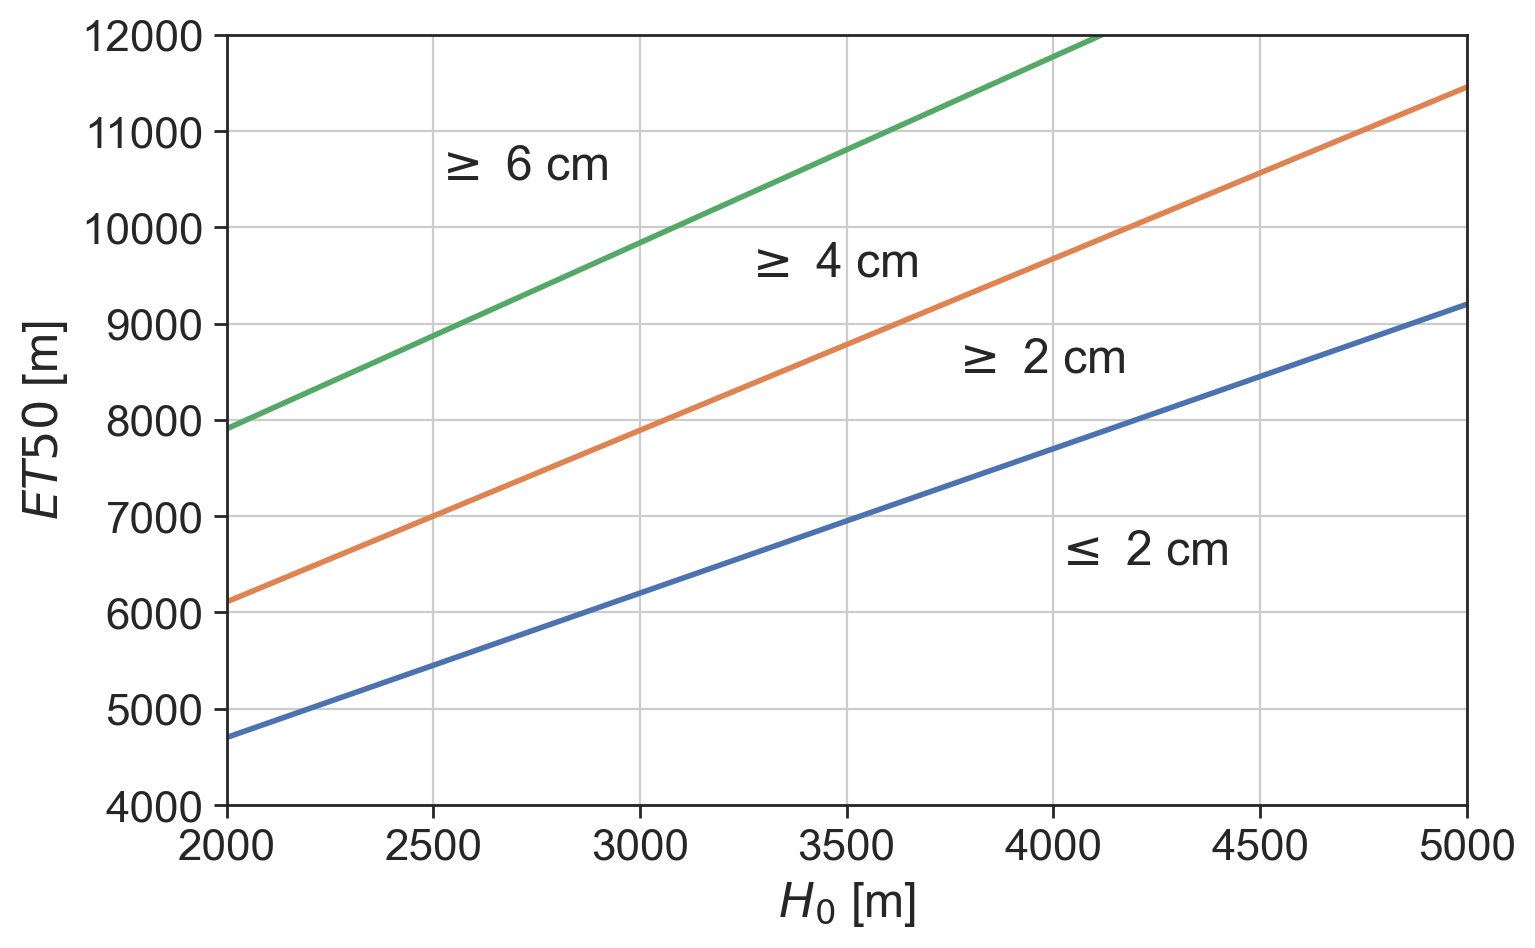

In [65]:
import matplotlib.ticker as mtick
sns.set(style='ticks', context='paper', font_scale=1.8)
plt.figure(figsize = (8,5), dpi = 200)
ax1 = plt.subplot()
lower_limit = 1500
upper_limit = 6000
num_pts = 100
x = np.linspace(lower_limit, upper_limit, num_pts)
y_2cm = np.polyval([1.5,1700], x)
y_4cm = np.polyval([1.7824,2544.1], x)
y_6cm = np.polyval([1.9333,4040], x)
plt.grid()
ax1.plot(x, y_2cm,lw=2)
ax1.plot(x, y_4cm,lw=2)
ax1.plot(x, y_6cm,lw=2)

plt.xlim(2000,5000)
plt.ylim(4000,12000)
plt.xticks(np.arange(2000, 5500, step=500))
plt.yticks(np.arange(4000, 13000, step=1000))
plt.xlabel('$H_0$ [m]')
plt.ylabel('$ET50$ [m]')

plt.text(2500, 10500, '$\geq$ 6 cm')
plt.text(3250, 9500, '$\geq$ 4 cm')
plt.text(3750, 8500, '$\geq$ 2 cm')
plt.text(4000, 6500, '$\leq$ 2 cm')
plt.margins(x=0.01, tight=True)

plt.savefig('plots/MESHS_fit.png',bbox_inches = 'tight',dpi=200)

# POH recalibration

### Prepare data

In [66]:
# Function for making 3rd order polynomal fit
def make_poly(data, area, method, dist,x, deg=3):
    p = data.loc[(data['dist'] == dist) &
                 (data['method'] == method) &
                 (data['area'] == area)].copy()
    p = p.sort_values(by=['ET45-H0_km'], ascending=True)
    c_p = np.polynomial.polynomial.Polynomial.fit(p['ET45-H0_km'], p['prob'], deg).convert().coef
    return p, np.polyval([c_p[3],c_p[2],c_p[1],c_p[0]], x)

In [67]:
ar_list = ['all100d33_2','ZRH_2']

buckets_POH = []
result = pd.read_pickle('radar_verif_newPOH_all_ET45-H0.pkl') #radar_verif_newPOH_ext_ET45-H0.pkl
temp = make_rad_stats(result)
for ar in ar_list:
    for method in temp['method'].unique().tolist():
        a = temp.loc[(temp['day']>'2020-08-01') & (temp['season_name']=='JJA') &
                     (temp['method']==method) & (temp['region']==ar)].sort_values(by=['day'], ascending=True)
        dist_list = a['dist'].unique().tolist()

        for d in dist_list:
            
            th_list = np.arange(-3000,12000,250)
           
            field_list = ['ET45-H0_' + str(a) for a in th_list]
            t = a.loc[a['dist'] == d].copy()
            t['A_tot'] = t.groupby(['field'])['A'].transform('sum')
            t['B_tot'] = t.groupby(['field'])['B'].transform('sum')
            
            for p,f in zip(th_list,field_list):
                A = t.loc[t['field'] == f,'A_tot'].iloc[0]
                B = t.loc[t['field'] == f,'B_tot'].iloc[0]
                buckets_POH.append({'area': ar, 'method': method, 'dist': d, 'ET45-H0': p, 'A': A, 'B': B})

buckets = pd.DataFrame.from_dict(buckets_POH)

In [68]:
dx = 500
th_list = np.arange(-3000,12000,dx)
buckets_list = []
for ar in ar_list:
    for method in buckets['method'].unique().tolist():
        for d in buckets['dist'].unique().tolist():
            temp = buckets.loc[(buckets['method']==method) & (buckets['area']==ar) & (buckets['dist']==d)]
            for f in th_list:
                A = temp.loc[(temp['ET45-H0'] >= f) & (temp['ET45-H0'] < f+dx),'A'].sum()
                B = temp.loc[(temp['ET45-H0'] >= f) & (temp['ET45-H0'] < f+dx),'B'].sum()
                buckets_list.append({'area': ar, 'method': method, 'dist': d, 'ET45-H0': f, 'A': A, 'B': B})

buckets_df = pd.DataFrame.from_dict(buckets_list)
buckets_df['prob'] = np.where((buckets_df['A'] + buckets_df['B'])==0, 1, buckets_df['A']/(buckets_df['A'] + buckets_df['B']))
buckets_df['count'] = buckets_df['A'] + buckets_df['B']
buckets_df['ET45-H0_km'] = buckets_df['ET45-H0']/1000
buckets_df.loc[buckets_df['dist'] == 'pix', 'dist'] = 0
buckets_df['freq'] = buckets_df.groupby(['area','method','dist'])['count'].transform(lambda x: x/x.sum())

### Figure 14

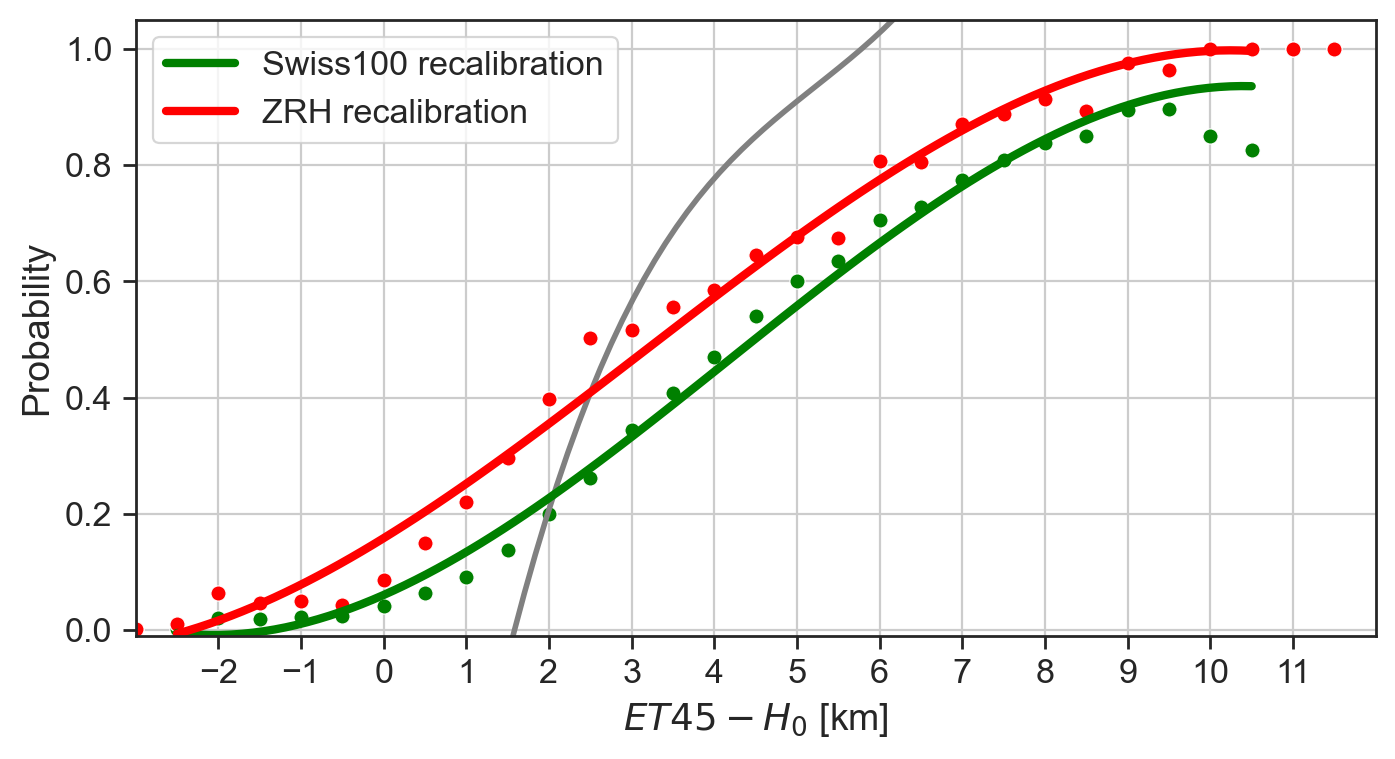

In [70]:
import matplotlib.ticker as mtick

sns.set(style='ticks', context='paper', font_scale=1.4)
plt.figure(figsize = (8,4), dpi = 200)
ax1 = plt.subplot()
lower_limit = -3000
upper_limit = 10500
num_pts = 100
x = np.linspace(lower_limit, upper_limit, num_pts)

lower_limit = -2.5
upper_limit = 10.5
num_pts = 100
x_km = np.linspace(lower_limit, upper_limit, num_pts)
plt.grid()

coeff_POH = [0.01086,-0.17018,1.00184,-1.20231]
y3 = np.polyval(coeff_POH, x_km)
ax1.plot(x_km, y3,lw=2,c='grey')
y_poh = np.arange(0,1.1,0.1)
y_poh = np.append(y_poh, y_poh[-1])
#ax1.step(x_poh, y_poh, where='post',lw=2,c='grey', label='POH (original)')

dist = 2
method = 'clust_CZC_8km_480s'

p_Swiss100, y_Swiss100 = make_poly(buckets_df, 'all100d33_2', method, dist, x_km, deg=3)
p_ZRH, y_ZRH = make_poly(buckets_df, 'ZRH_2', method, dist, x_km, deg=3)

sns.scatterplot(data = p_Swiss100, x='ET45-H0_km',y='prob', marker='o',s=30, color='green')
ax1.plot(x_km, y_Swiss100,lw=3, color='green', label='Swiss100 recalibration')

sns.scatterplot(data = p_ZRH, x='ET45-H0_km',y='prob', marker='o',s=30, color='red')
ax1.plot(x_km, y_ZRH,lw=3, color='red', label='ZRH recalibration')

plt.ylim(-0.01,1.05)
plt.legend()
plt.xticks(np.arange(-2, 12, step=1))
plt.xlim(-3,12)
plt.xlabel('$ET45-H_0$ [km]')
plt.ylabel('Probability')
plt.margins(x=0.01, tight=True)

plt.savefig('plots/POH_recalibration.png',bbox_inches = 'tight',dpi=200)

### Get polynomial coefficents

In [71]:
dist = 2
method = 'clust_CZC_8km_480s'
area = 'all100d33_2'
p = buckets_df.loc[(buckets_df['dist'] == dist) &
                 (buckets_df['method'] == method) &
                 (buckets_df['area'] == area)].copy()
p = p.sort_values(by=['ET45-H0_km'], ascending=True)
c_p = np.polynomial.polynomial.Polynomial.fit(p['ET45-H0_km'], p['prob'], 3).convert().coef
c_p

array([ 0.06031308,  0.06281255,  0.01222726, -0.00097794])

### Figure 16

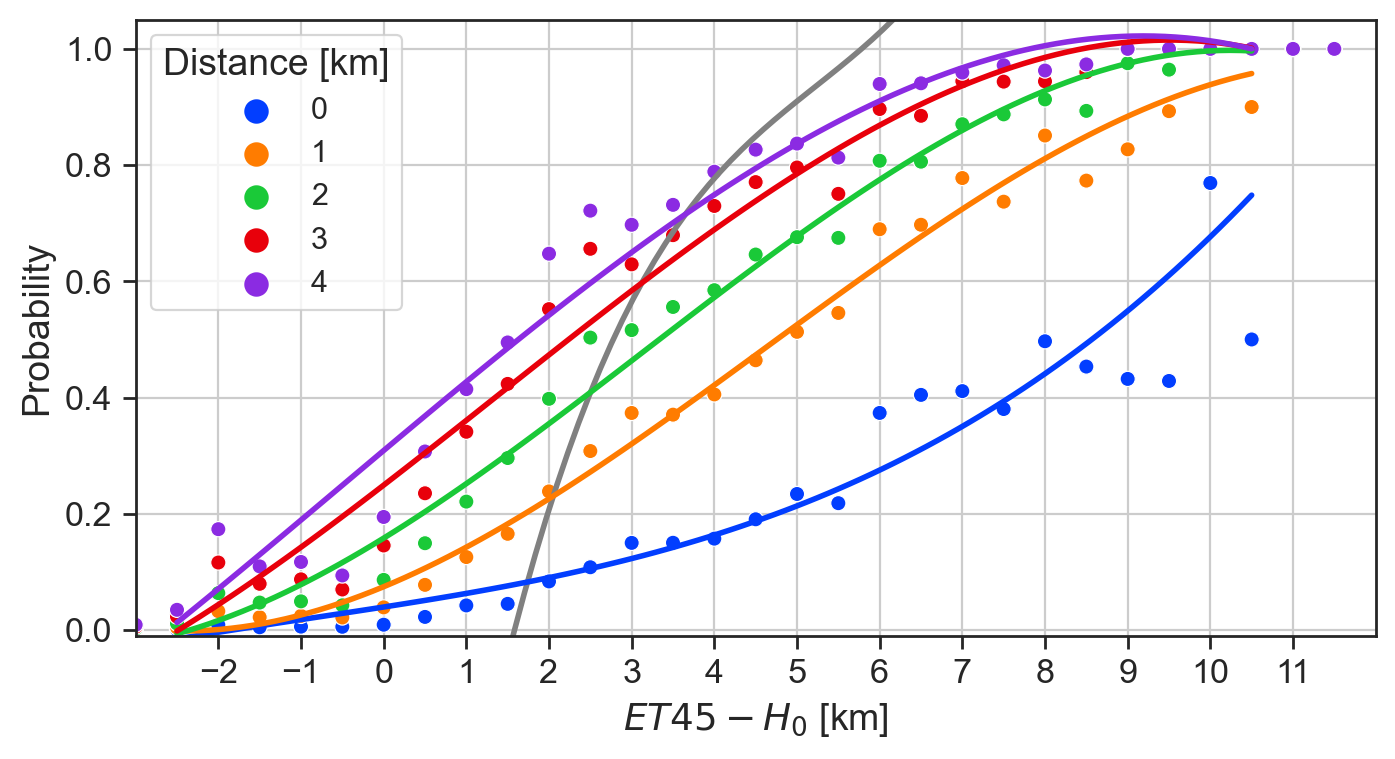

In [72]:
import matplotlib.ticker as mtick

sns.set(style='ticks', context='paper', font_scale=1.4)
plt.figure(figsize = (8,4), dpi = 200)
ax1 = plt.subplot()
lower_limit = -3000
upper_limit = 12000
num_pts = 100
x = np.linspace(lower_limit, upper_limit, num_pts)

lower_limit = -2.5
upper_limit = 10.5
num_pts = 100
x_km = np.linspace(lower_limit, upper_limit, num_pts)
plt.grid()

coeff_POH = [0.01086,-0.17018,1.00184,-1.20231]
y3 = np.polyval(coeff_POH, x_km)
ax1.plot(x_km, y3,lw=2,c='grey')
y_poh = np.arange(0,1.1,0.1)
y_poh = np.append(y_poh, y_poh[-1])
#ax1.step(x_poh, y_poh, where='post',lw=2,c='grey', label='POH (original)')

area = 'ZRH_2'
method = 'clust_CZC_8km_480s'
df = buckets_df.loc[(buckets_df['area'] == area) & (buckets_df['method'] == method)].sort_values(by=['dist'], ascending=True)
columns = ['x_km', 'y']
df_poly = pd.DataFrame(columns=columns)
for j,m in enumerate(df['dist'].unique().tolist()):
    p, y = make_poly(buckets_df, area, method, m, x_km, deg=3)
    df_temp = pd.DataFrame(columns=columns)
    df_temp['x_km'] = x_km
    df_temp['y'] = y
    df_poly = pd.concat([df_poly,df_temp])
    sns.lineplot(x=x_km, y=y,lw=2,color=sns.color_palette("bright")[j])
    
t = sns.scatterplot(data = df, x='ET45-H0_km',y='prob', hue='dist',marker='o',s=30,palette='bright',legend = True)

legend_handles, _= t.get_legend_handles_labels()
labels = ['0','1','2','3','4']
for legobj in legend_handles:
    legobj.set_linewidth(4)
t.legend(legend_handles, labels, title='Distance [km]', prop={'size': 11})

plt.ylim(-0.01,1.05)
plt.xticks(np.arange(-2, 12, step=1))
plt.xlim(-3,12)
plt.xlabel('$ET45-H_0$ [km]')
plt.ylabel('Probability')
plt.margins(x=0.01, tight=True)

plt.savefig('plots/POH_recalibration_dist_%s.png' % (area),bbox_inches = 'tight',dpi=200)

### Figure 15

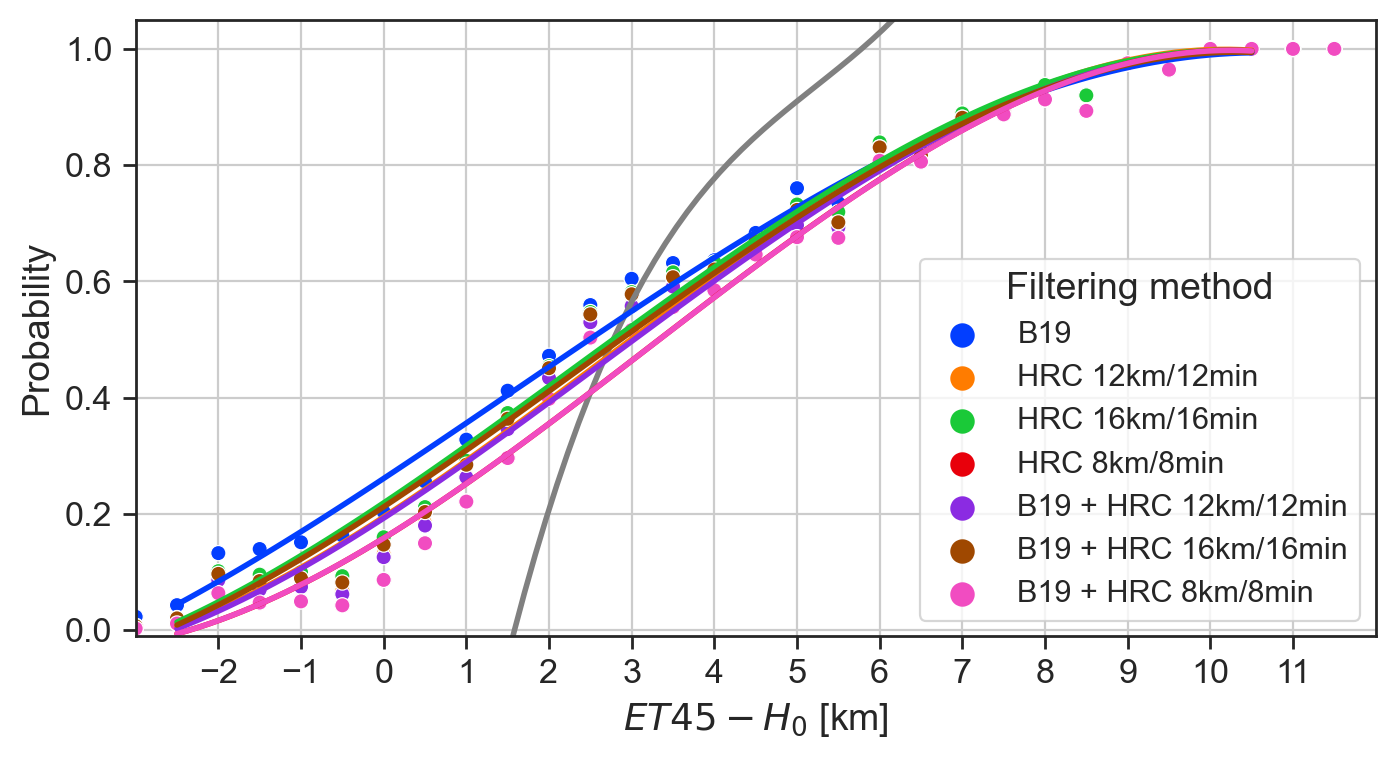

In [73]:
import matplotlib.ticker as mtick

sns.set(style='ticks', context='paper', font_scale=1.4)
plt.figure(figsize = (8,4), dpi = 200)
ax1 = plt.subplot()
lower_limit = -3000
upper_limit = 12000
num_pts = 100
x = np.linspace(lower_limit, upper_limit, num_pts)

lower_limit = -2.5
upper_limit = 10.5
num_pts = 100
x_km = np.linspace(lower_limit, upper_limit, num_pts)
plt.grid()

coeff_POH = [0.01086,-0.17018,1.00184,-1.20231]
y3 = np.polyval(coeff_POH, x_km)
ax1.plot(x_km, y3,lw=2,c='grey')
y_poh = np.arange(0,1.1,0.1)
y_poh = np.append(y_poh, y_poh[-1])

area = 'ZRH_2'
dist = 2
df = buckets_df.loc[(buckets_df['area'] == area) & (buckets_df['dist'] == dist)].sort_values(by=['method'], ascending=True)
columns = ['x_km', 'y']
df_poly = pd.DataFrame(columns=columns)
for j,m in enumerate(df['method'].unique().tolist()):
    p, y = make_poly(buckets_df, area, m, dist, x_km, deg=3)
    df_temp = pd.DataFrame(columns=columns)
    df_temp['x_km'] = x_km
    df_temp['y'] = y
    df_poly = pd.concat([df_poly,df_temp])
    sns.lineplot(x=x_km, y=y,lw=2,color=sns.color_palette("bright")[j])
    
t = sns.scatterplot(data = df, x='ET45-H0_km',y='prob', hue='method',marker='o',s=30,palette='bright',legend = True)

legend_handles, _= t.get_legend_handles_labels()
labels = ['B19','HRC 12km/12min','HRC 16km/16min','HRC 8km/8min','B19 + HRC 12km/12min','B19 + HRC 16km/16min','B19 + HRC 8km/8min']
for legobj in legend_handles:
    legobj.set_linewidth(4)
t.legend(legend_handles, labels, title='Filtering method', prop={'size': 11})

plt.ylim(-0.01,1.05)
#plt.legend()
plt.xticks(np.arange(-2, 12, step=1))
plt.xlim(-3,12)
plt.xlabel('$ET45-H_0$ [km]')
plt.ylabel('Probability')
plt.margins(x=0.01, tight=True)

plt.savefig('plots/POH_recalibration_method_%s.png' % (area),bbox_inches = 'tight',dpi=200)

# POH and MESHS Verification

In [74]:
def make_rad_stats(df):
    daily_stats = df.copy()
    daily_stats['day'] = pd.to_datetime(daily_stats['day'], format='%Y-%m-%d')
    daily_stats['months'] = daily_stats['day'].dt.to_period('M')
    daily_stats['years'] = daily_stats['day'].dt.to_period('Y')
    daily_stats['month_name'] = daily_stats['day'].dt.month_name()
    daily_stats['month_number'] = daily_stats['day'].dt.month
    cond_season = [daily_stats['month_number'].isin([12,1,2]), daily_stats['month_number'].isin([3,4,5]),
                       daily_stats['month_number'].isin([6,7,8]), daily_stats['month_number'].isin([9,10,11])]
    val_season = ['DJF', 'MAM', 'JJA', 'SON']
    daily_stats['season_name'] = np.select(cond_season, val_season)
    cond_hail_season = [daily_stats['month_number'].isin([4,5,6,7,8,9]), daily_stats['month_number'].isin([1,2,3,10,11,12])]
    val_hail_season = ['hail season', 'not hail season']
    daily_stats['hail_season_name'] = np.select(cond_hail_season, val_hail_season)
    return daily_stats

### Prepare verification data using the maximum upscaling approach

In [87]:
min_date_list = ['2020-08-01']
skill_scores = []
df = pd.read_pickle('radar_verif_upscale.pkl')
rad_verif = make_rad_stats(df)

ls_dist = rad_verif['dist'].unique().tolist()
ls_region = rad_verif['region'].unique().tolist()
ls_method = rad_verif['method'].unique().tolist()
ls_th_field = rad_verif['field'].unique().tolist()
ls_season = ['JJA']
for region in ls_region:
    for method in ls_method:
        for dist in ls_dist:
            for th_field in ls_th_field:
                for min_date in min_date_list:
                    temp = rad_verif.loc[(rad_verif['dist'] == dist) & (rad_verif['field'] == th_field) &
                                         (rad_verif['day'] > min_date) & (rad_verif['method'] == method) &
                                         (rad_verif['region'] == region)]

                    for season in ls_season:
                        data = temp.loc[temp['season_name'] == season]
                        A, B, C, D, n, H, F, FAR, CSI, Bias, PC, PSS, n_obs, base_rate, fcast_rate, HSS = make_contingency2(temp, False)
                        skill_scores.append({'region': region, 'method': method, 'field': th_field, 'distance': dist, 'min_date': min_date, 'season': 'JJA', 'Bias': Bias, 'PC': PC,
                                         'H': H, 'F': F, 'FAR': FAR, 'CSI': CSI, 'PSS': PSS, 'n': n, 'A': A, 'B': B, 'C': C, 'D': D,
                                     'n obs': n_obs, 'base rate': base_rate, 'fcast rate': fcast_rate, 'HSS': HSS})

st = pd.DataFrame.from_dict(skill_scores)
st.loc[st['distance'] == 'pix', 'distance'] = 0
st['product'] = st['field'].str.split('_').str[0]
st['value'] = st['field'].str.split('_').str[1].astype(int)
st['region_name'] = 'ZRH'
st.loc[st['region'].str.contains('all100d33'), 'region_name'] = 'Swiss100'
st['area'] = '1km x 1km'
st.loc[st['distance'] == 2, 'area'] = '2km x 2km'
st.loc[st['distance'] == 3, 'area'] = '3km x 3km'
st.loc[st['distance'] == 4, 'area'] = '4km x 4km'
st.loc[st['distance'] == 5, 'area'] = '5km x 5km'
st.loc[st['distance'] == 6, 'area'] = '6km x 6km'
st.loc[st['distance'] == 7, 'area'] = '7km x 7km'
st.loc[st['distance'] == 8, 'area'] = '8km x 8km'
st.loc[st['distance'] == 9, 'area'] = '9km x 9km'
st.loc[st['distance'] == 10, 'area'] = '10km x 10km'
st.to_pickle('verifications_final_upscale_allregions.pkl')

### Prepare verification data using the percentage of matches and $FAR_{POH}$

In [17]:
min_date_list = ['2020-08-01']
skill_scores = []
df = pd.read_pickle('radar_verif_H_FAR.pkl')
rad_verif = make_rad_stats(df)

ls_dist = rad_verif['dist'].unique().tolist()
ls_sc = rad_verif['sc'].unique().tolist()
ls_region = rad_verif['region'].unique().tolist()
ls_method = rad_verif['method'].unique().tolist()
ls_th_field = rad_verif['field'].unique().tolist()
ls_season = ['JJA']
for region in ls_region:
    for method in ls_method:
        for dist in ls_dist:
            for th_field in ls_th_field:
                for sc in ls_sc:
                    for min_date in min_date_list:

                        temp = rad_verif.loc[(rad_verif['dist'] == dist) & (rad_verif['field'] == th_field) &
                                         (rad_verif['day'] > min_date) & (rad_verif['method'] == method) &
                                        (rad_verif['region'] == region) & (rad_verif['sc'] == sc)]

                        for season in ls_season:
                            data = temp.loc[temp['season_name'] == season]
                            A, B, C, H, FAR, CSI, Bias = make_contingency3(temp)
                            skill_scores.append({'region': region, 'method': method, 'field': th_field, 'distance': dist,
                                             'min_date': min_date, 'sc': sc, 'season': season, 'Bias': Bias,
                                             'H': H, 'FAR': FAR, 'CSI': CSI, 'A': A, 'B': B, 'C': C})

st = pd.DataFrame.from_dict(skill_scores)
st.loc[st['distance'] == 'pix', 'distance'] = 0
st.to_pickle('verifications_final_allregions.pkl')

In [19]:
st = pd.read_pickle('verifications_final_allregions.pkl')
st['product'] = st['field'].str.split('_').str[0]
st['value'] = st['field'].str.split('_').str[1].astype(int)
st['region_name'] = 'ZRH'
st.loc[st['region'].str.contains('all100d33'), 'region_name'] = 'Swiss100'
st.to_pickle('verifications_final_allregions.pkl')

## Plots for verification using maximum upscaling approach, percentage of matches and $FAR_{POH}$

### Figure 21

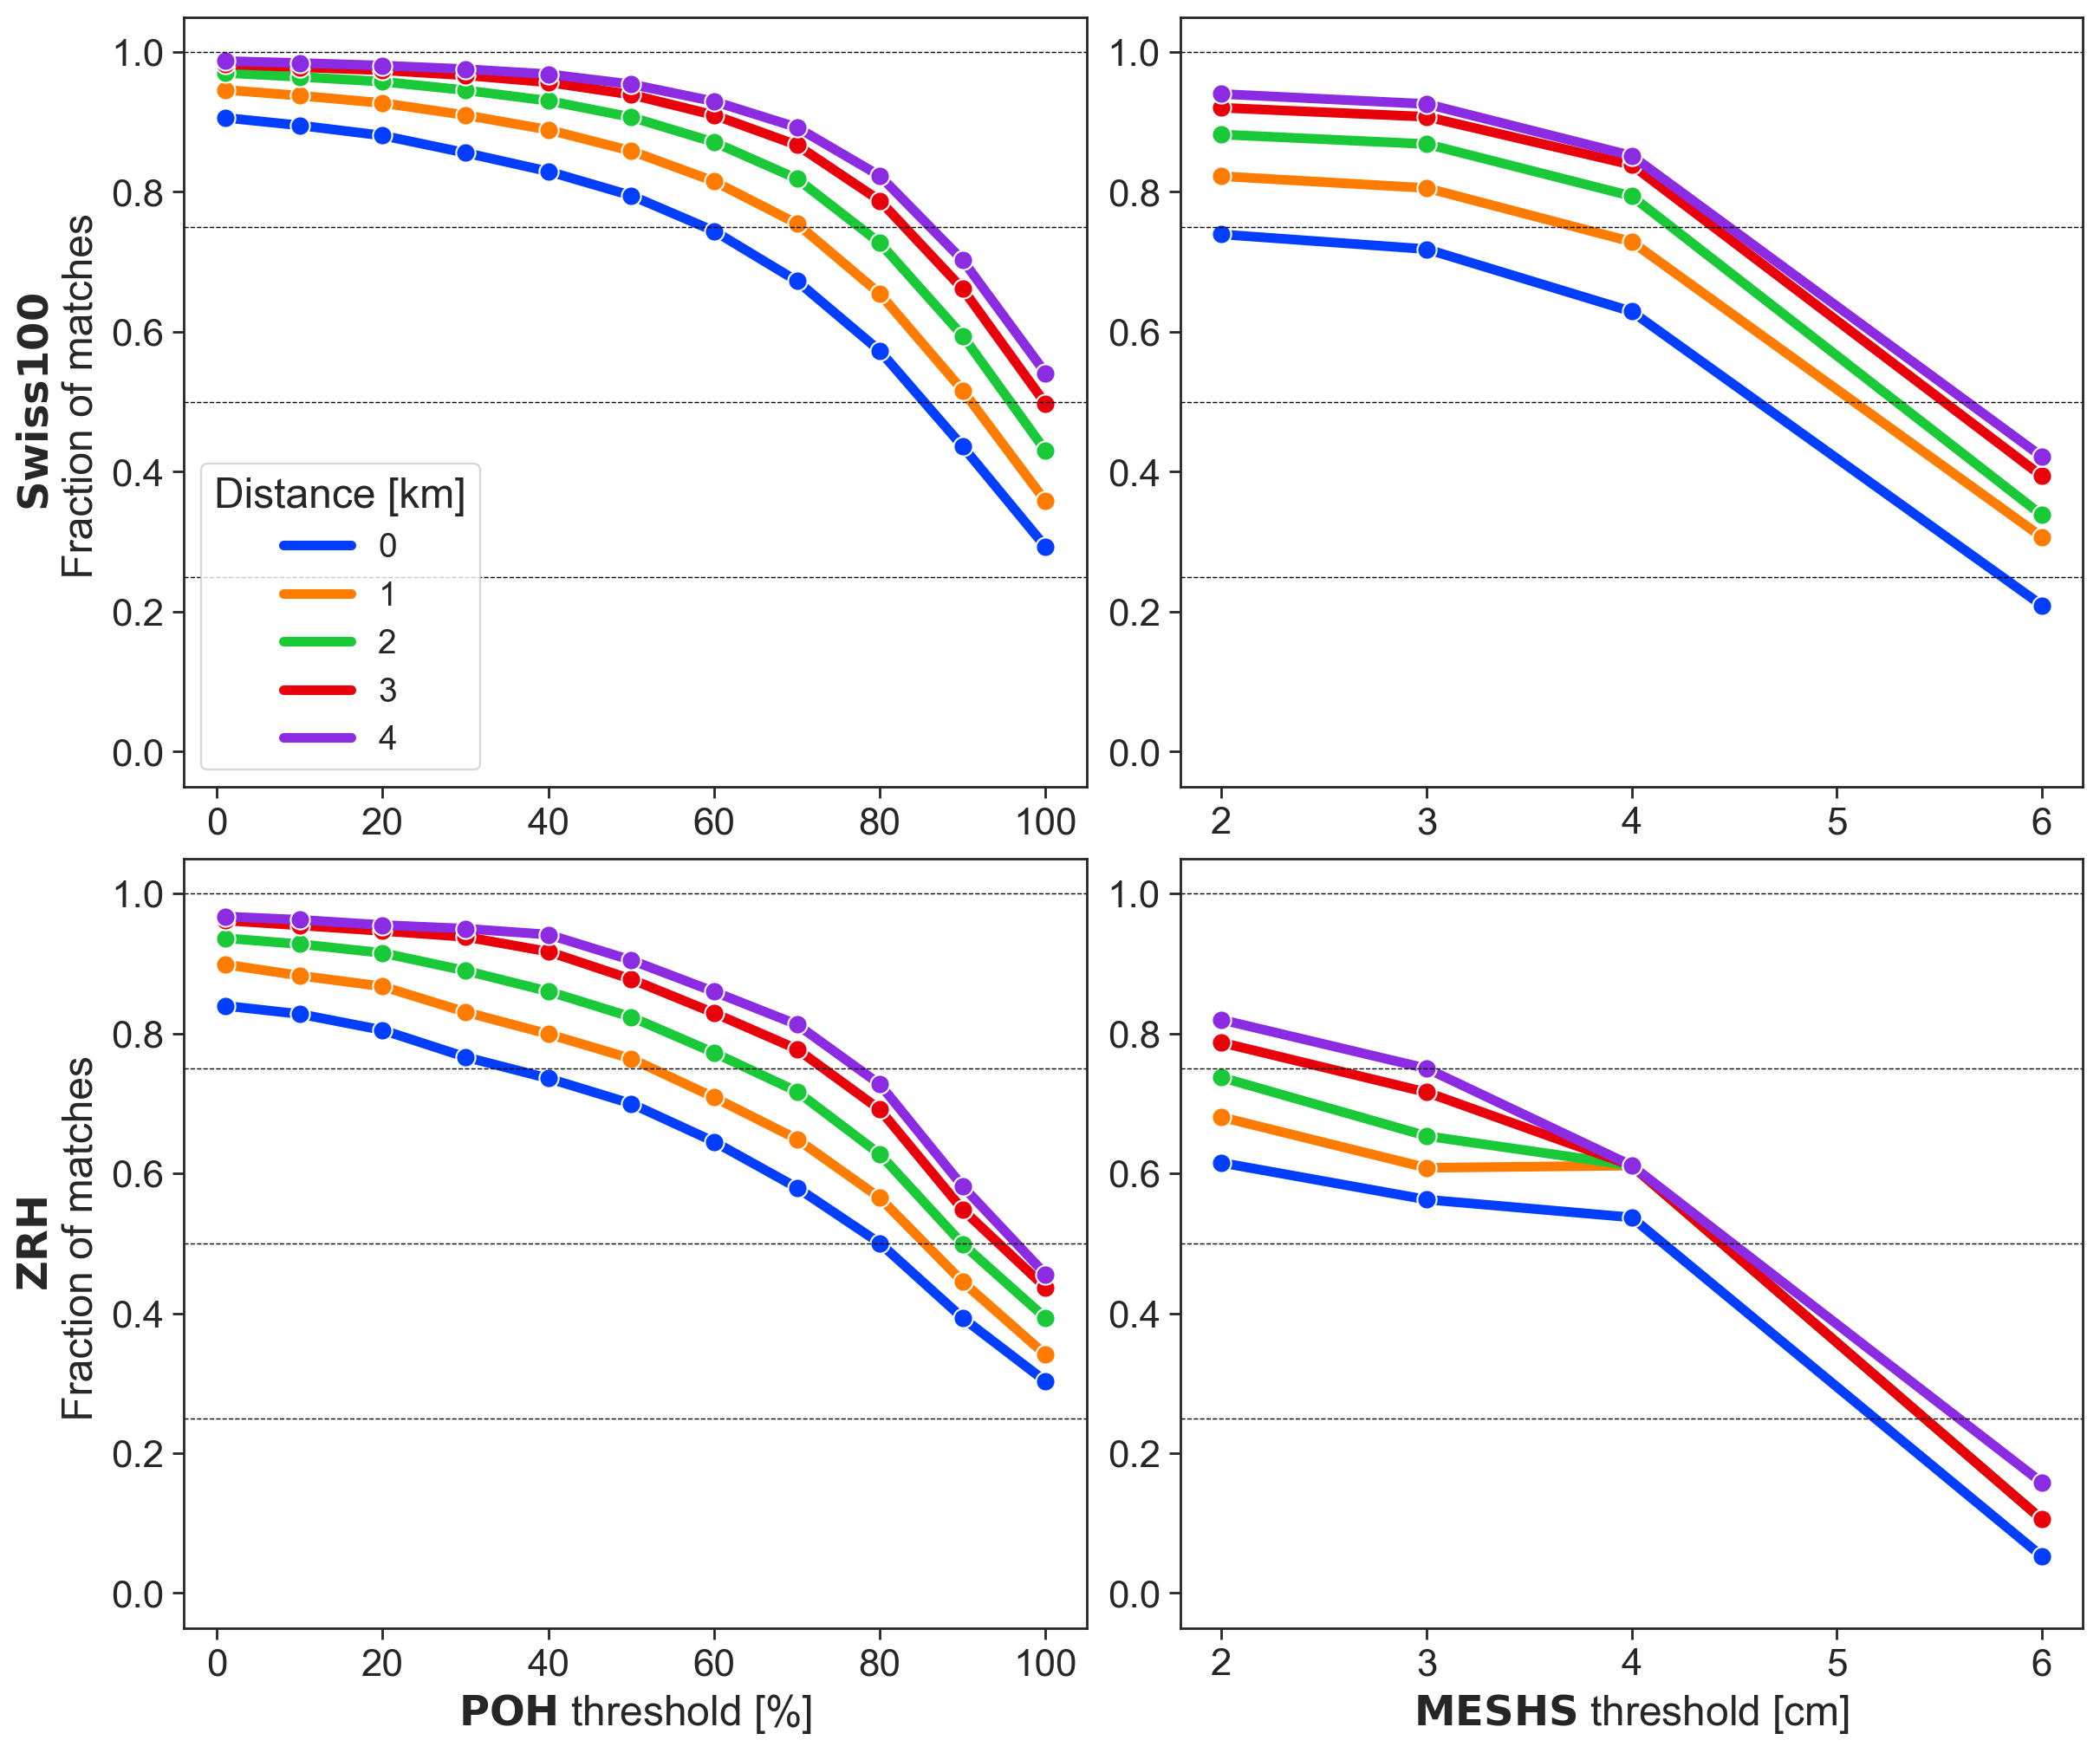

In [36]:
#%%capture
sns.set(style='ticks', context='paper', font_scale=1.8)
seas = 'JJA'
min_date = '2020-08-01'

ncols = 2
nrows = 2

x_val = 'value'
h_val = 'distance'
fix_val = 'clust_CZC_8km_480s'
st = pd.read_pickle('verifications_final_allregions.pkl')

st = st.sort_values(by=['distance',x_val], ascending=True)

dist_list = [0,1,2,3,4]

ls_regions = ['all100d33_2', 'ZRH_2','all100d33_2_large','ZRH_2_large']

st = st.loc[(st['min_date'] == min_date) & (st['season'] == seas) & (st['method'] == fix_val) & (st['distance'].isin(dist_list)) & (st['sc'] == 'H')]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained',figsize = (12,10),dpi=200)

for j,region in enumerate(ls_regions):
    data = st.loc[(st['region'] == region)]

    if j==0:
        t = sns.lineplot(data=data.loc[data['product'] == 'POH'],ax=axs[j,0],x=x_val, y='H', hue=h_val, legend = True, linewidth = 4, marker='o',markersize=8,palette='bright')
        legend_handles, _= t.get_legend_handles_labels()
    
        legend_handles, labels= t.get_legend_handles_labels()
        for legobj in legend_handles:
            legobj.set_linewidth(4)
        t.legend(legend_handles, labels, title='Distance [km]', prop={'size': 14})
    
    if j==1:
        sns.lineplot(data=data.loc[data['product'] == 'POH'],ax=axs[j,0],x=x_val, y='H', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
        
    
    if j>=2:
        sns.lineplot(data=data.loc[data['product'] == 'MESHS'],ax=axs[j-2,1],x=x_val, y='H', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')


    if (j<2):
        axs[j,0].set(ylabel=r"$\bf{" + data['region_name'].iloc[0]+ "}$" +'\n Fraction of matches')
    else:
        axs[j-2,1].set(ylabel='')

for j in np.arange(0,nrows):        
    for i in np.arange(0,ncols):
        axs[j,i].axhline(1, color='black', linestyle='dashed', lw=0.5)
        axs[j,i].axhline(0.75, color='black', linestyle='dashed', lw=0.5)
        axs[j,i].axhline(0.5, color='black', linestyle='dashed', lw=0.5)
        axs[j,i].axhline(0.25, color='black', linestyle='dashed', lw=0.5)
        axs[j,i].set_ylim(-0.05,1.05)
        axs[j,i].xaxis.set_tick_params(labelbottom=True)

        if (j==0):
            axs[j,i].set(xlabel=None)
        if j==1:
            axs[j,0].set(xlabel=r'$\bf{POH}$ threshold [%]')
            axs[j,1].set(xlabel=r'$\bf{MESHS}$ threshold [cm]')

plt.savefig('plots/distance_match_fraction_H_%s.png' % (fix_val), bbox_inches = 'tight',dpi=200)

### Figure 12

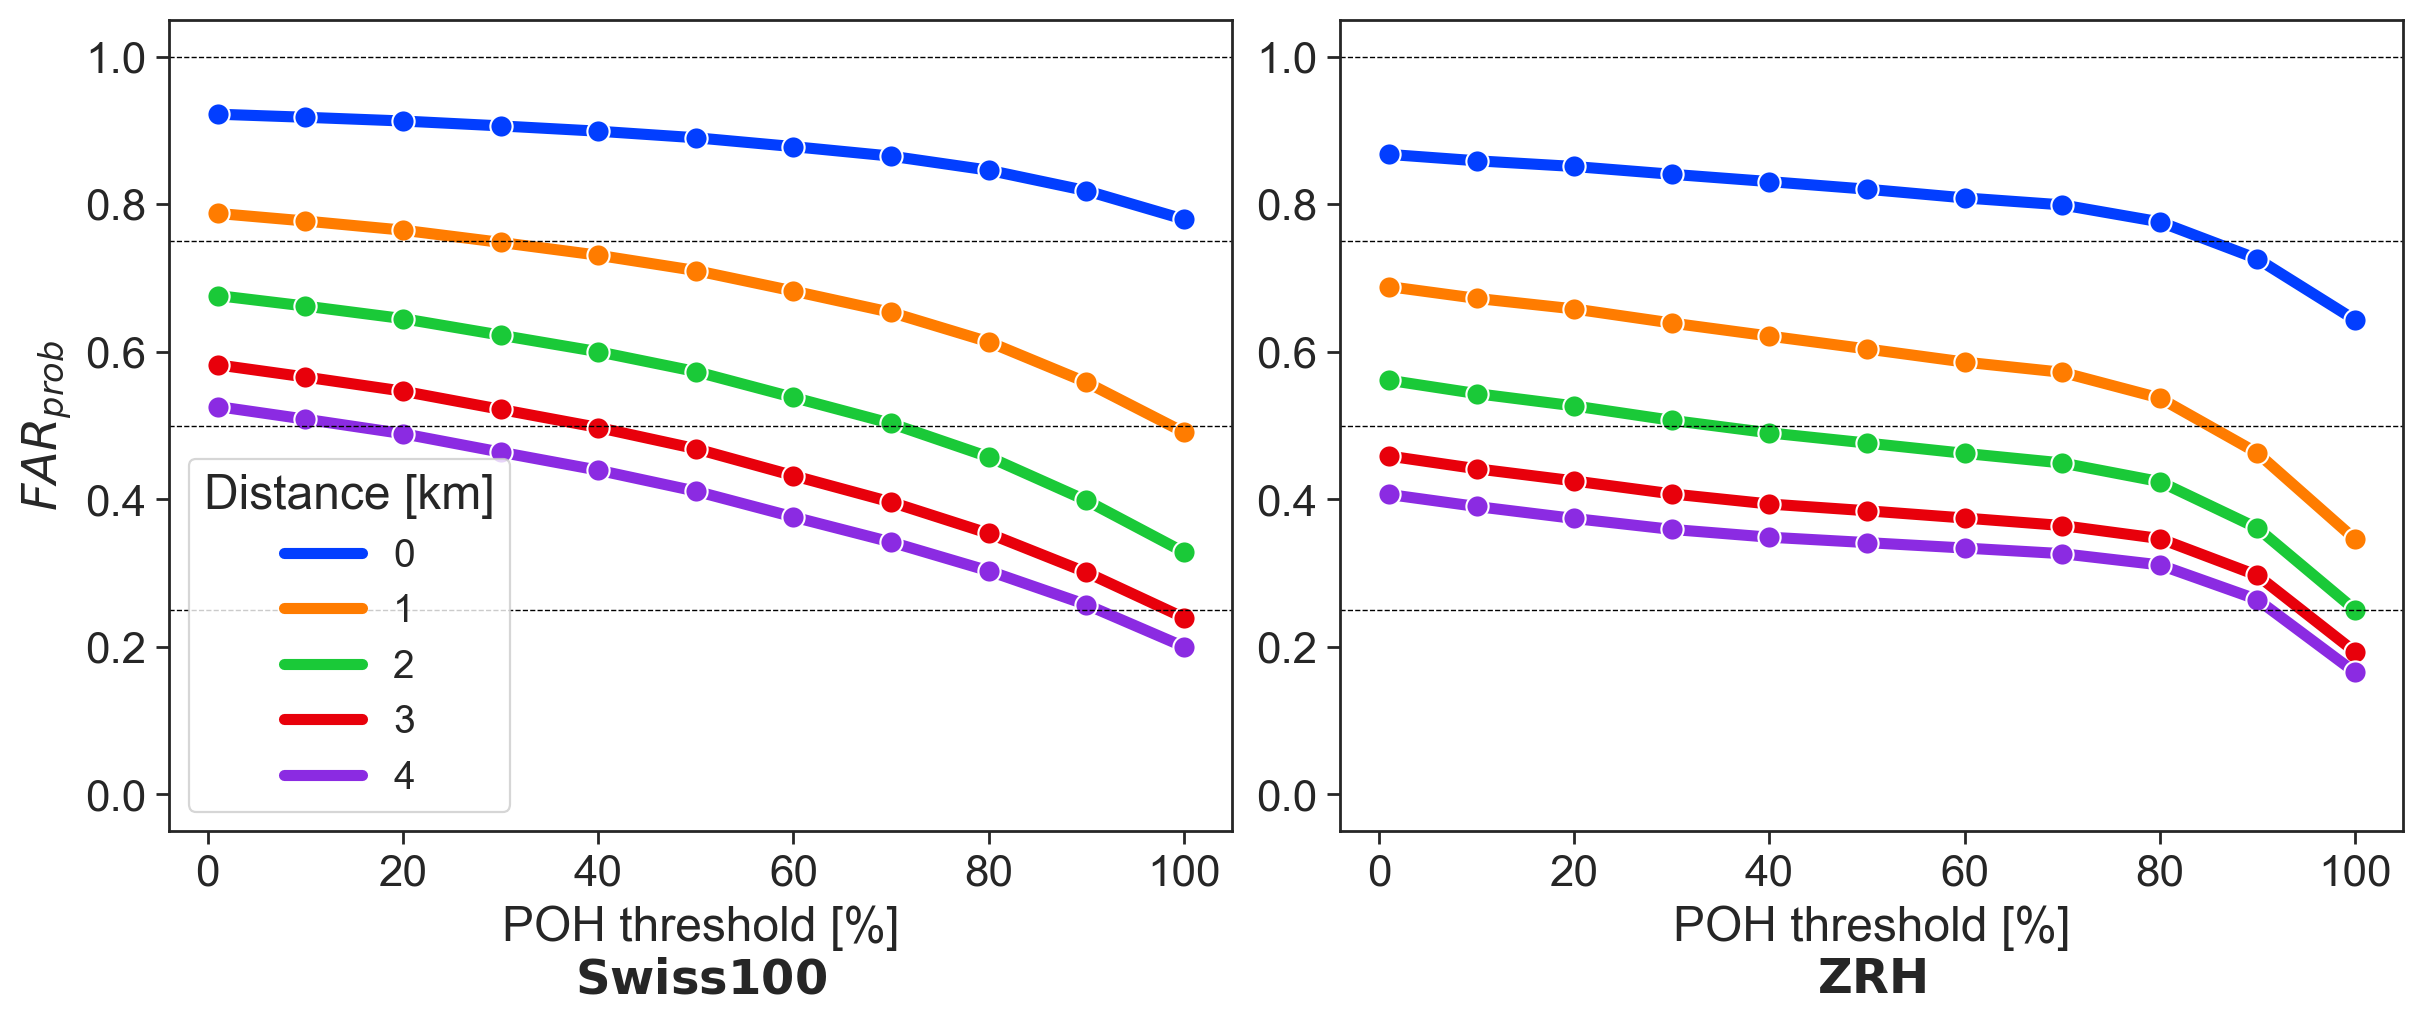

In [45]:
#%%capture
sns.set(style='ticks', context='paper', font_scale=1.8)
seas = 'JJA'
min_date = '2020-08-01'

ncols = 2
nrows = 1

x_val = 'value'
h_val = 'distance'
fix_val = 'clust_CZC_8km_480s'
st = pd.read_pickle('verifications_final_allregions.pkl')

st = st.sort_values(by=['distance',x_val], ascending=True)

dist_list = [0,1,2,3,4]

#ls_regions = st['region'].unique().tolist()
ls_regions = ['all100d33_2', 'ZRH_2'] 

st = st.loc[(st['min_date'] == min_date) & (st['season'] == seas) & (st['method'] == fix_val) & (st['distance'].isin(dist_list)) & (st['sc'] == 'FAR')]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained',figsize = (12,5),dpi=200)

for j,region in enumerate(ls_regions):
    data = st.loc[(st['region'] == region)]

    if j==0:
        t = sns.lineplot(data=data.loc[data['product'] == 'POH'],ax=axs[j],x=x_val, y='FAR', hue=h_val, legend = True, linewidth = 4, marker='o',markersize=8,palette='bright')
        legend_handles, _= t.get_legend_handles_labels()
    
        legend_handles, labels= t.get_legend_handles_labels()
        for legobj in legend_handles:
            legobj.set_linewidth(4)
        t.legend(legend_handles, labels, title='Distance [km]', prop={'size': 14})
    else:
        sns.lineplot(data=data.loc[data['product'] == 'POH'],ax=axs[j],x=x_val, y='FAR', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')  

    axs[j].axhline(1, color='black', linestyle='dashed', lw=0.5)
    axs[j].axhline(0.75, color='black', linestyle='dashed', lw=0.5)
    axs[j].axhline(0.5, color='black', linestyle='dashed', lw=0.5)
    axs[j].axhline(0.25, color='black', linestyle='dashed', lw=0.5)
    axs[j].set_ylim(-0.05,1.05)
    axs[j].xaxis.set_tick_params(labelbottom=True)
        
    if (j==0):
        axs[j].set(ylabel='$FAR_{prob}$')
    else:
        axs[j].set(ylabel='')
    
    axs[j].set(xlabel='POH threshold [%]\n' + r"$\bf{" + data['region_name'].iloc[0]+ "}$")


plt.savefig('plots/distance_match_fraction_F_%s.png' % (fix_val), bbox_inches = 'tight',dpi=200)

### Figures 8 and 17

In [157]:
data.loc[(data['distance'] == 4),'CSI']

645    0.200108
646    0.210165
647    0.222184
648    0.236910
649    0.252500
650    0.270283
651    0.291529
652    0.310275
653    0.321542
654    0.315119
655    0.261202
Name: CSI, dtype: float64

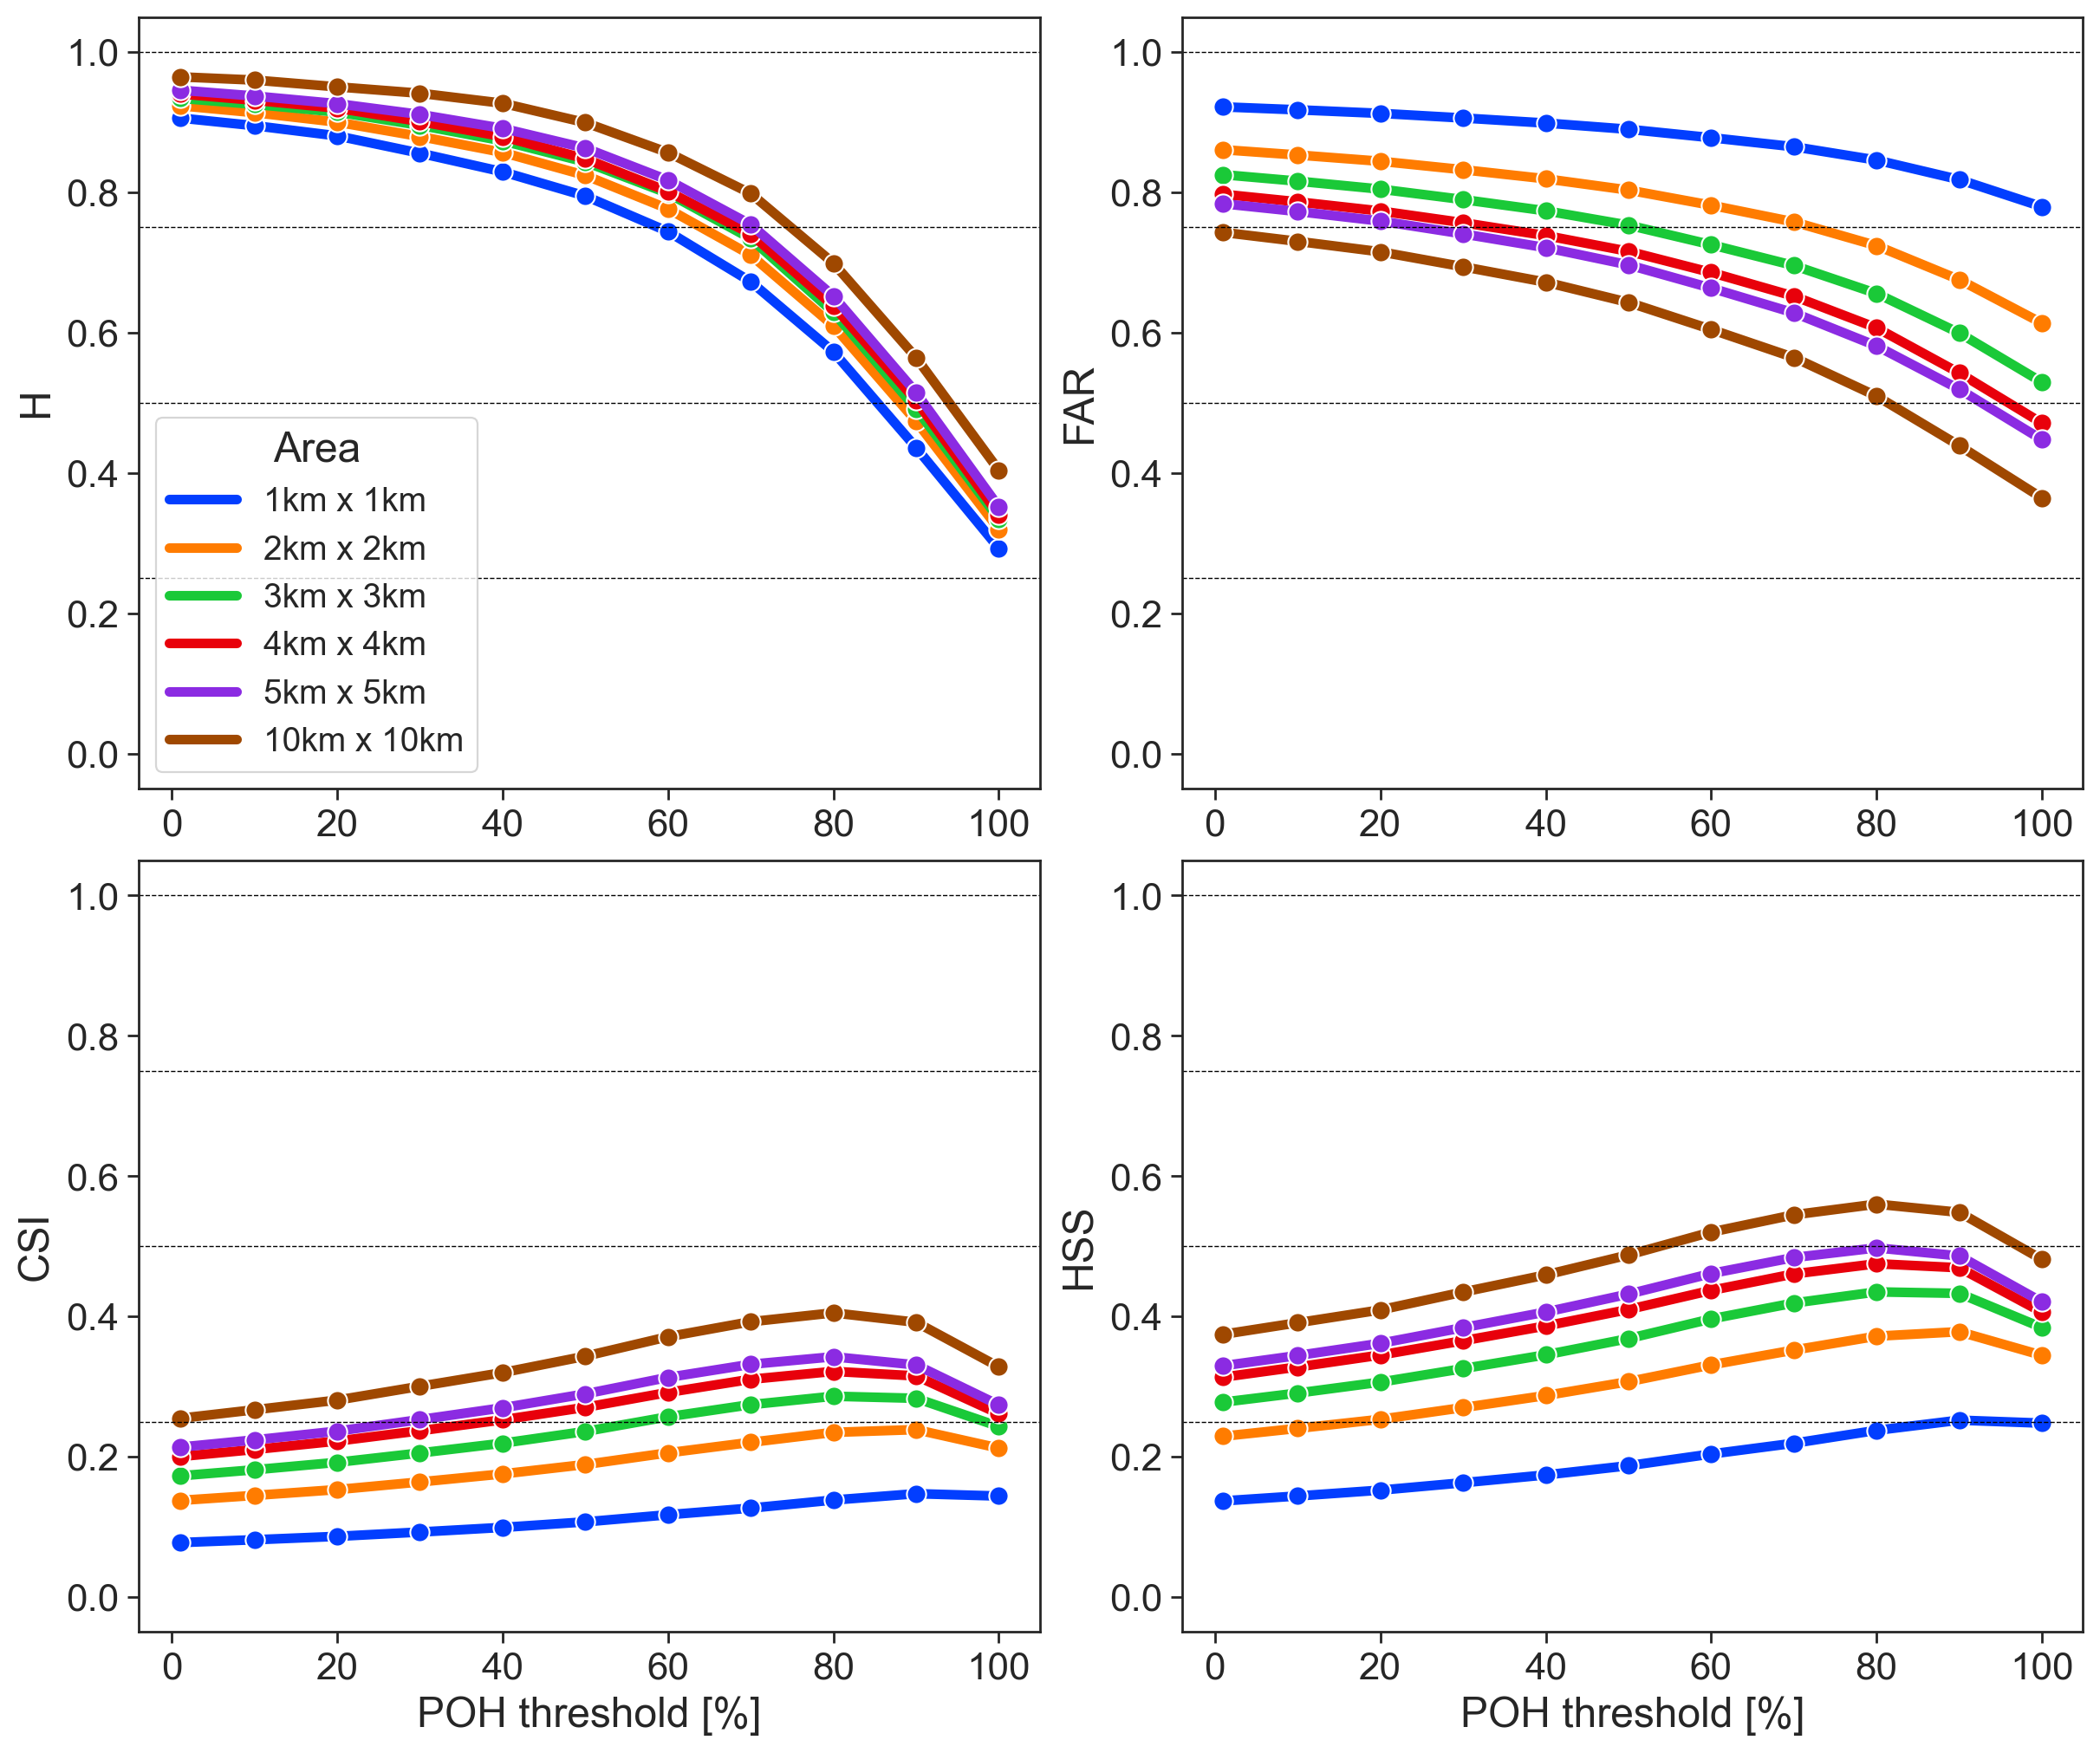

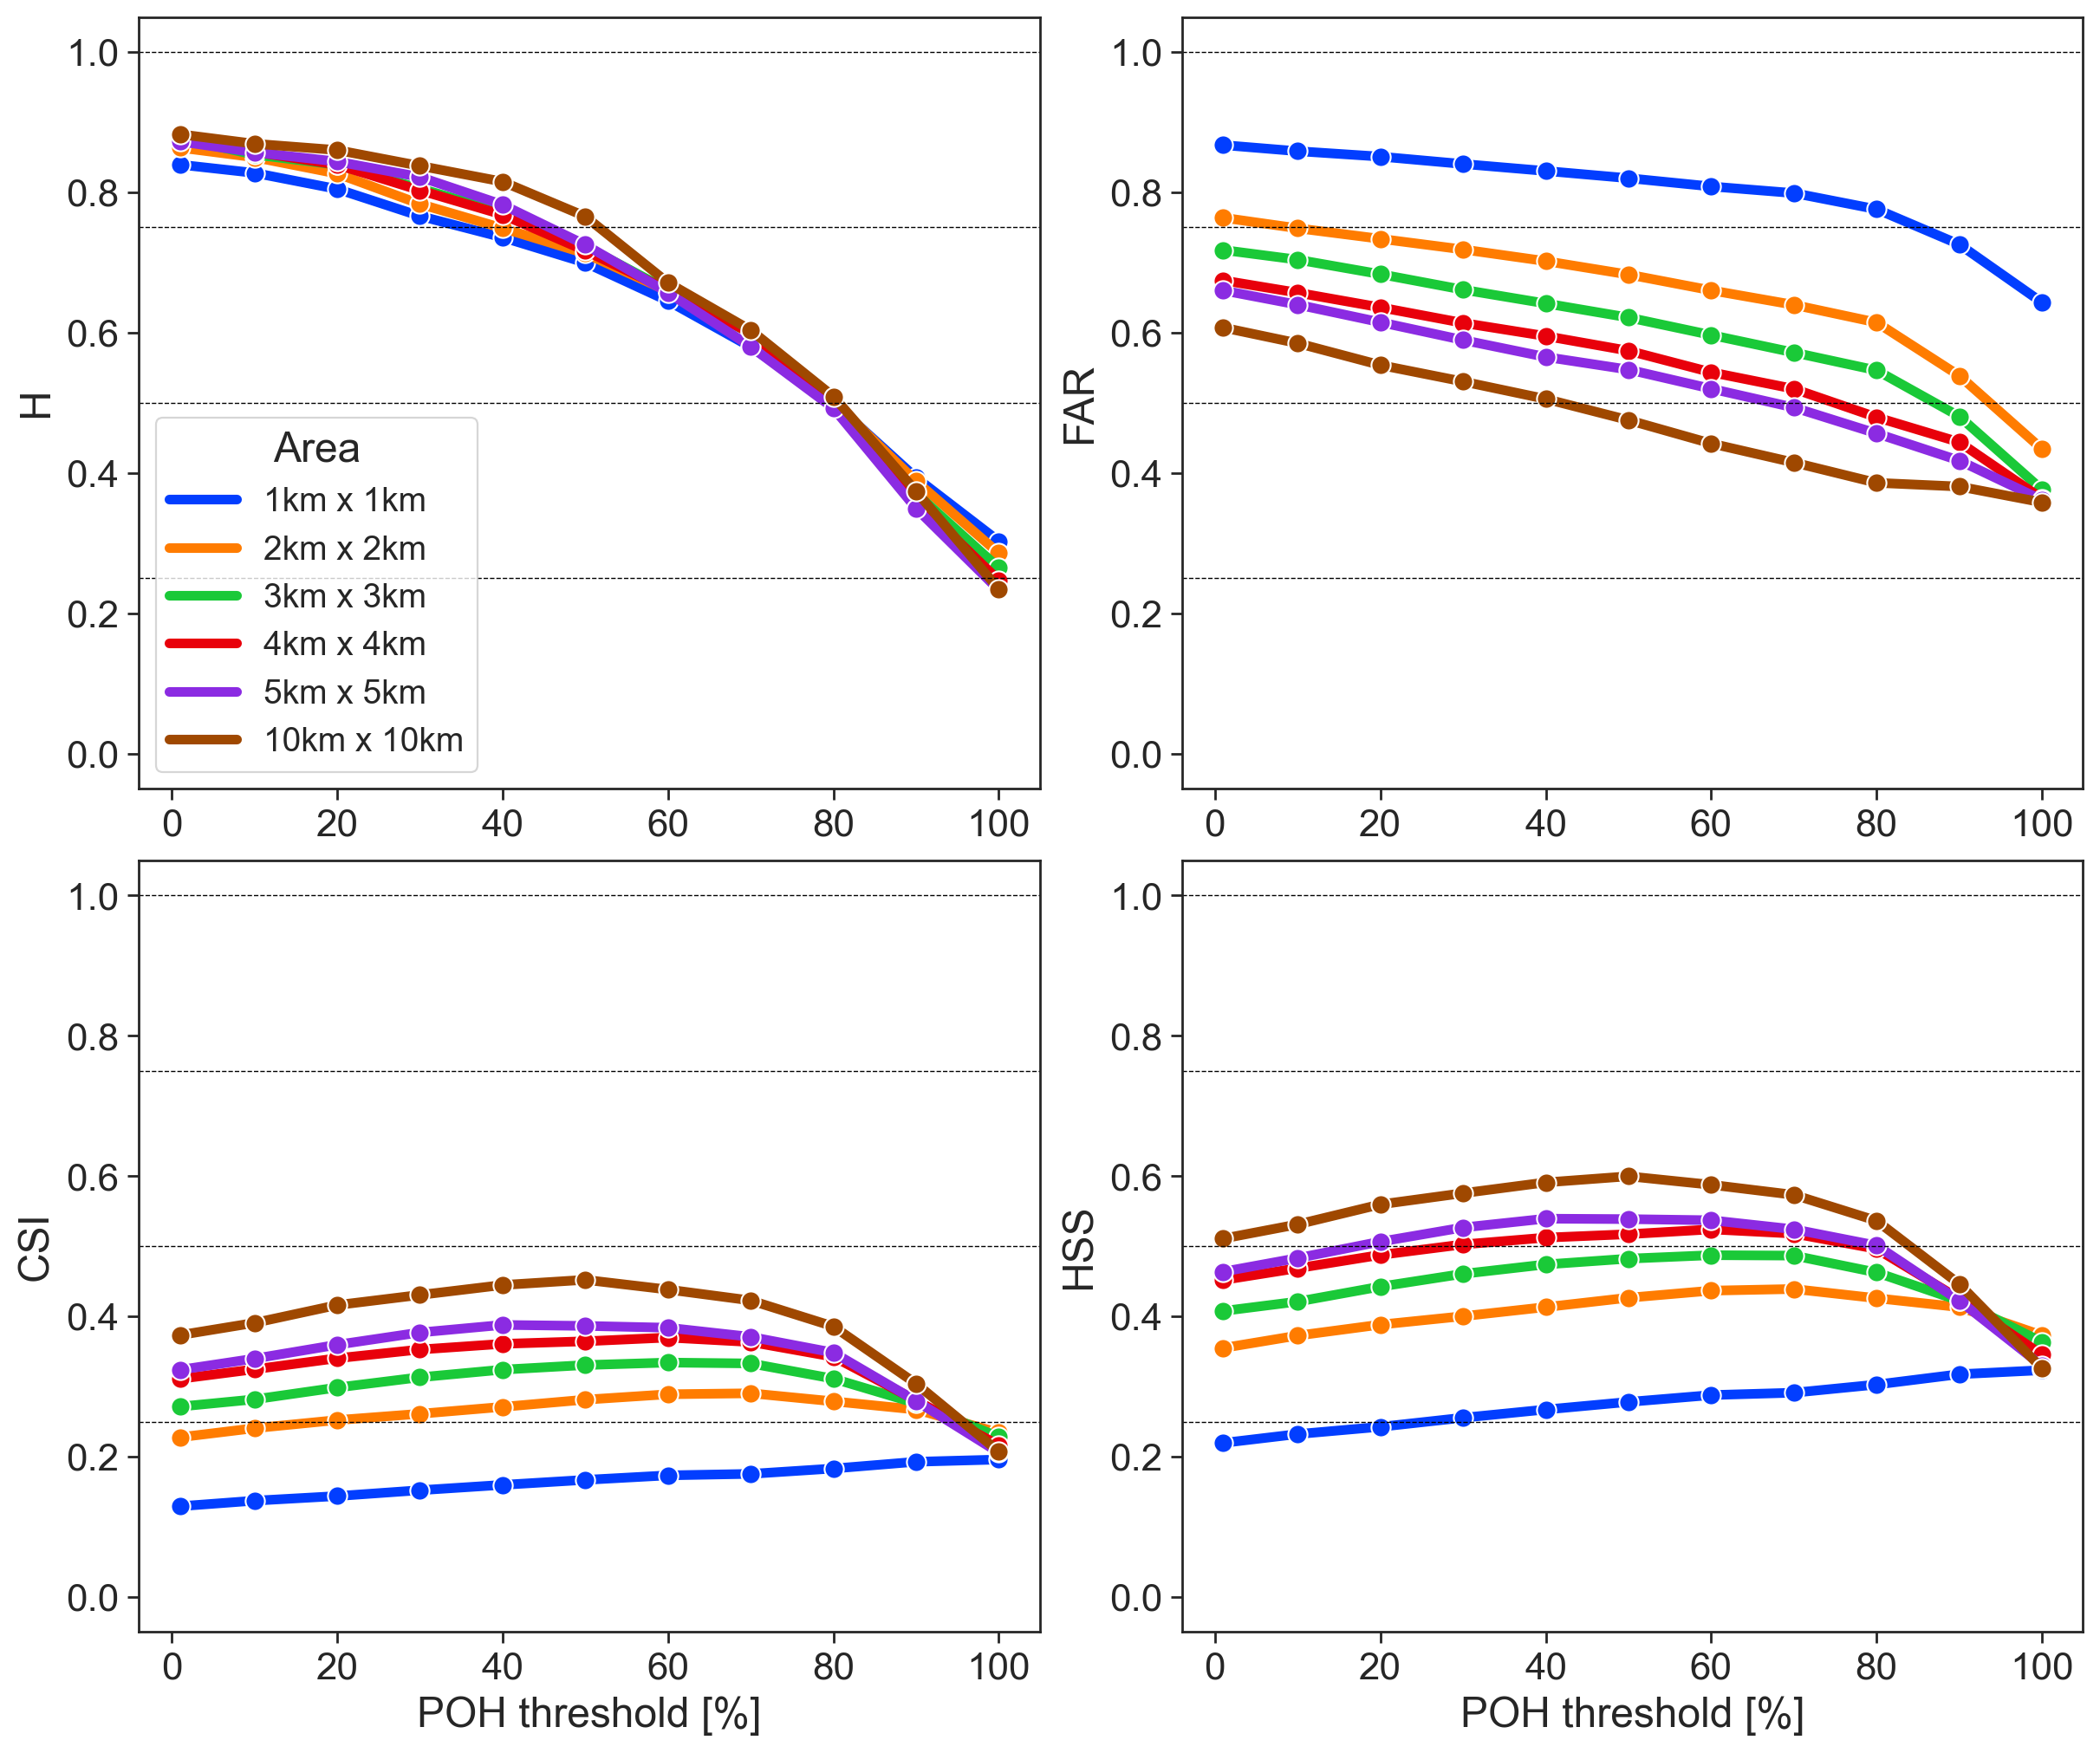

In [48]:
#%%capture
sns.set(style='ticks', context='paper', font_scale=1.8)
seas = 'JJA'
min_date = '2020-08-01'

ncols = 2
nrows = 2

x_val = 'value'
h_val = 'area'
fix_val = 'clust_CZC_8km_480s'
st = pd.read_pickle('verifications_final_upscale_allregions.pkl') #verifications_final_new_allregions

st = st.sort_values(by=['distance',x_val], ascending=True)

dist_list = [1,2,3,4,5,10]

#ls_regions = st['region'].unique().tolist()
ls_regions = ['all100d33_2', 'ZRH_2']

st = st.loc[(st['min_date'] == min_date) & (st['product'] == 'POH') & (st['season'] == seas)
            & (st['method'] == fix_val) & (st['distance'].isin(dist_list))]

for region in ls_regions:
    data = st.loc[(st['region'] == region)]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained',figsize = (12,10),dpi=200)
    t = sns.lineplot(data=data,ax=axs[0,0],x=x_val, y='H', hue=h_val, legend = True, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[0,1],x=x_val, y='FAR', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[1,0],x=x_val, y='CSI', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[1,1],x=x_val, y='HSS', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    
    legend_handles, labels= t.get_legend_handles_labels()
    for legobj in legend_handles:
        legobj.set_linewidth(4)
    t.legend(legend_handles, labels, title='Area', prop={'size': 14})
    
    #axs[0,0].text(-0.05, 0, 'matplotlib', horizontalalignment='center',verticalalignment='center', fontsize= 14)#, transform=axs[0,0].transAxes)
        

    for j in np.arange(0,nrows):
        for i in np.arange(0,ncols):
            axs[j,i].axhline(1, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.75, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.5, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.25, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].set_ylim(-0.05,1.05)
            
            if (j==0):
                axs[j,i].set(xlabel=None)
            if (j==1):
                axs[j,i].xaxis.set_tick_params(labelbottom=True)
                axs[j,i].set(xlabel='POH threshold [%]')

    plt.savefig('plots/distance_upscale_%s_%s.png' % (region, fix_val), bbox_inches = 'tight',dpi=200)

### Figures 10 and 19

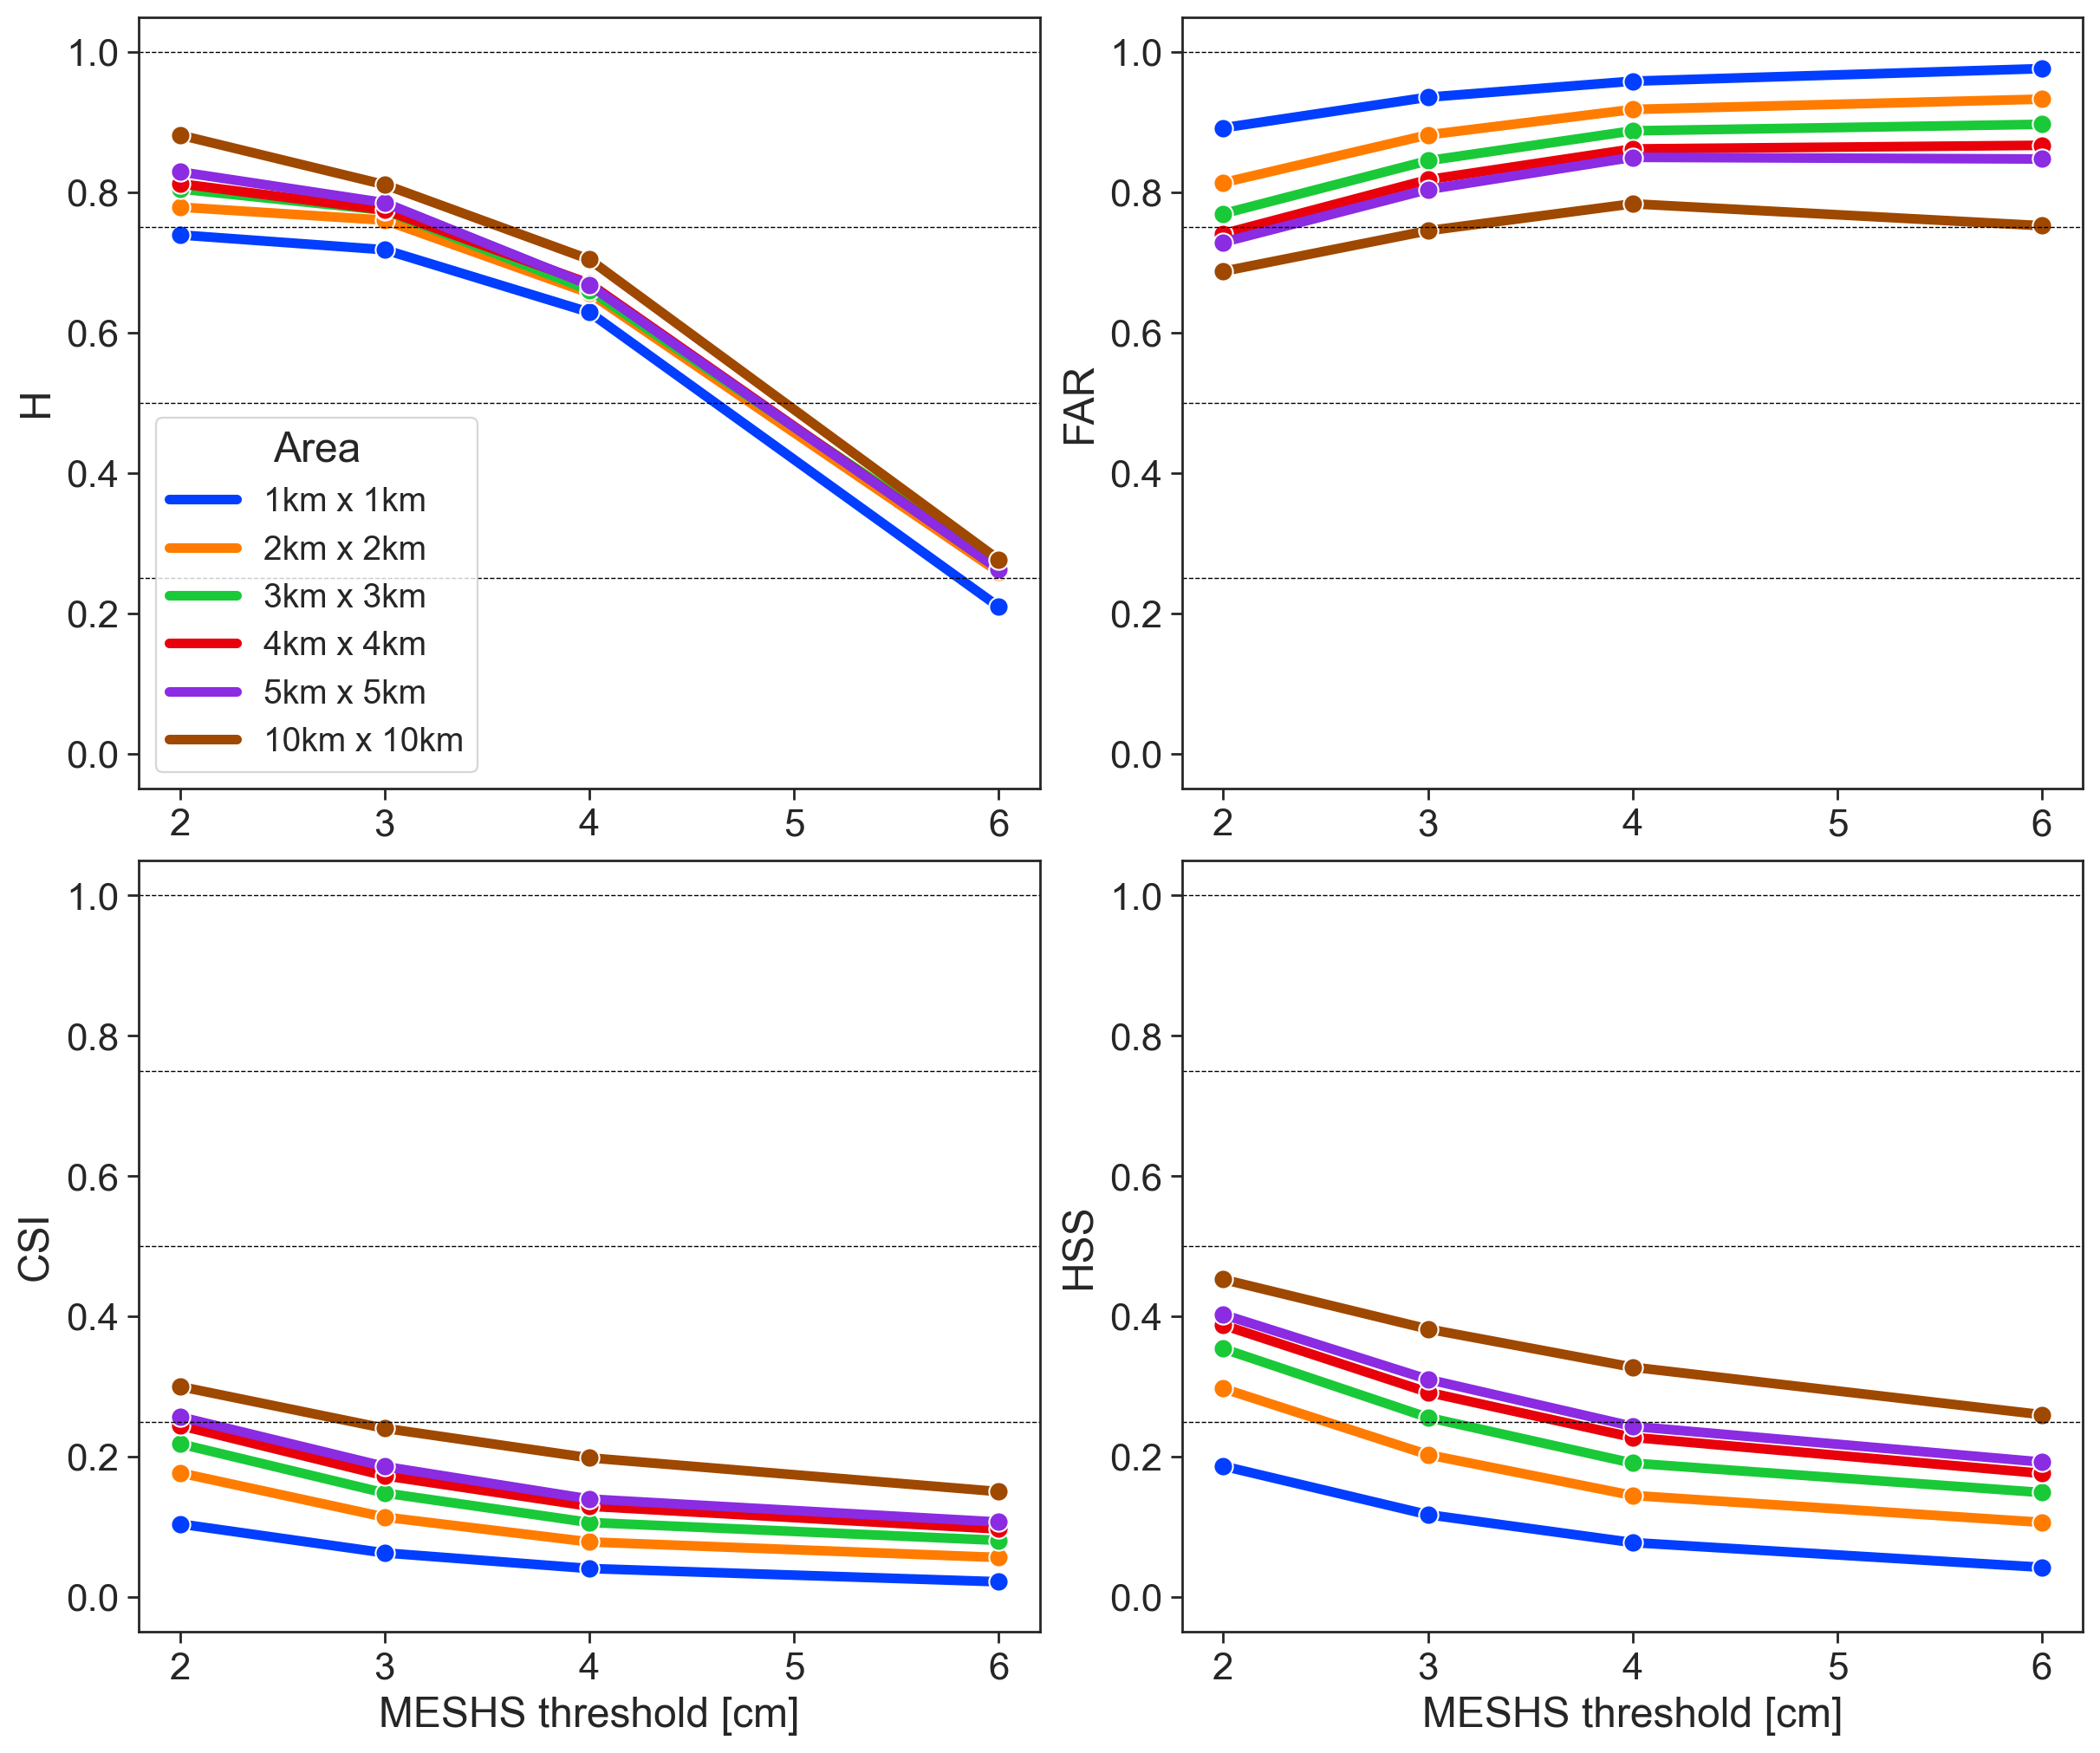

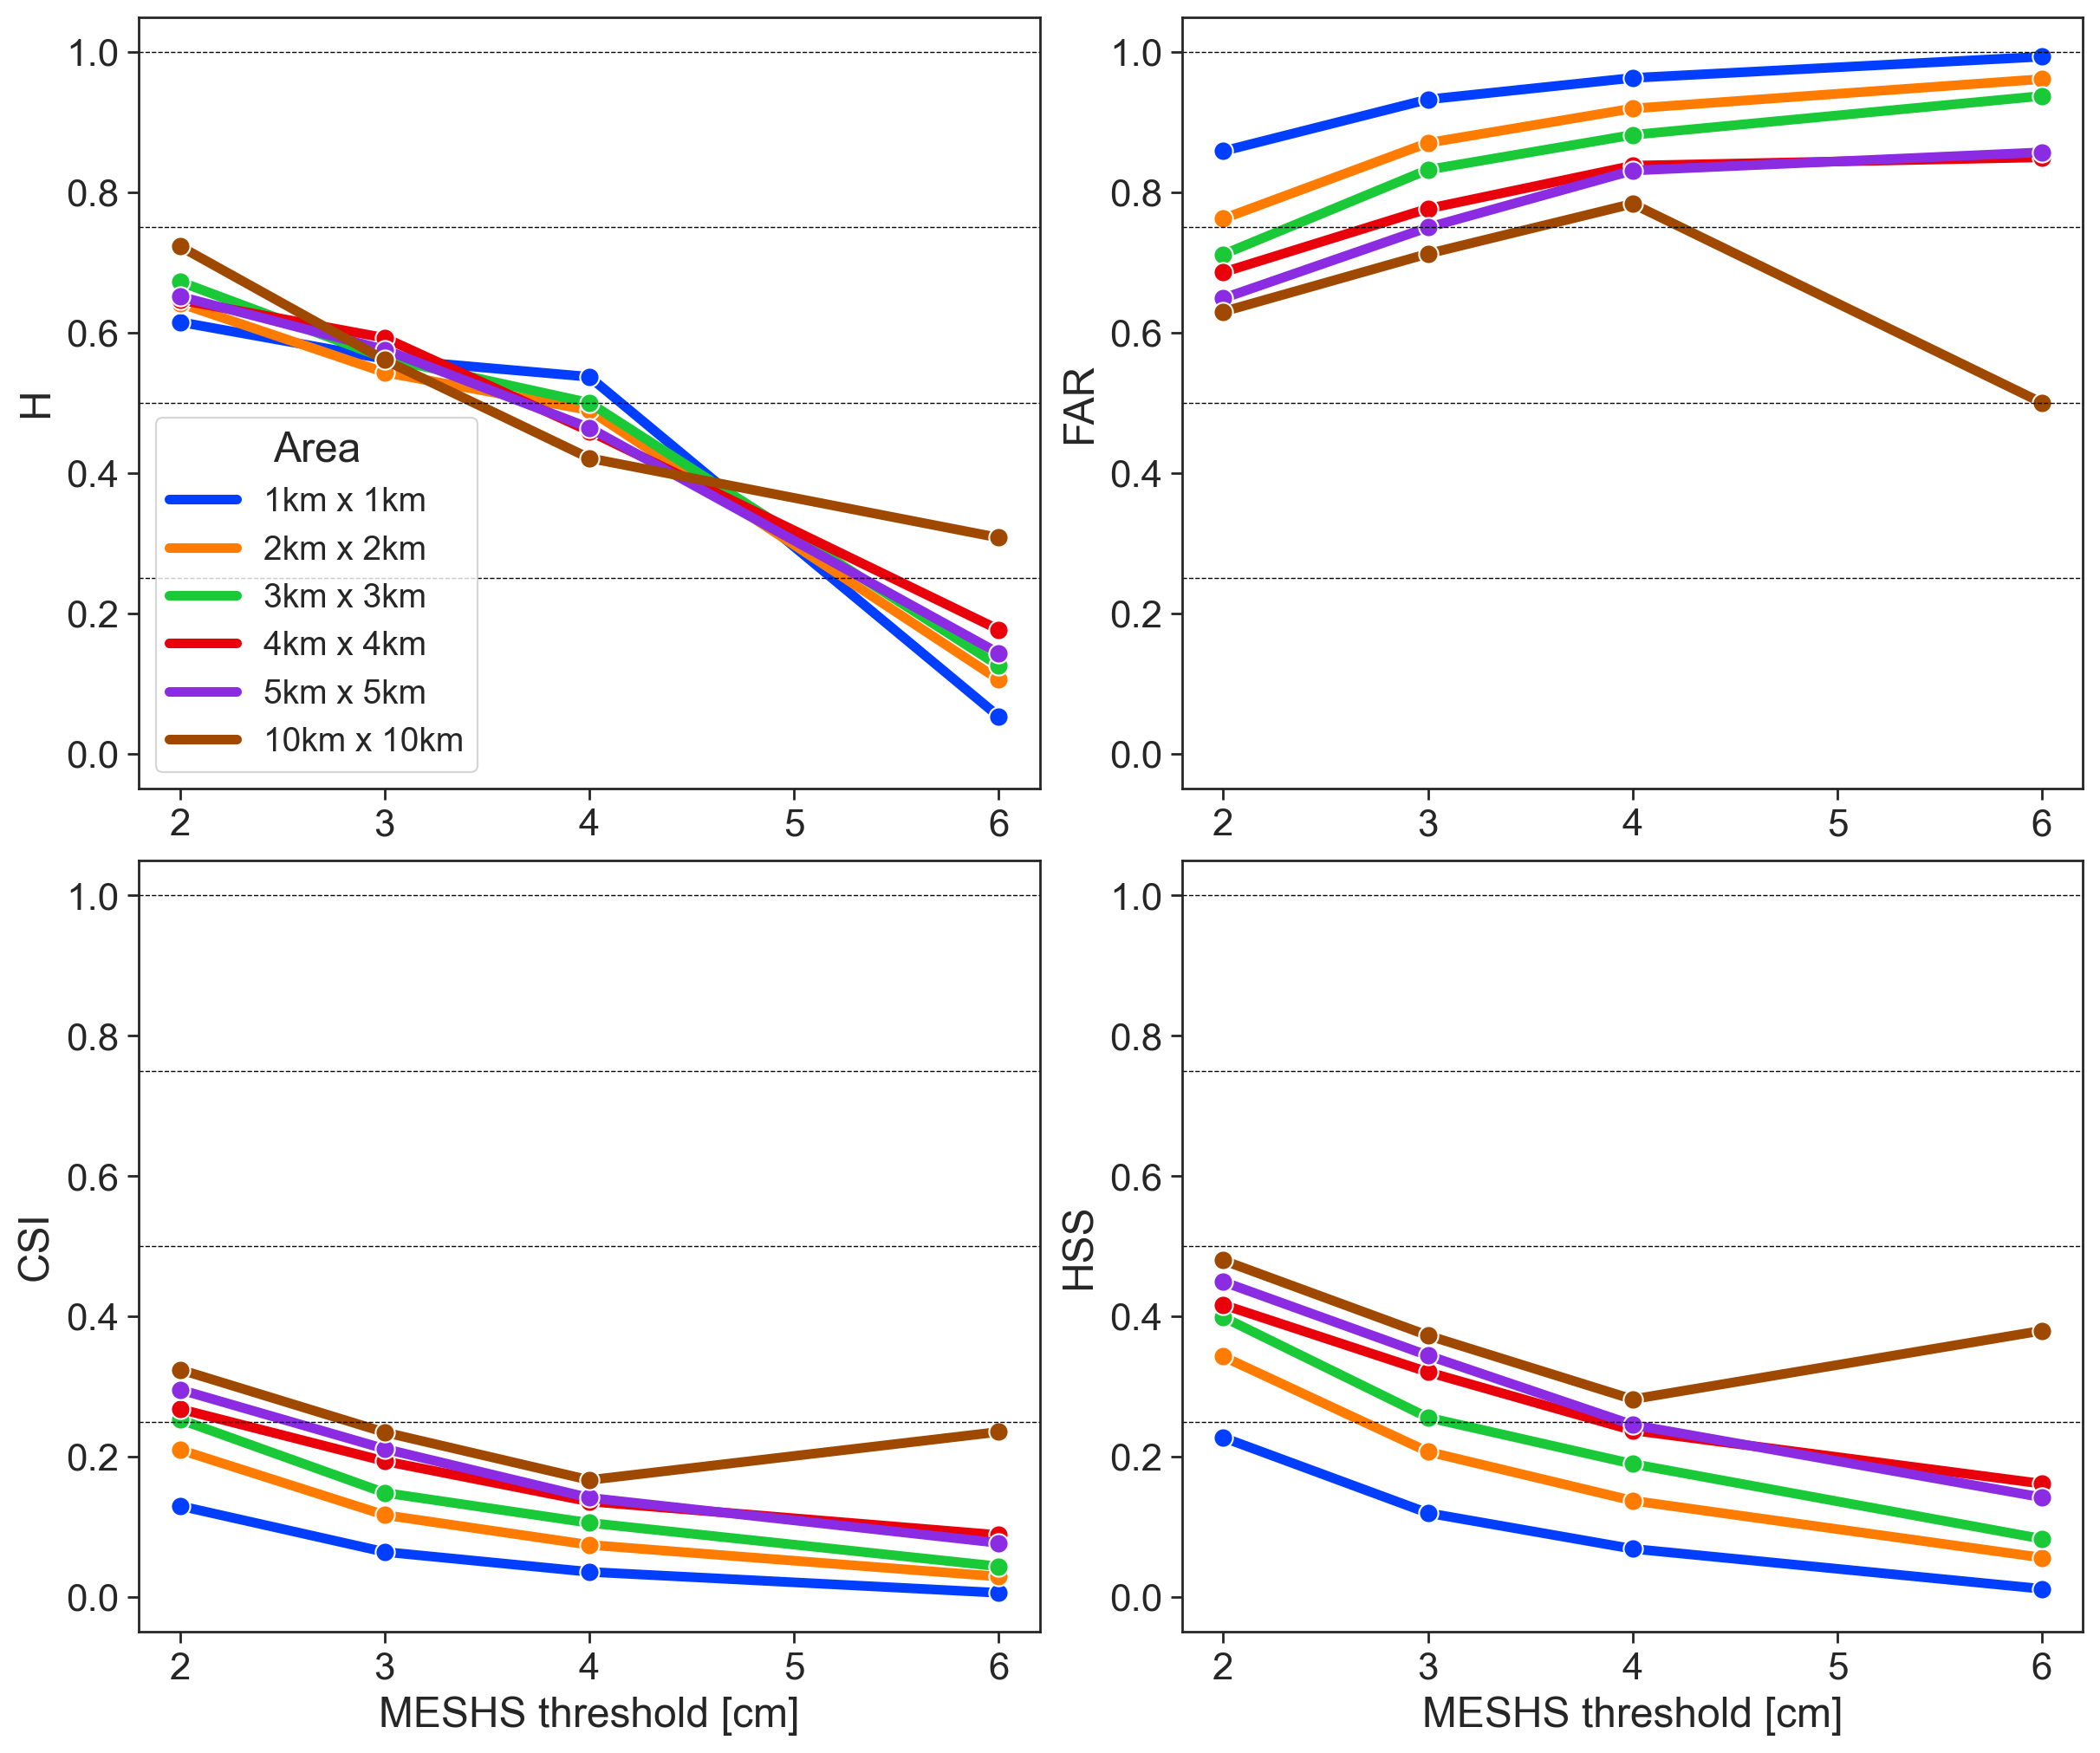

In [130]:
#%%capture
sns.set(style='ticks', context='paper', font_scale=1.8)
seas = 'JJA'
min_date = '2020-08-01'

ncols = 2
nrows = 2

x_val = 'value'
h_val = 'area'
fix_val = 'clust_CZC_8km_480s'
st = pd.read_pickle('verifications_final_upscale_allregions.pkl')

st = st.sort_values(by=['distance',x_val], ascending=True)

dist_list = [1,2,3,4,5,10]

ls_regions = ['ZRH_2_large','all100d33_2_large']

st = st.loc[(st['min_date'] == min_date) & (st['product'] == 'MESHS') & (st['season'] == seas)
            & (st['method'] == fix_val) & (st['distance'].isin(dist_list))]

for region in ls_regions:
    data = st.loc[(st['region'] == region)]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained',figsize = (12,10),dpi=200)
    t = sns.lineplot(data=data,ax=axs[0,0],x=x_val, y='H', hue=h_val, legend = True, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[0,1],x=x_val, y='FAR', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[1,0],x=x_val, y='CSI', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[1,1],x=x_val, y='HSS', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    
    legend_handles, labels= t.get_legend_handles_labels()
    for legobj in legend_handles:
        legobj.set_linewidth(4)
    t.legend(legend_handles, labels, title='Area', prop={'size': 14})
        

    for j in np.arange(0,nrows):
        for i in np.arange(0,ncols):
            axs[j,i].axhline(1, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.75, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.5, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.25, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].set_ylim(-0.05,1.05)
            
            if (j==0):
                axs[j,i].set(xlabel=None)
            if (j==1):
                axs[j,i].xaxis.set_tick_params(labelbottom=True)
                axs[j,i].set(xlabel='MESHS threshold [cm]')

    plt.savefig('plots/MESHS_distance_upscale_%s_%s.png' % (region, fix_val), bbox_inches = 'tight',dpi=200)

### Figure 22

In [9]:
data

region method    field distance    min_date   sc season  \
3142  all100d33_2_large    CZC  MESHS_2        2  2020-08-01    H    JJA   
3143  all100d33_2_large    CZC  MESHS_2        2  2020-08-01  FAR    JJA   
3144  all100d33_2_large    CZC  MESHS_3        2  2020-08-01    H    JJA   
3145  all100d33_2_large    CZC  MESHS_3        2  2020-08-01  FAR    JJA   
3146  all100d33_2_large    CZC  MESHS_4        2  2020-08-01    H    JJA   
3147  all100d33_2_large    CZC  MESHS_4        2  2020-08-01  FAR    JJA   
3148  all100d33_2_large    CZC  MESHS_6        2  2020-08-01    H    JJA   
3149  all100d33_2_large    CZC  MESHS_6        2  2020-08-01  FAR    JJA   

          Bias         H       FAR       CSI      A      B     C product  \
3142  4.602460  0.658519  0.856920  0.133197   8352  50021  4331   MESHS   
3143  1.717364  0.819486  0.522823  0.431791  27075  29665  5964   MESHS   
3144  6.631685  0.551564  0.916829  0.077903   2733  30127  2222   MESHS   
3145  2.450144  0.792014  0.676748  0.297959  10453  21884  2745   MESHS   
3146  6.419455  0.366148  0.942963  0.051912    941  15557  1629   MESHS   
3147  2.797560  0.682420  0.756066  0.219065   3971  12308  1848   MESHS   
3148  1.828632  0.074753  0.959121  0.027145    106   2487  1312   MESHS   
3149  1.420613  0.245125  0.827451  0.112676    440   2110  1355   MESHS   

      value region_name  
3142      2    Swiss100  
3143      2    Swiss100  
3144      3    Swiss100  
3145      3    Swiss100  
3146      4    Swiss100  
3147      4    Swiss100  
3148      6    Swiss100  
3149      6    Swiss100

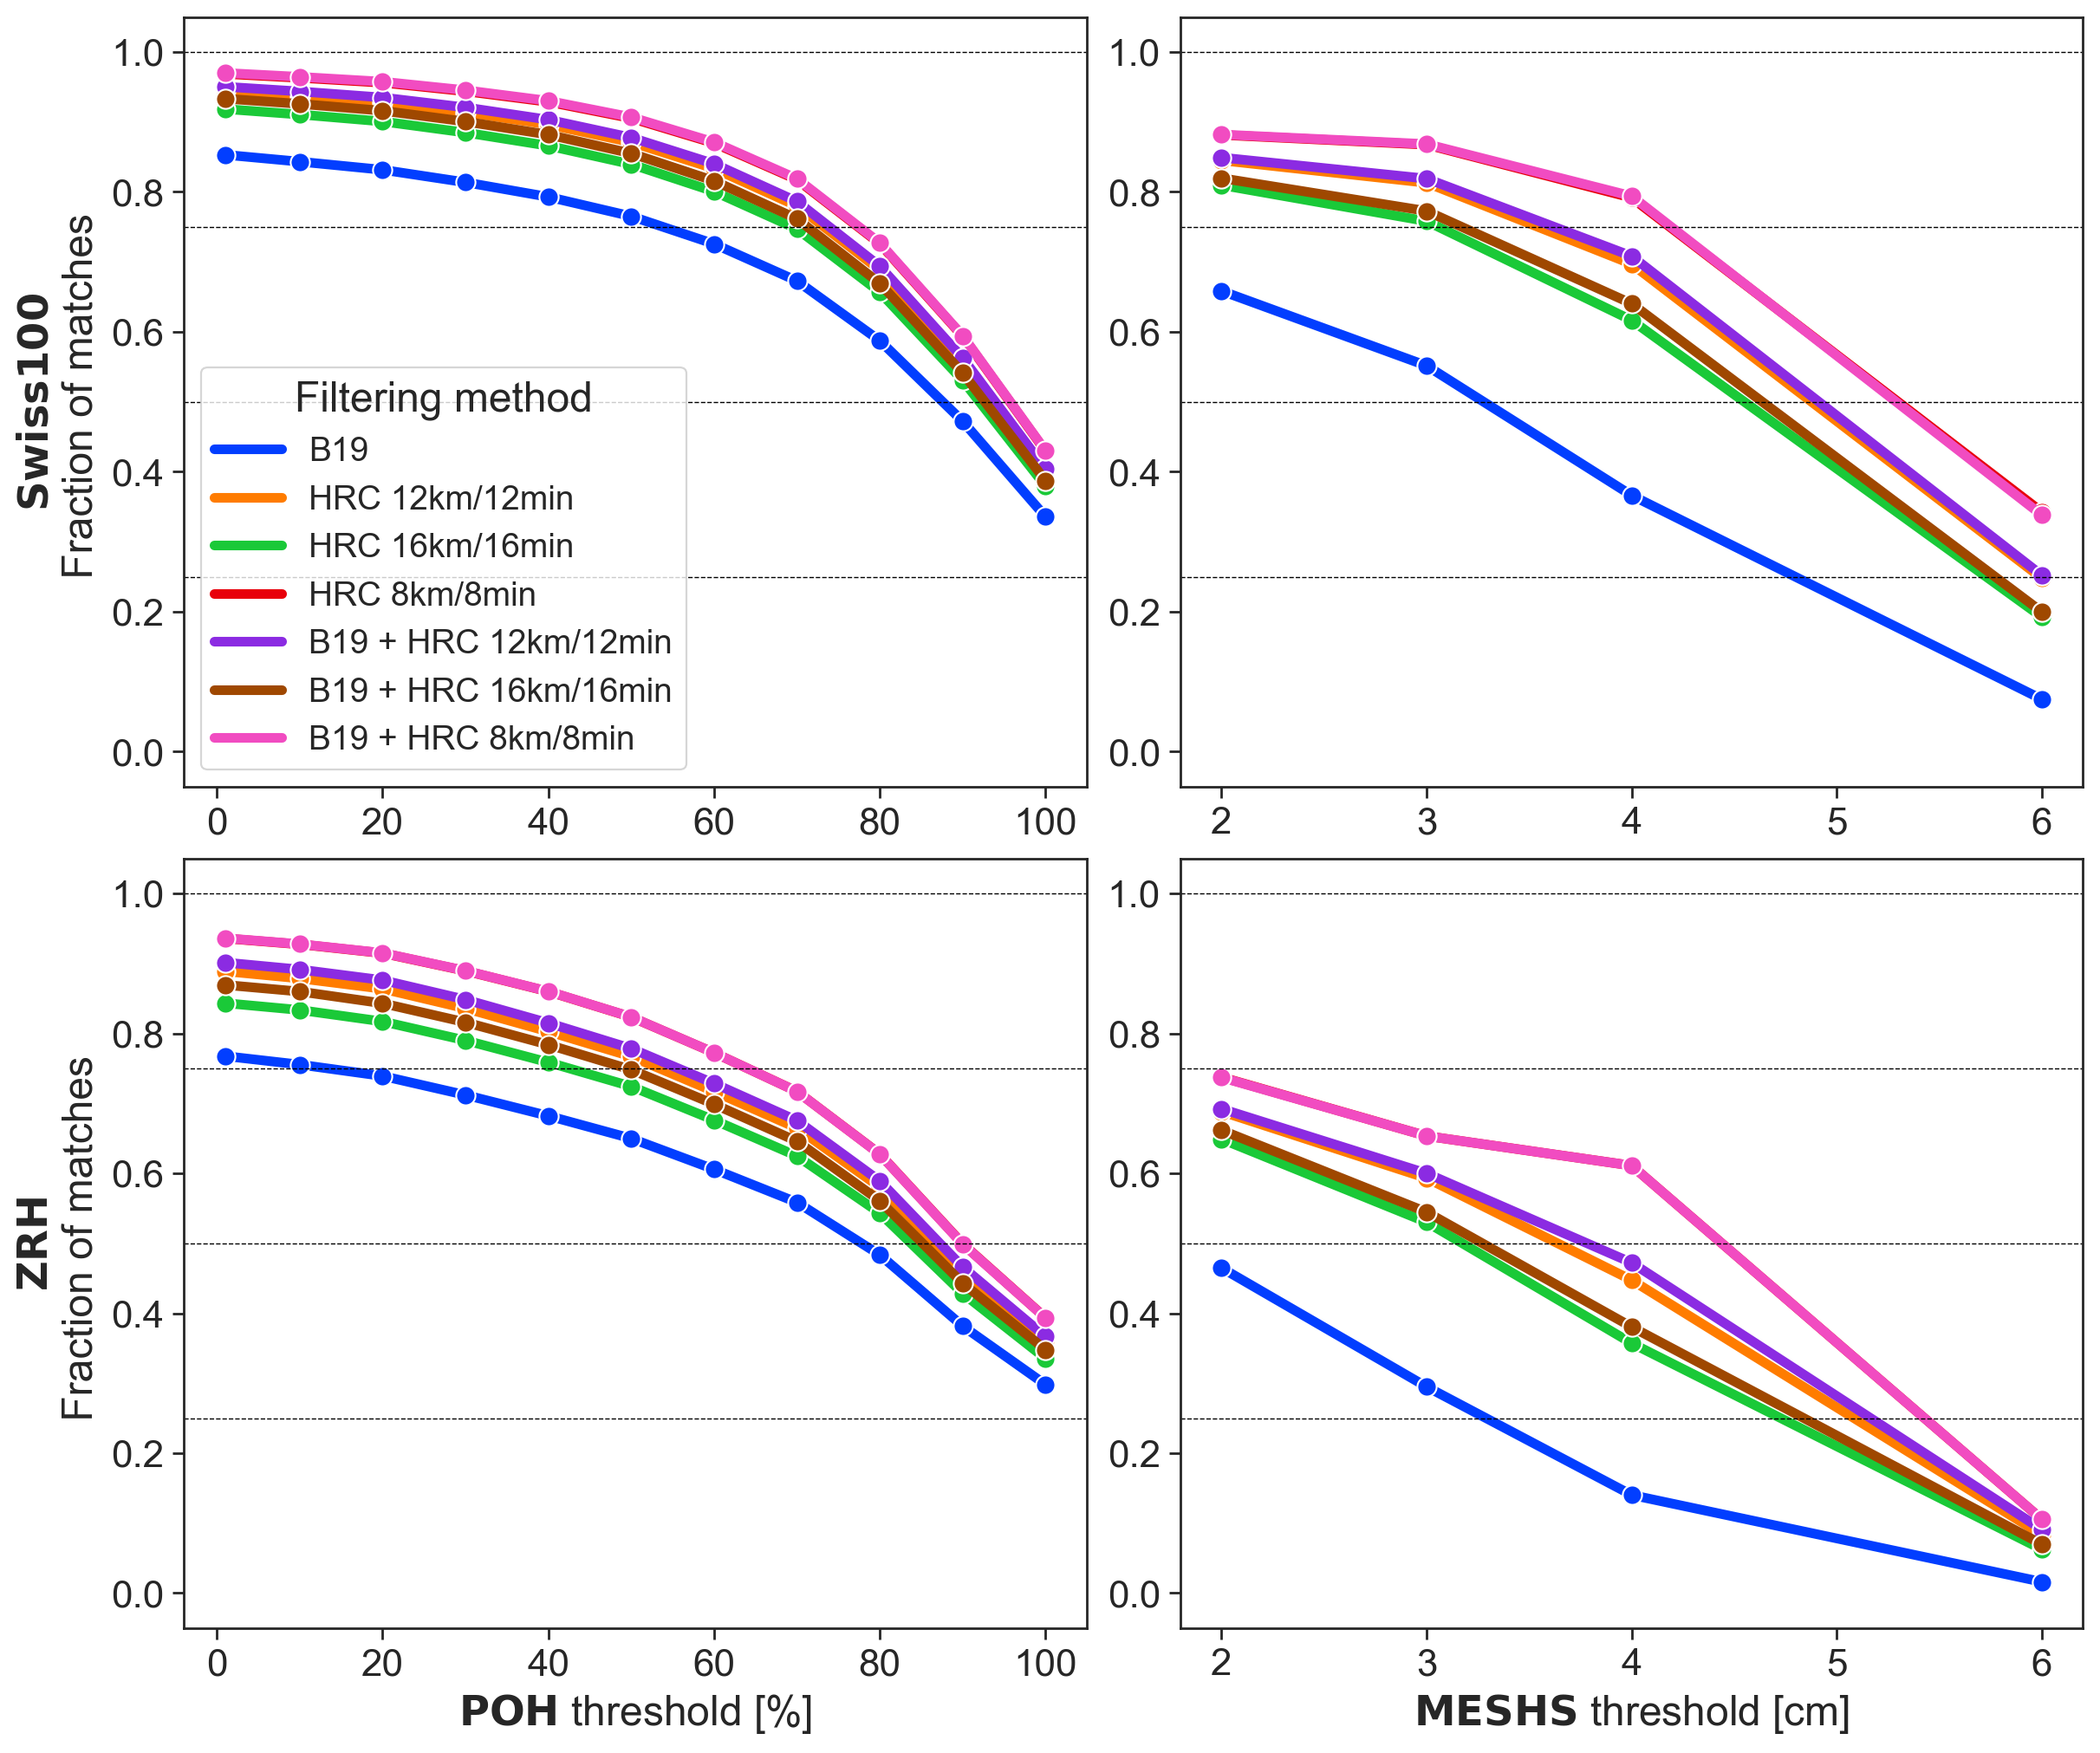

In [39]:
#%%capture
sns.set(style='ticks', context='paper', font_scale=1.8)
seas = 'JJA'
min_date = '2020-08-01'

ncols = 2
nrows = 2

x_val = 'value'
h_val = 'method'
fix_val = 2
st = pd.read_pickle('verifications_final_allregions.pkl')

st = st.sort_values(by=['method',x_val], ascending=True)

ls_methods = st['method'].unique().tolist()
ls_regions = ['all100d33_2', 'ZRH_2','all100d33_2_large','ZRH_2_large']

st = st.loc[(st['min_date'] == min_date) & (st['season'] == seas) & (st['distance'] == fix_val) & (st['method'].isin(ls_methods)) & (st['sc'] == 'H')]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained',figsize = (12,10),dpi=200)

for j,region in enumerate(ls_regions):
    data = st.loc[(st['region'] == region)]

    if j==0:
        t = sns.lineplot(data=data.loc[data['product'] == 'POH'],ax=axs[j,0],x=x_val, y='H', hue=h_val, legend = True, linewidth = 4, marker='o',markersize=8,palette='bright')
        legend_handles, _= t.get_legend_handles_labels()
    
        labels = ['B19','HRC 12km/12min','HRC 16km/16min','HRC 8km/8min','B19 + HRC 12km/12min','B19 + HRC 16km/16min','B19 + HRC 8km/8min']
        for legobj in legend_handles:
            legobj.set_linewidth(4)
        t.legend(legend_handles, labels, title='Filtering method', prop={'size': 14})
    
    if j==1:
        sns.lineplot(data=data.loc[data['product'] == 'POH'],ax=axs[j,0],x=x_val, y='H', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
        
    
    if j>=2:
        sns.lineplot(data=data.loc[data['product'] == 'MESHS'],ax=axs[j-2,1],x=x_val, y='H', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')


    if (j<2):
        axs[j,0].set(ylabel=r"$\bf{" + data['region_name'].iloc[0]+ "}$" +'\n Fraction of matches')
    else:
        axs[j-2,1].set(ylabel='')

for j in np.arange(0,nrows):        
    for i in np.arange(0,ncols):
        axs[j,i].axhline(1, color='black', linestyle='dashed', lw=0.5)
        axs[j,i].axhline(0.75, color='black', linestyle='dashed', lw=0.5)
        axs[j,i].axhline(0.5, color='black', linestyle='dashed', lw=0.5)
        axs[j,i].axhline(0.25, color='black', linestyle='dashed', lw=0.5)
        axs[j,i].set_ylim(-0.05,1.05)
        axs[j,i].xaxis.set_tick_params(labelbottom=True)

        if (j==0):
            axs[j,i].set(xlabel=None)
        if j==1:
            axs[j,0].set(xlabel=r'$\bf{POH}$ threshold [%]')
            axs[j,1].set(xlabel=r'$\bf{MESHS}$ threshold [cm]')

plt.savefig('plots/method_match_fraction_H_%s.png' % (fix_val), bbox_inches = 'tight',dpi=200)

### Figure 13

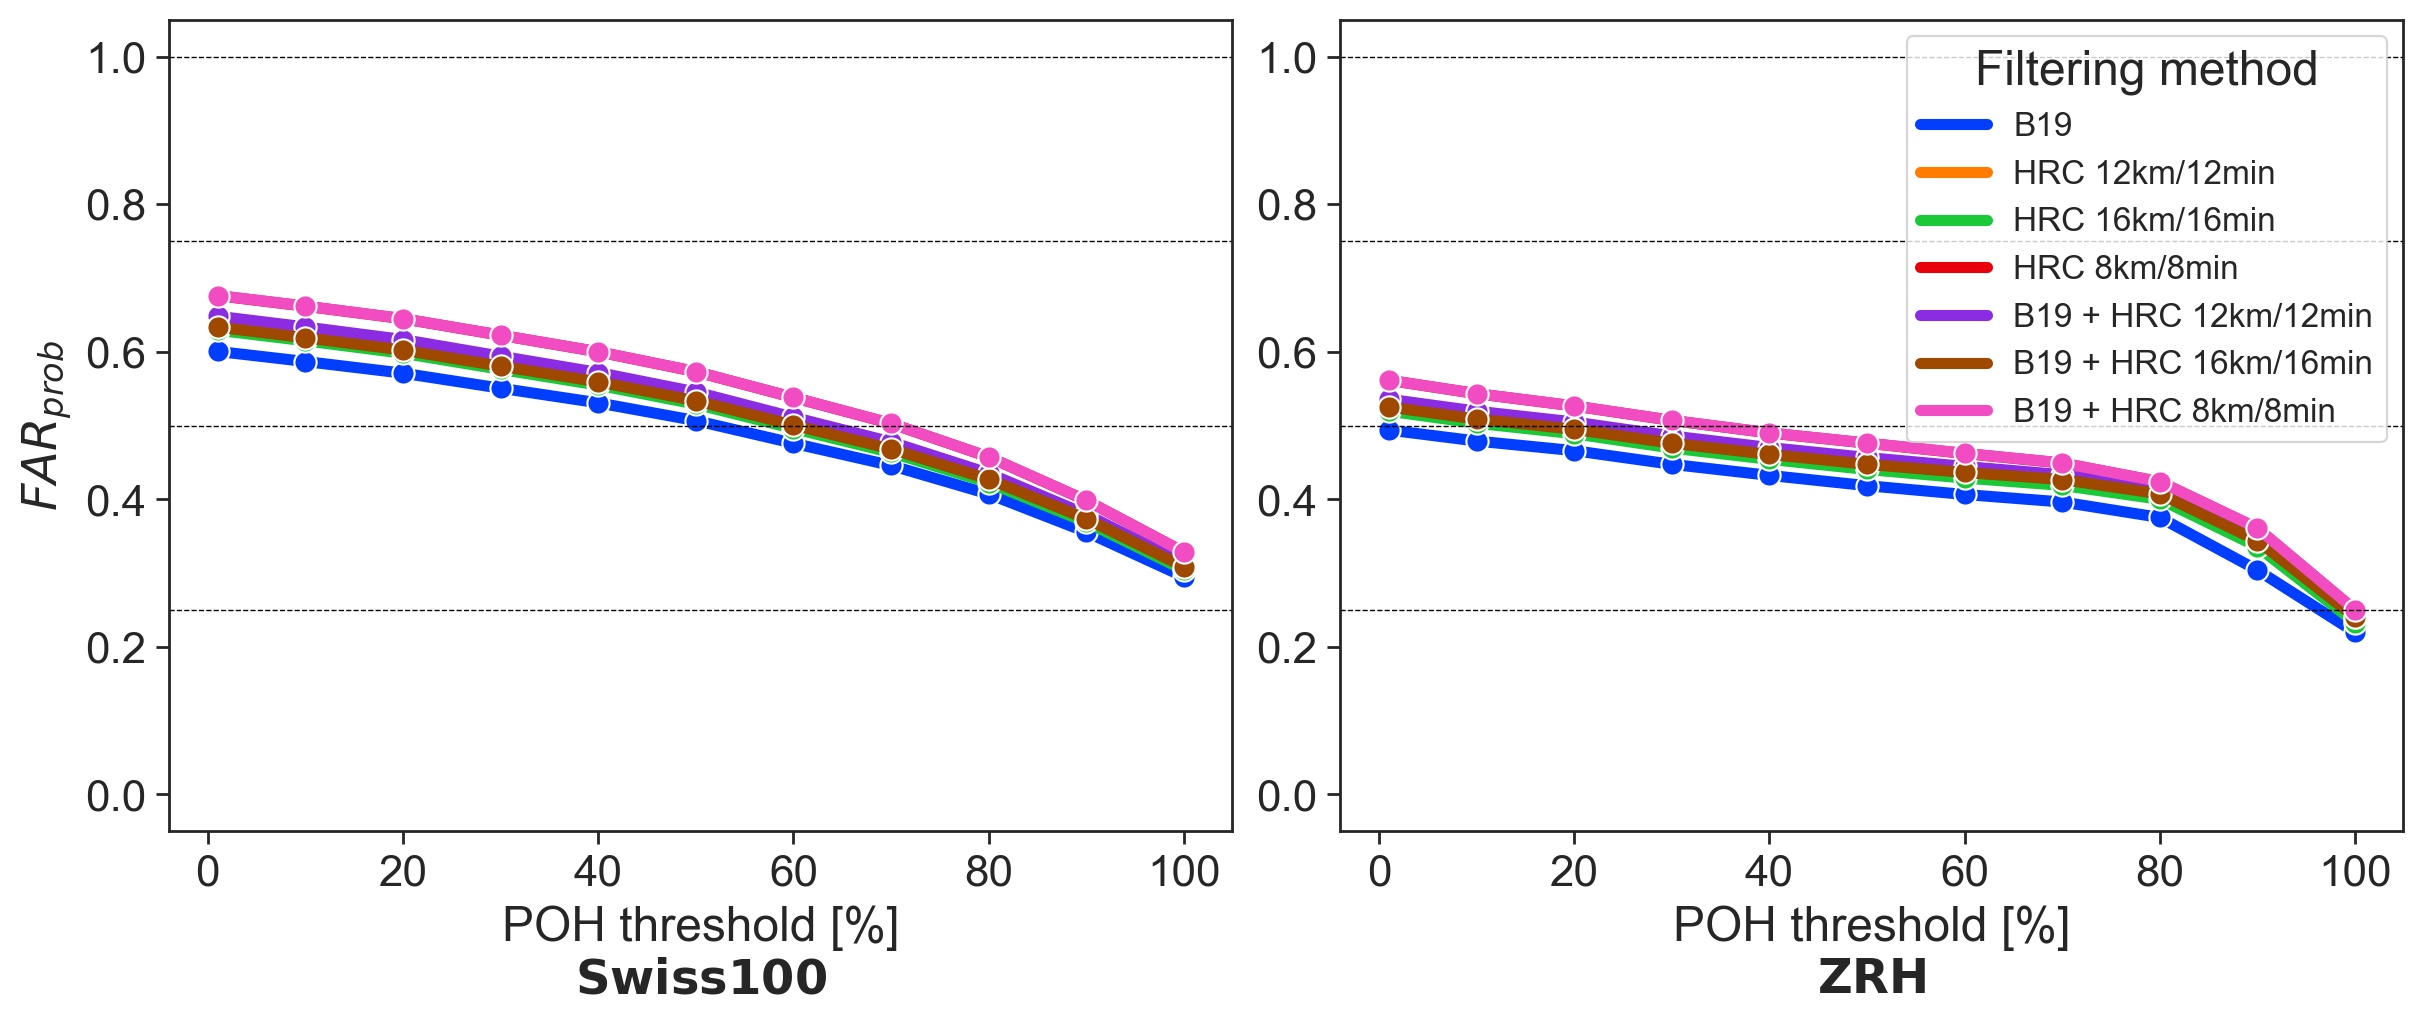

In [47]:
#%%capture
sns.set(style='ticks', context='paper', font_scale=1.8)
seas = 'JJA'
min_date = '2020-08-01'

ncols = 2
nrows = 1

x_val = 'value'
h_val = 'method'
fix_val = 2
st = pd.read_pickle('verifications_final_allregions.pkl')

st = st.sort_values(by=['method',x_val], ascending=True)

dls_methods = st['method'].unique().tolist()
ls_regions = ['all100d33_2', 'ZRH_2']

st = st.loc[(st['min_date'] == min_date) & (st['season'] == seas) & (st['distance'] == fix_val) & (st['method'].isin(ls_methods)) & (st['sc'] == 'FAR')]

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained',figsize = (12,5),dpi=200)

for j,region in enumerate(ls_regions):
    data = st.loc[(st['region'] == region)]

    if j==1:
        t = sns.lineplot(data=data.loc[data['product'] == 'POH'],ax=axs[j],x=x_val, y='FAR', hue=h_val, legend = True, linewidth = 4, marker='o',markersize=8,palette='bright')
        legend_handles, _= t.get_legend_handles_labels()
    
        labels = ['B19','HRC 12km/12min','HRC 16km/16min','HRC 8km/8min','B19 + HRC 12km/12min','B19 + HRC 16km/16min','B19 + HRC 8km/8min']
        for legobj in legend_handles:
            legobj.set_linewidth(4)
        t.legend(legend_handles, labels, title='Filtering method', prop={'size': 12})
    else:
        sns.lineplot(data=data.loc[data['product'] == 'POH'],ax=axs[j],x=x_val, y='FAR', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')  

    axs[j].axhline(1, color='black', linestyle='dashed', lw=0.5)
    axs[j].axhline(0.75, color='black', linestyle='dashed', lw=0.5)
    axs[j].axhline(0.5, color='black', linestyle='dashed', lw=0.5)
    axs[j].axhline(0.25, color='black', linestyle='dashed', lw=0.5)
    axs[j].set_ylim(-0.05,1.05)
    axs[j].xaxis.set_tick_params(labelbottom=True)
        
    if (j==0):
        axs[j].set(ylabel='$FAR_{prob}$')
    else:
        axs[j].set(ylabel='')
    
    axs[j].set(xlabel='POH threshold [%]\n' + r"$\bf{" + data['region_name'].iloc[0]+ "}$")


plt.savefig('plots/method_match_fraction_F_%s.png' % (fix_val), bbox_inches = 'tight',dpi=200)

### Figures 9 and 18

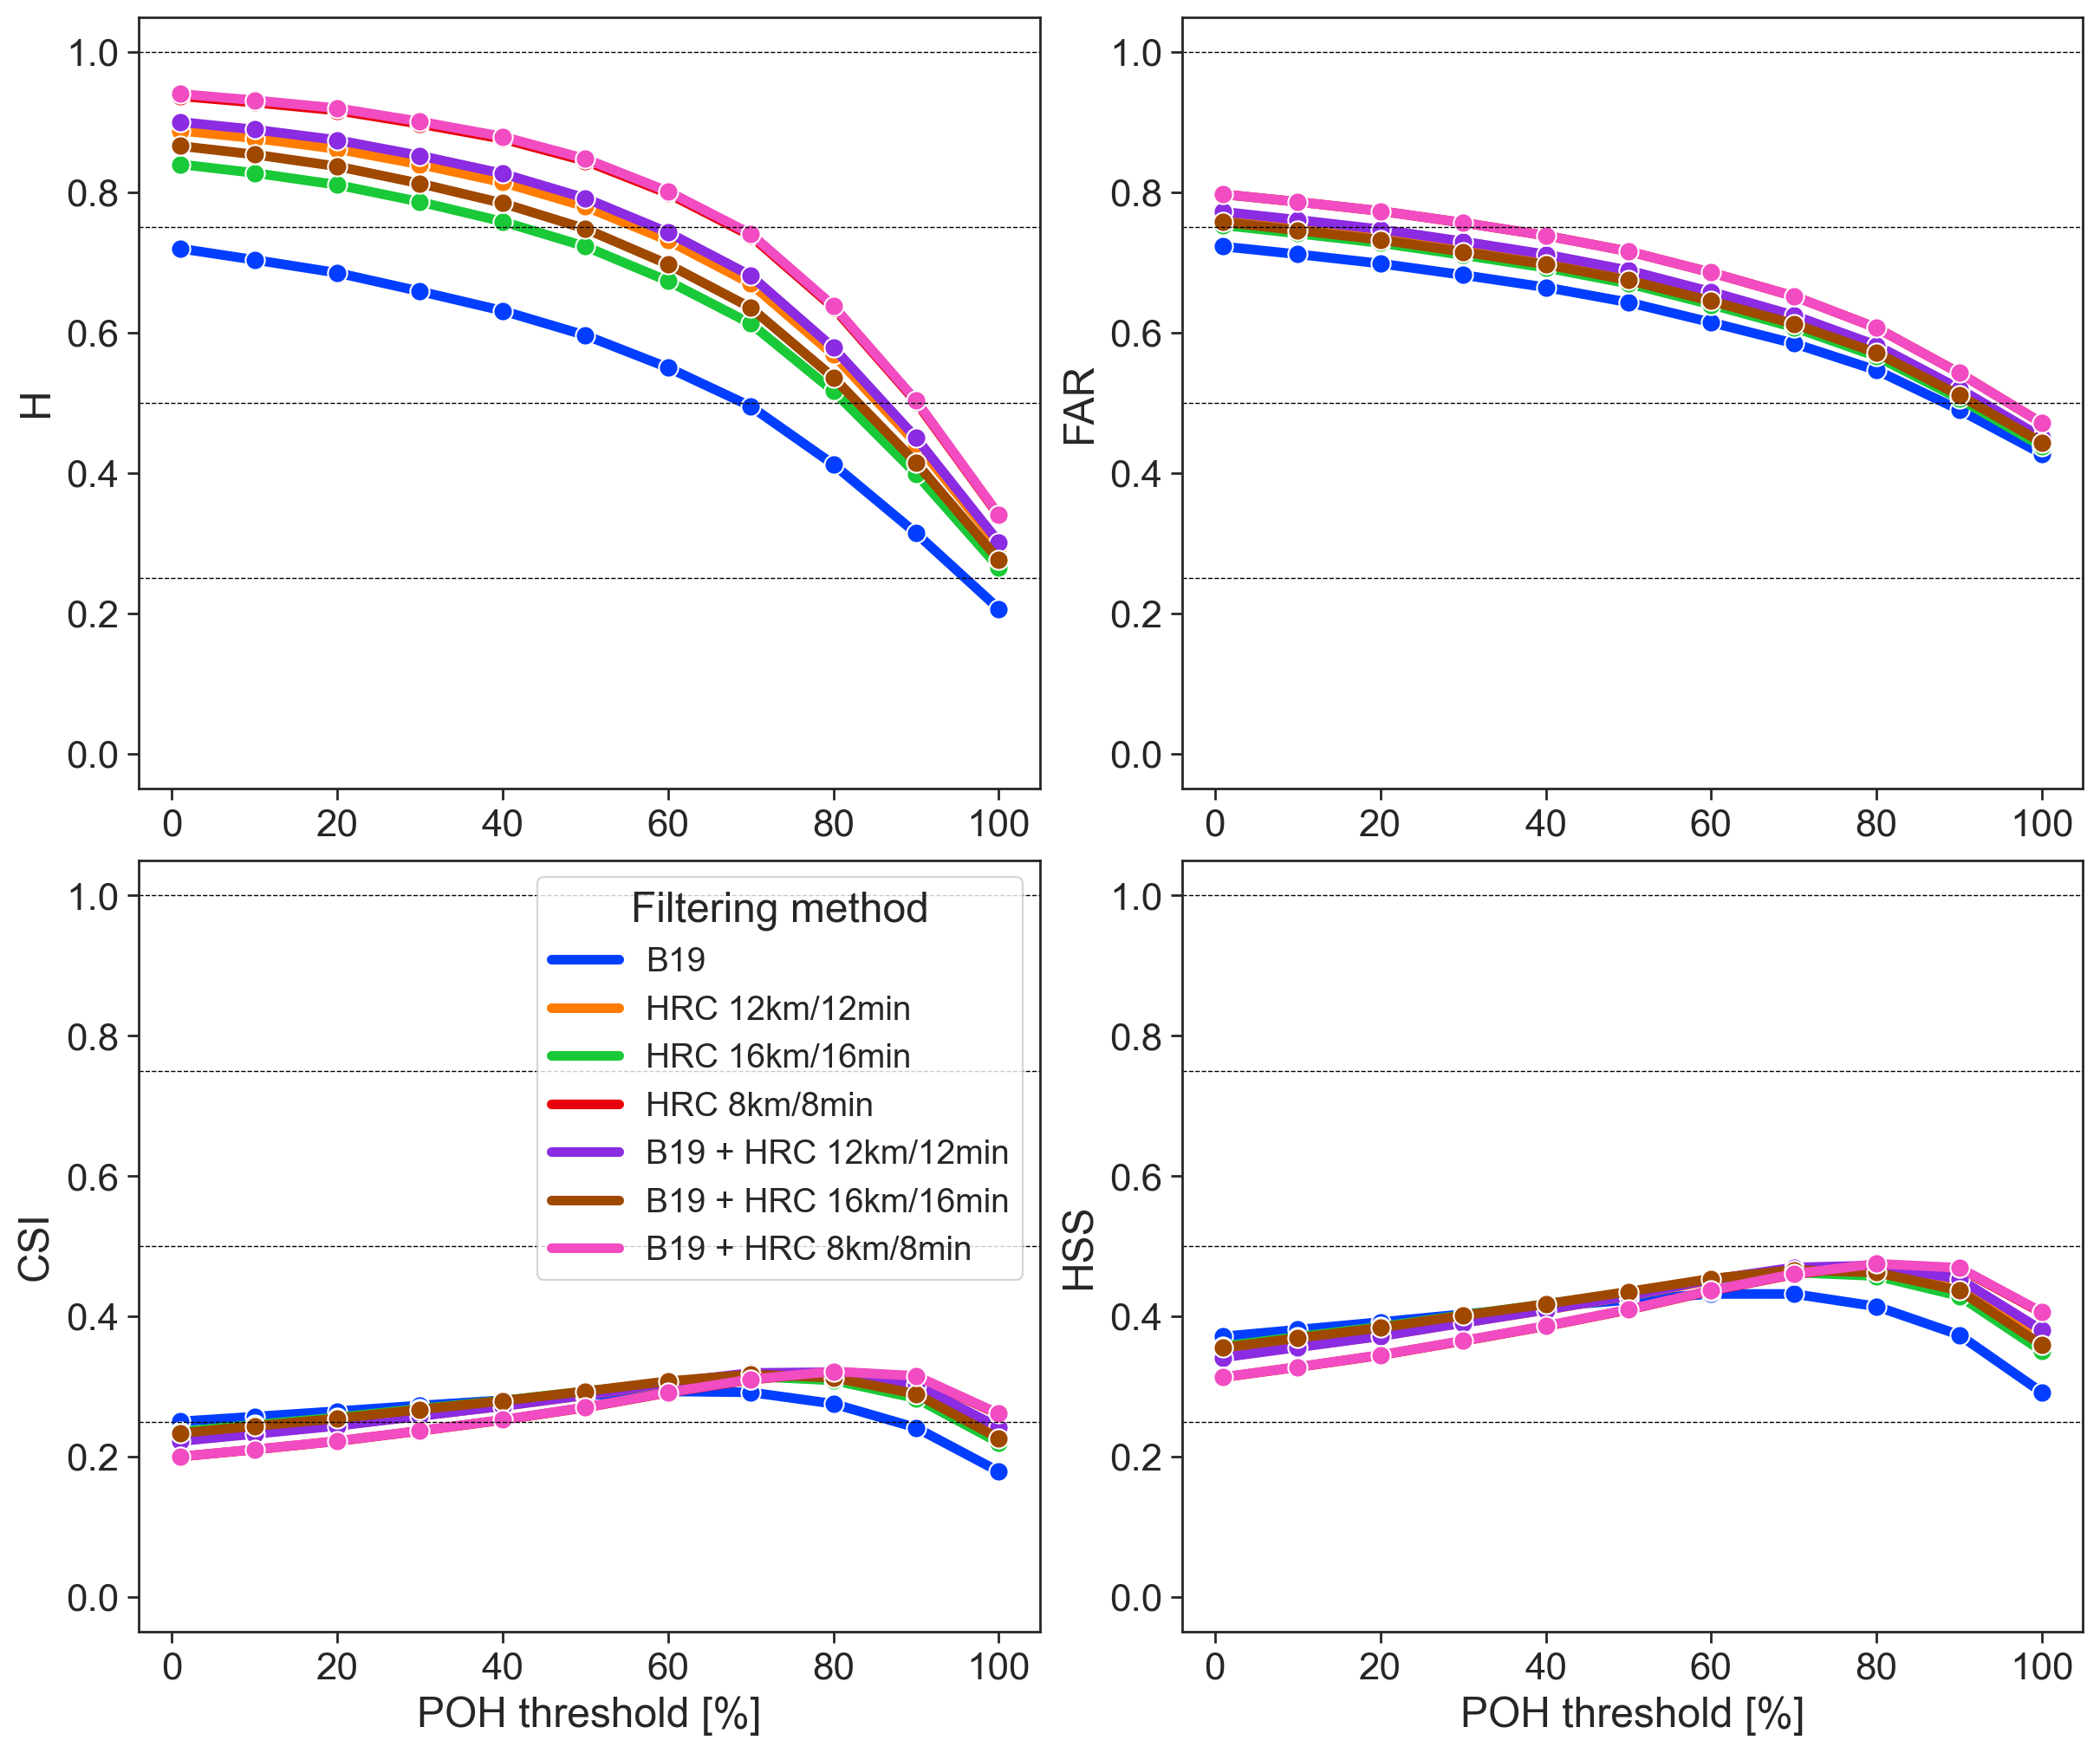

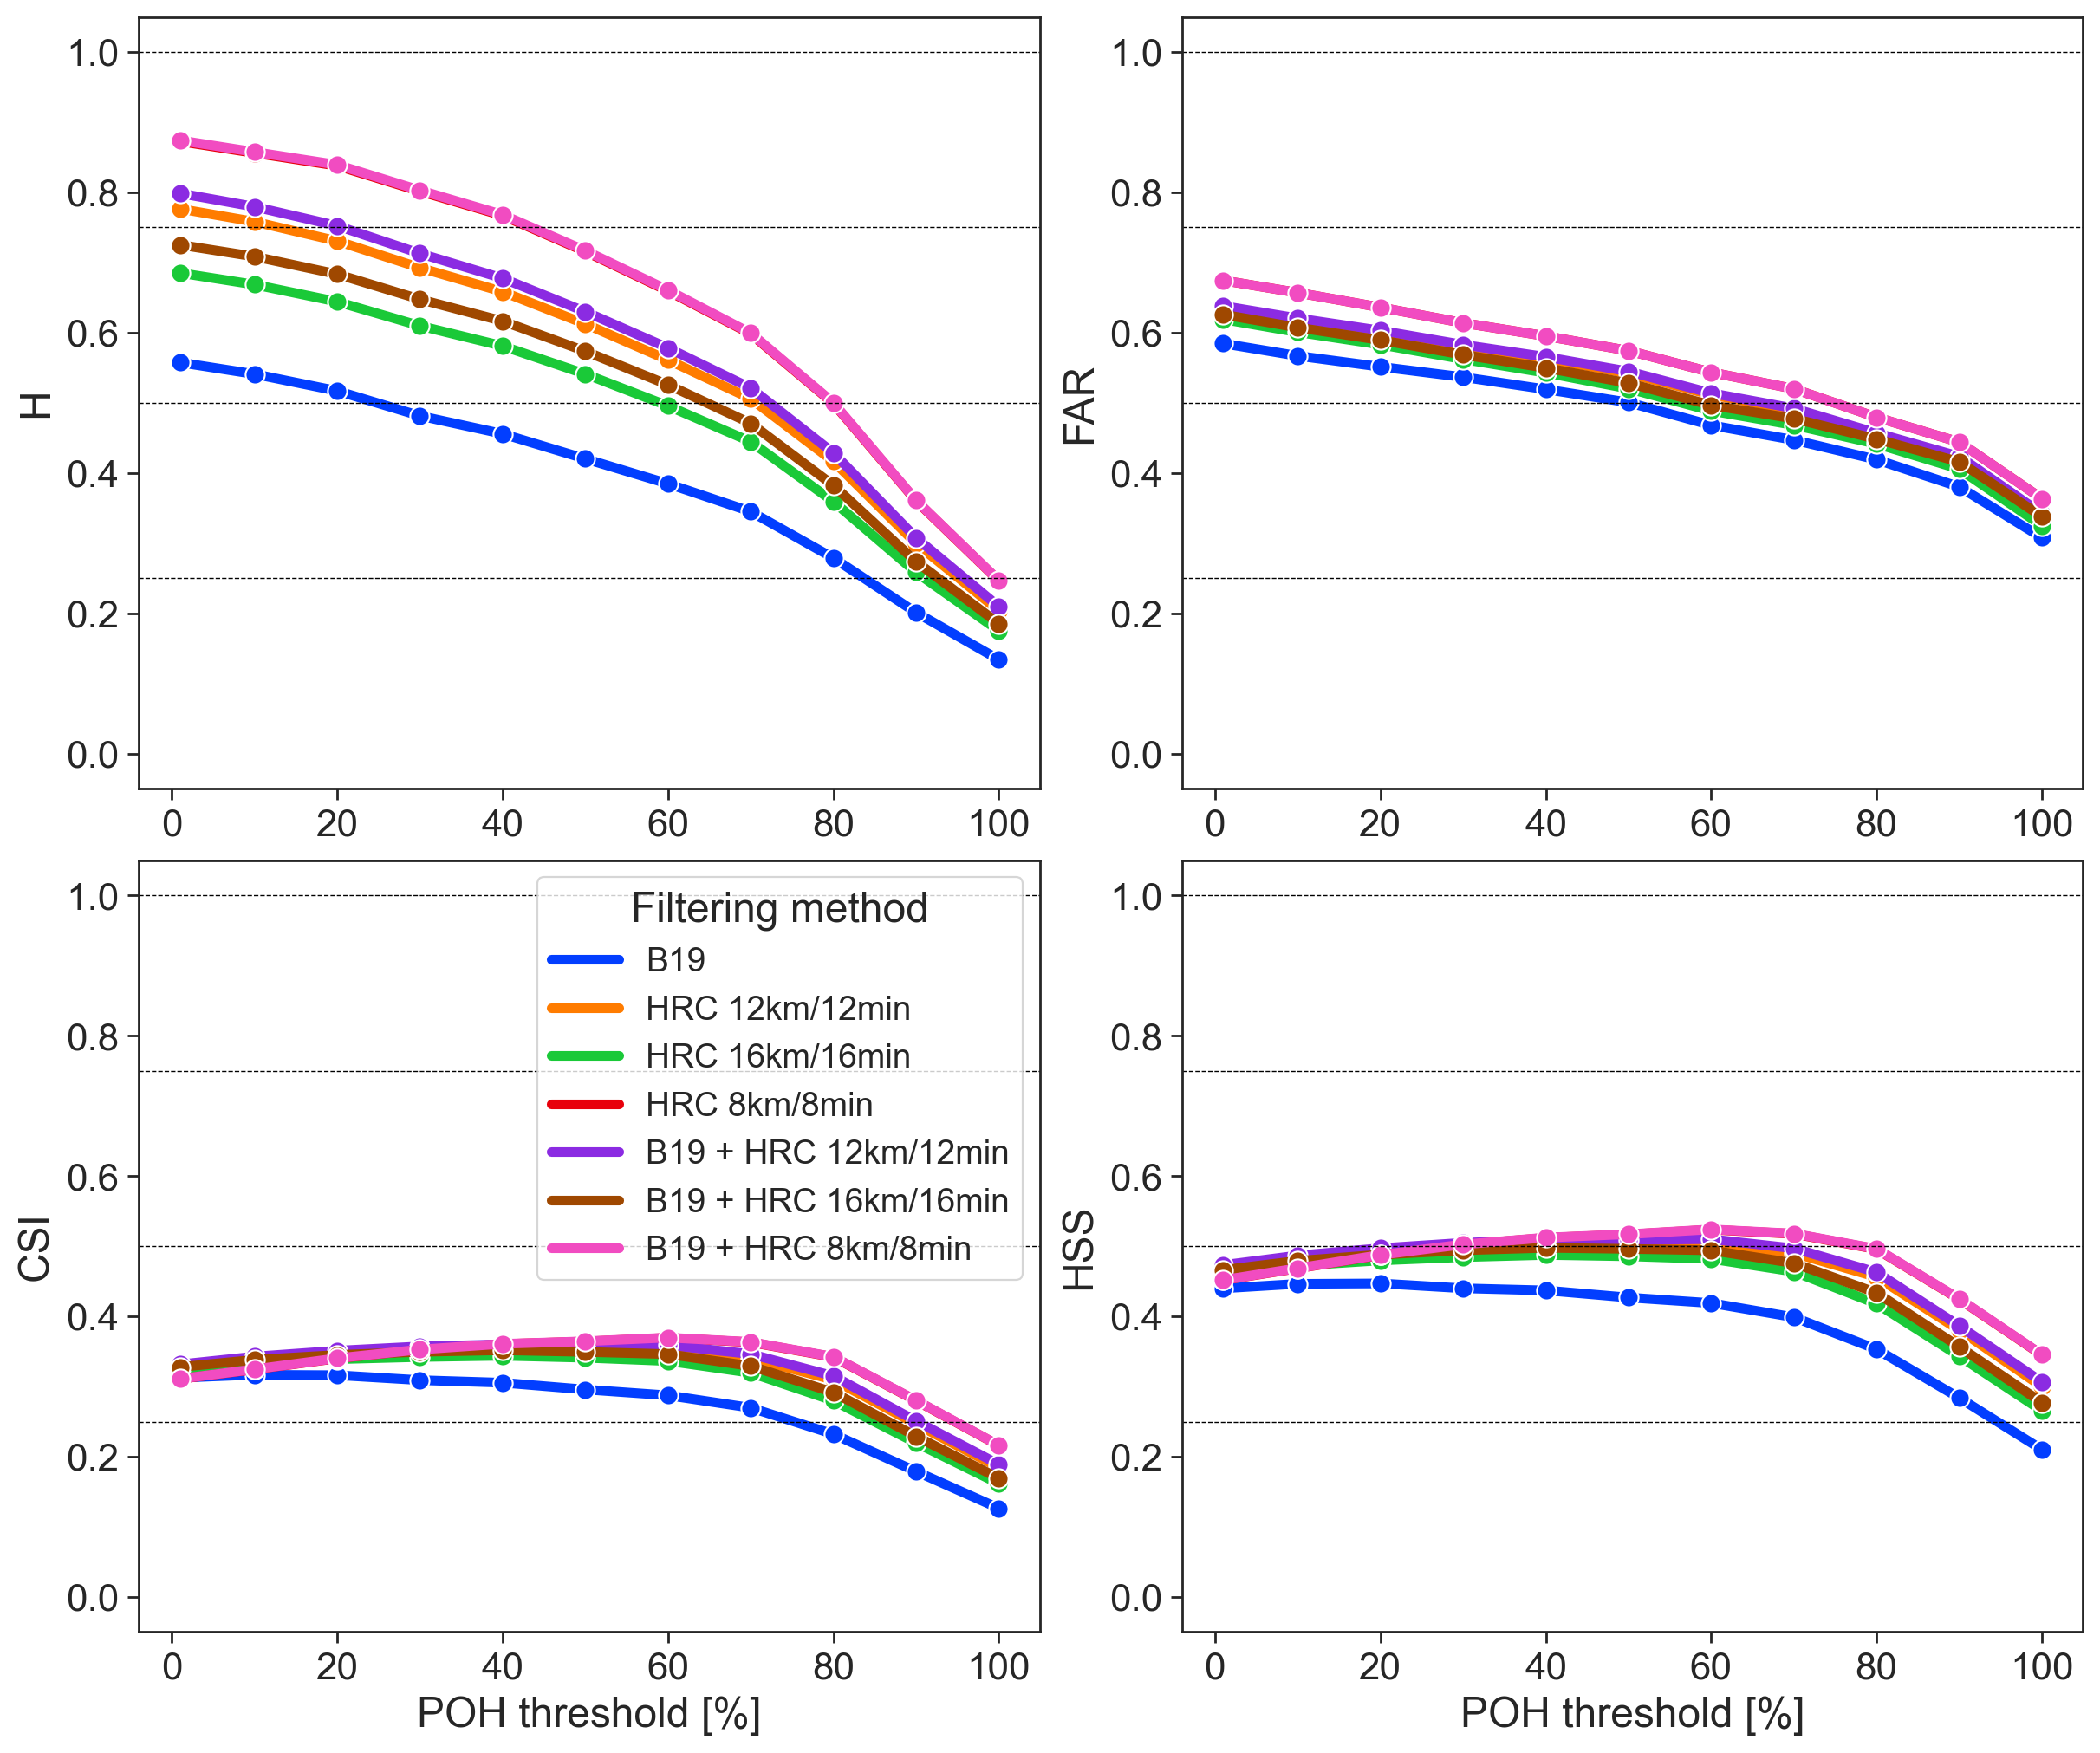

In [116]:
#%%capture
sns.set(style='ticks', context='paper', font_scale=1.8)
seas = 'JJA'
min_date = '2020-08-01'

ncols = 2
nrows = 2

x_val = 'value'
h_val = 'method'
fix_val = 4
st = pd.read_pickle('verifications_final_upscale_allregions.pkl') #verifications_final_new_allregions

st = st.sort_values(by=['method',x_val], ascending=True)

ls_methods = st['method'].unique().tolist()
#ls_methods = ['CZC','clust_CZC_16km_960s','clust_CZC_8km_480s','clust_CZC_12km_720s']

#ls_regions = st['region'].unique().tolist()
ls_regions = ['all100d33_2','ZRH_2']

st = st.loc[(st['min_date'] == min_date) & (st['product'] == 'POH') & (st['season'] == seas)
            & (st['method'].isin(ls_methods)) & (st['distance'] == fix_val)]

for region in ls_regions:
    data = st.loc[(st['region'] == region)]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained',figsize = (12,10),dpi=200)
    sns.lineplot(data=data,ax=axs[0,0],x=x_val, y='H', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[0,1],x=x_val, y='FAR', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    t = sns.lineplot(data=data,ax=axs[1,0],x=x_val, y='CSI', hue=h_val, legend = True, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[1,1],x=x_val, y='HSS', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    
    legend_handles, _= t.get_legend_handles_labels()
    
    labels = ['B19','HRC 12km/12min','HRC 16km/16min','HRC 8km/8min','B19 + HRC 12km/12min','B19 + HRC 16km/16min','B19 + HRC 8km/8min']
    for legobj in legend_handles:
        legobj.set_linewidth(4)
    t.legend(legend_handles, labels, title='Filtering method', prop={'size': 14})
        

    for j in np.arange(0,nrows):
        for i in np.arange(0,ncols):
            axs[j,i].axhline(1, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.75, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.5, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.25, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].set_ylim(-0.05,1.05)
            
            if (j==0):
                axs[j,i].set(xlabel=None)
            if (j==1):
                axs[j,i].xaxis.set_tick_params(labelbottom=True)
                axs[j,i].set(xlabel='POH threshold [%]')

    plt.savefig('plots/method_upscale_%s_%s.png' % (region, fix_val), bbox_inches = 'tight',dpi=200)

### Figures 11 and 20

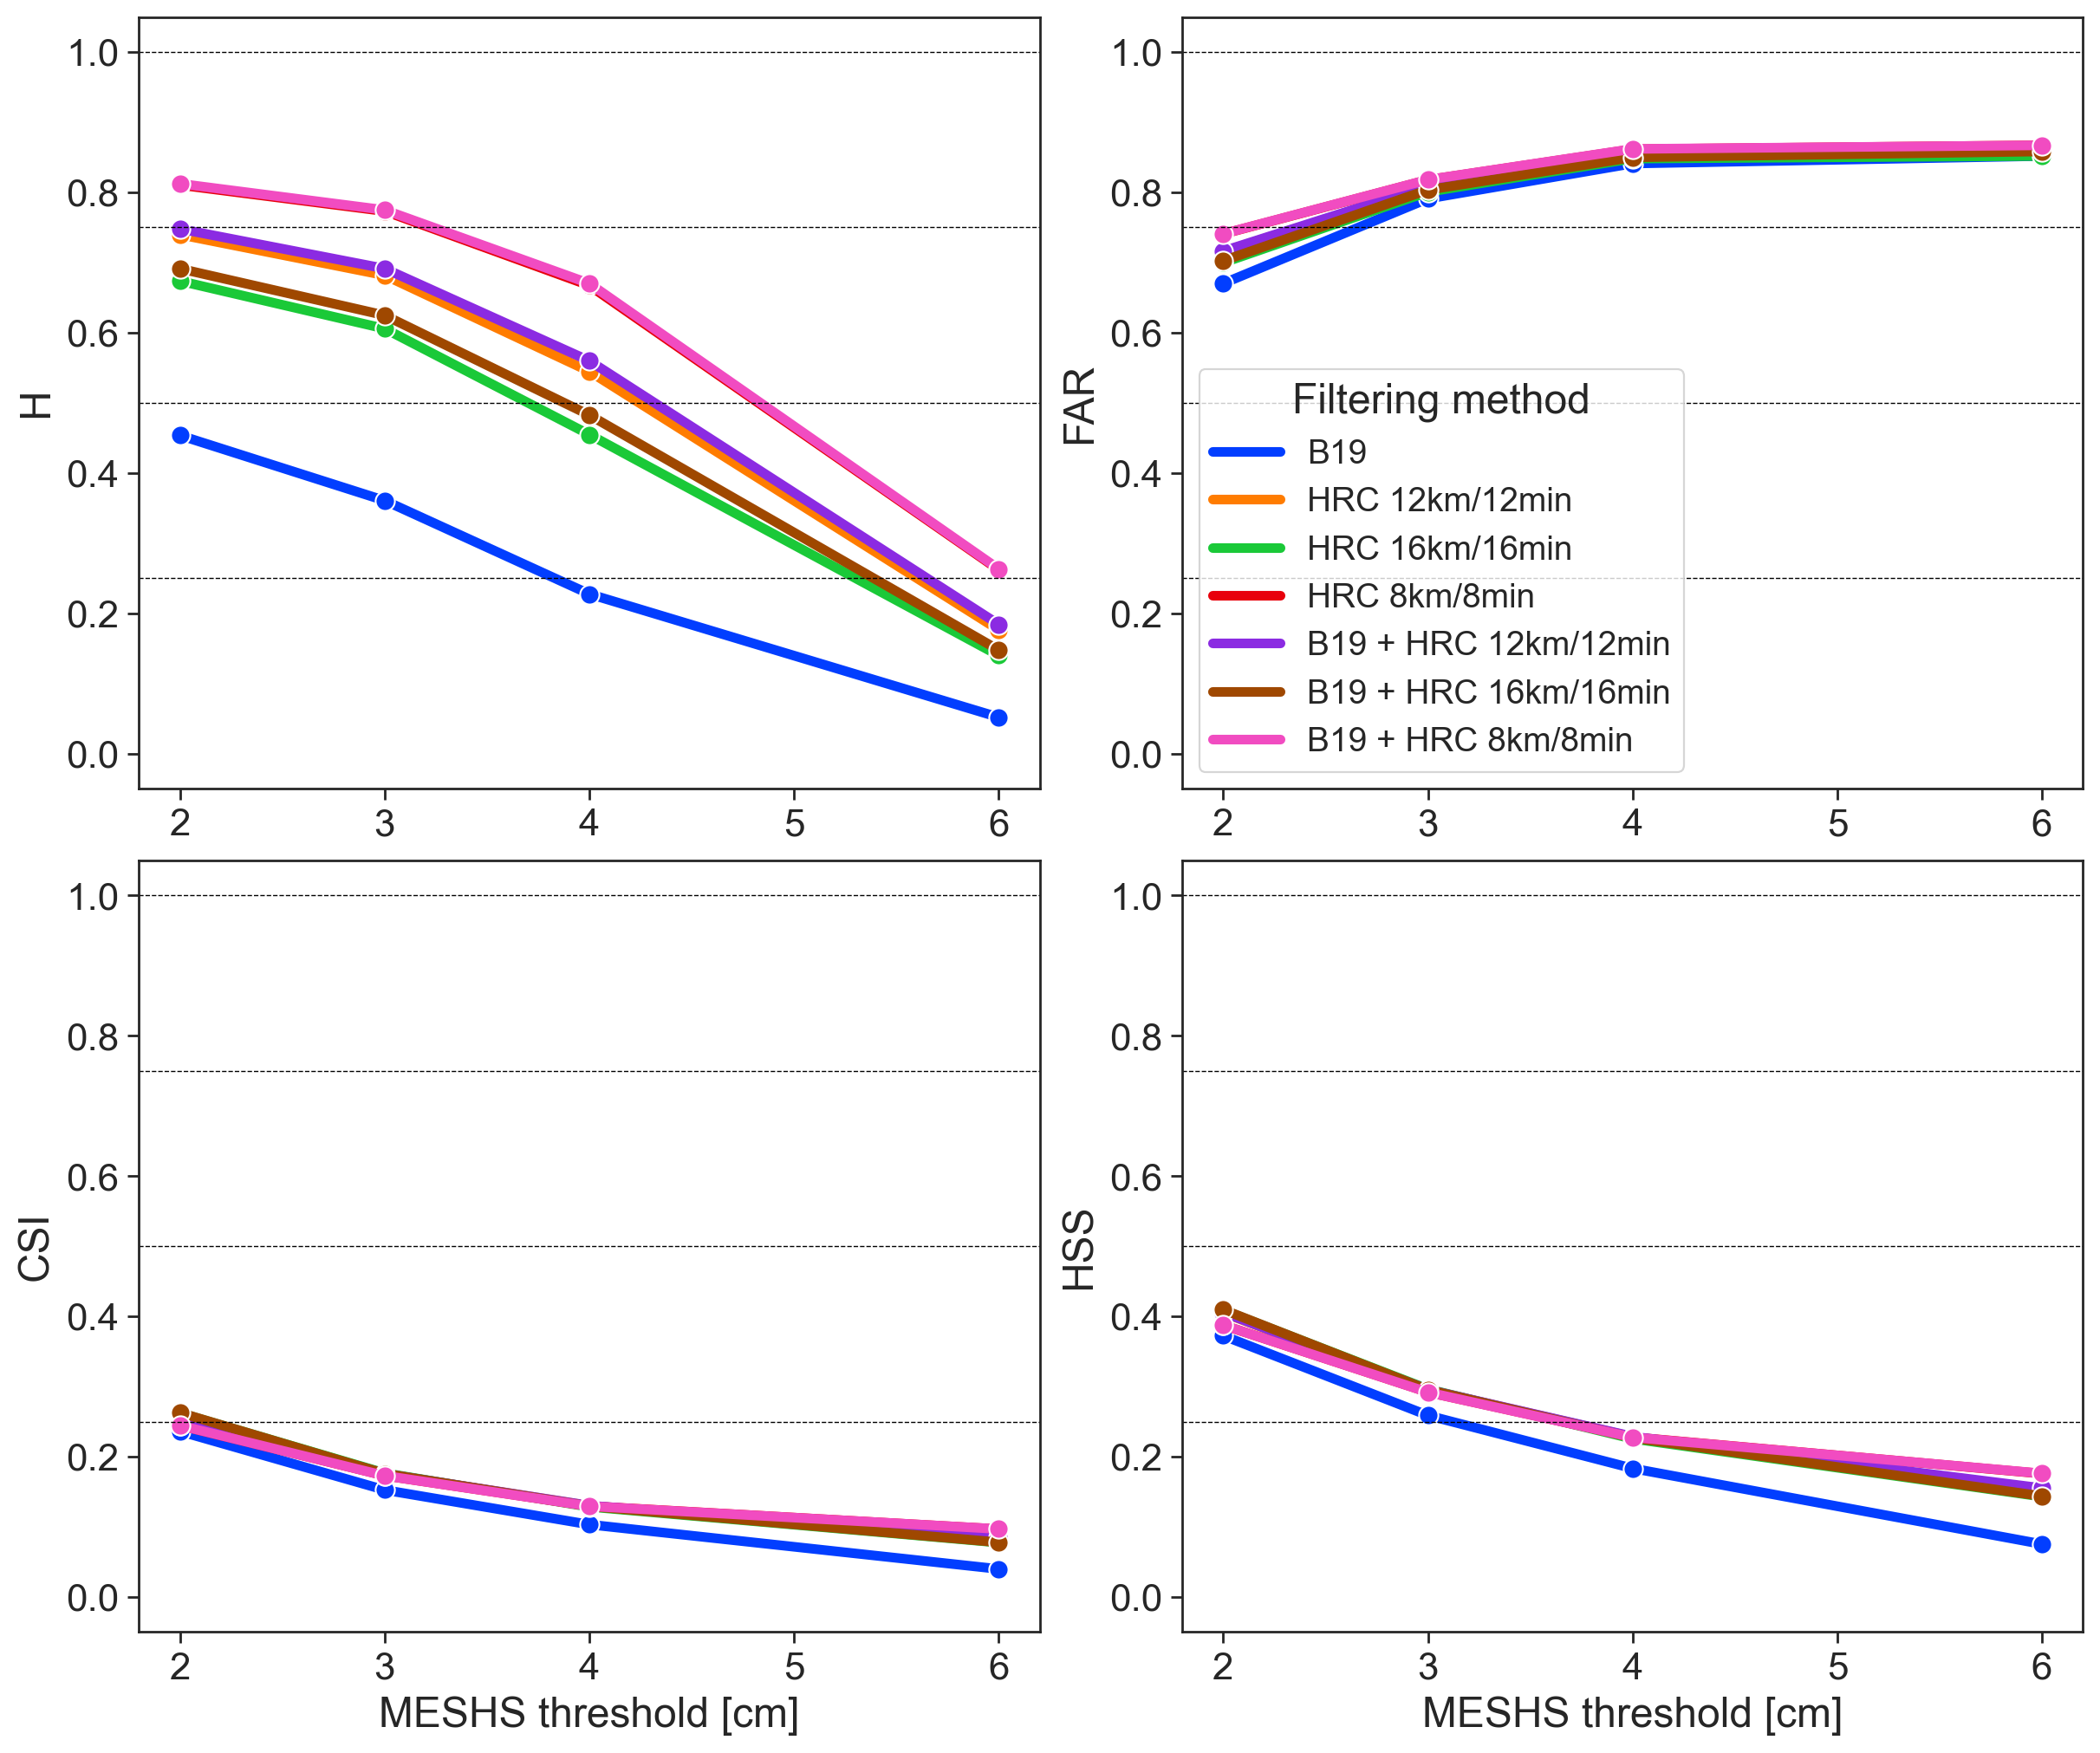

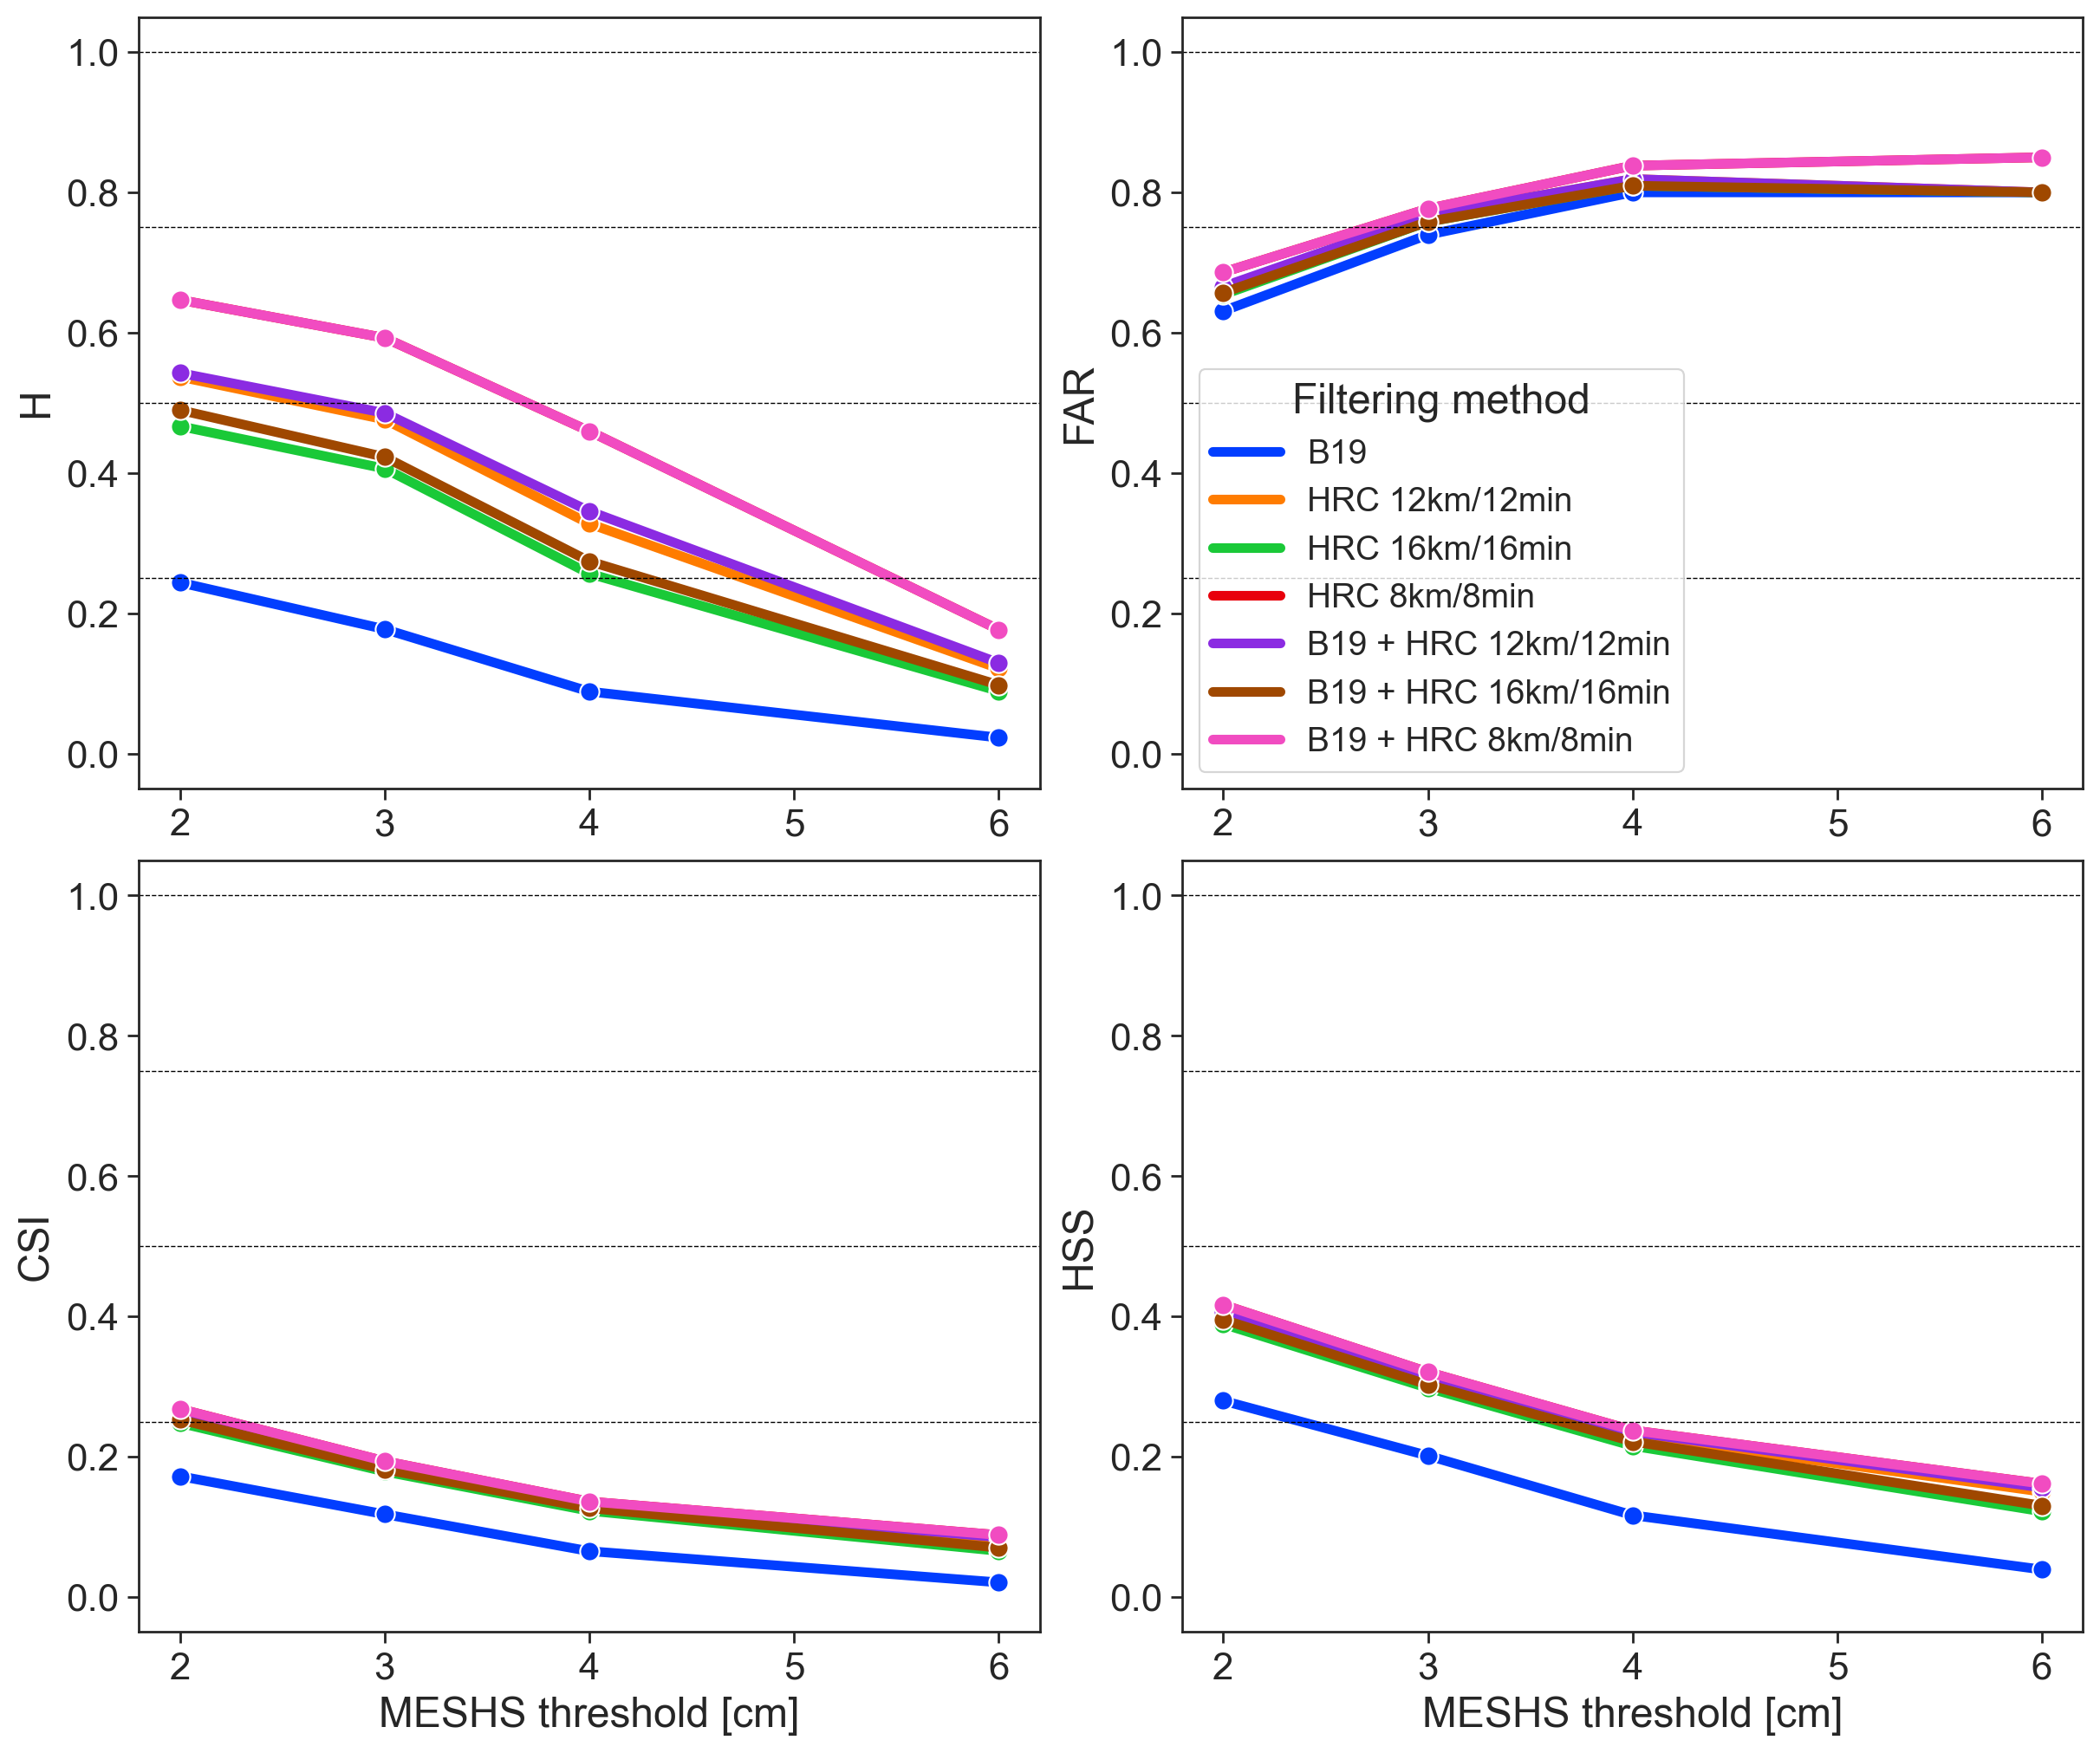

In [78]:
#%%capture
sns.set(style='ticks', context='paper', font_scale=1.8)
seas = 'JJA'
min_date = '2020-08-01'

ncols = 2
nrows = 2

x_val = 'value'
h_val = 'method'
fix_val = 4
st = pd.read_pickle('verifications_final_upscale_allregions.pkl') #verifications_final_new_allregions

st = st.sort_values(by=['method',x_val], ascending=True)

ls_methods = st['method'].unique().tolist()
#ls_methods = ['CZC','clust_CZC_16km_960s','clust_CZC_8km_480s','clust_CZC_12km_720s']

#ls_regions = st['region'].unique().tolist()
ls_regions = ['all100d33_2_large','ZRH_2_large']

st = st.loc[(st['min_date'] == min_date) & (st['product'] == 'MESHS') & (st['season'] == seas)
            & (st['method'].isin(ls_methods)) & (st['distance'] == fix_val)]

for region in ls_regions:
    data = st.loc[(st['region'] == region)]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, layout='constrained',figsize = (12,10),dpi=200)
    sns.lineplot(data=data,ax=axs[0,0],x=x_val, y='H', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    t = sns.lineplot(data=data,ax=axs[0,1],x=x_val, y='FAR', hue=h_val, legend = True, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[1,0],x=x_val, y='CSI', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    sns.lineplot(data=data,ax=axs[1,1],x=x_val, y='HSS', hue=h_val, legend = False, linewidth = 4, marker='o',markersize=8,palette='bright')
    
    legend_handles, _= t.get_legend_handles_labels()
    
    labels = ['B19','HRC 12km/12min','HRC 16km/16min','HRC 8km/8min','B19 + HRC 12km/12min','B19 + HRC 16km/16min','B19 + HRC 8km/8min']
    for legobj in legend_handles:
        legobj.set_linewidth(4)
    t.legend(legend_handles, labels, title='Filtering method', prop={'size': 14})

    for j in np.arange(0,nrows):
        for i in np.arange(0,ncols):
            axs[j,i].axhline(1, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.75, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.5, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].axhline(0.25, color='black', linestyle='dashed', lw=0.5)
            axs[j,i].set_ylim(-0.05,1.05)
            
            if (j==0):
                axs[j,i].set(xlabel=None)
            if (j==1):
                axs[j,i].xaxis.set_tick_params(labelbottom=True)
                axs[j,i].set(xlabel='MESHS threshold [cm]')

    plt.savefig('plots/MESHS_method_upscale_%s_%s.png' % (region, fix_val), bbox_inches = 'tight',dpi=200)

# Fraction of matches between POH and automatic hail sensor data (Appendix C)

In [75]:
min_D = 5
t_mb = 600
HIT_TH = 2
HIT_TH_UP = 1000
SENSOR_SURFACE = 0.25**2 * np.pi # sensor surface in m2
SENSOR_SURFACE_KM = SENSOR_SURFACE * 10**-6

sensors_filtered = make_sensors_filtered(sensor_data, 'maxCZC_ts_r0', -35)
sensors_filtered = sensors_filtered.loc[(sensors_filtered['diameter']>=min_D) & (sensors_filtered['Flag_CZC']==0)]
sensors_data = make_sensors_data(sensors_filtered, t_mb)
hail_events_full = make_hail_events_full(sensors_data)
hail_events_sel, sensors_ev_sel = make_sensors_sel(hail_events_full, sensors_data, HIT_TH, HIT_TH_UP)

C:\Users\Jérôme\AppData\Local\Temp\ipykernel_7864\153053336.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hail_events = data.groupby('Event_ID')['Event_hits','Event_hits_group','Event_count','Event_hits_adj2','Event_duration','Event_D_max','Event_D_mean','daily_count_by_sensor',


In [76]:
len(sensors_ev_sel.loc[sensors_ev_sel['season_name']=='JJA'])

11480

In [77]:
len(hail_events_sel.loc[hail_events_sel['season_name']=='JJA'])

608

In [53]:
pd.pivot_table(hail_events_sel.loc[hail_events_sel['season_name']=='JJA'], values='Event_hits', columns='Event_hits_group',
                          aggfunc='count').fillna(0)#.apply(lambda x: round(x/sum(x),2))

Event_hits_group  2-5 impacts  6-25 impacts  > 25 impacts
Event_hits                358           137           113

In [88]:
pd.pivot_table(hail_events_sel, values='Event_hits', index='Event_Flag_BZC_D', columns='Event_hits_group',
                          aggfunc='count').fillna(0).apply(lambda x: round(x/sum(x),2))

Event_hits_group  2-5 impacts  6-25 impacts  > 25 impacts
Event_Flag_BZC_D                                         
0.000000                 0.50          0.83          0.99
0.200000                 0.00          0.00          0.00
0.250000                 0.00          0.00          0.00
0.285714                 0.00          0.01          0.00
0.333333                 0.00          0.01          0.01
0.500000                 0.03          0.00          0.00
0.666667                 0.01          0.01          0.00
0.750000                 0.00          0.00          0.00
1.000000                 0.46          0.15          0.00

In [81]:
t = hail_events_sel.loc[hail_events_sel['season_name']=='JJA']
len(t.loc[(t['Event_hits_group'] == '2-5 impacts') & (t['Event_hits'] == 2)])

205

# Spatio-temporal clustering using ST-DBSCAN library

## Create areas

### Create shapefile masks from numpy arrays

In [45]:
region = 'all100d33'
from PIL import Image
pop_mask = np.load('%s_area_mask_extend.npy' % (region))
t = pop_mask.copy() * 255
n = np.flipud(t)
#n = t
img = Image.fromarray(n)
img = img.convert("L")
img.save('%s_area_mask_extend.tif' % (region))

In [92]:
from osgeo import gdal, ogr, osr
raster = gdal.Open('%s_area_mask_extend.tif' % (region))
band = raster.GetRasterBand(1)


shp_proj = osr.SpatialReference()
proj = raster.GetProjection()
shp_proj.ImportFromWkt(proj)

output_file = '%s_area_mask_extend.shp' % (region)
call_drive = ogr.GetDriverByName('ESRI Shapefile')
create_shp = call_drive.CreateDataSource(output_file)
shp_layer = create_shp.CreateLayer('layername', srs = shp_proj)
new_field = ogr.FieldDefn(str('ID'), ogr.OFTInteger)
shp_layer.CreateField(new_field)
dst_field = shp_layer.GetLayerDefn().GetFieldIndex("ID_1")

gdal.Polygonize(band, None, shp_layer, dst_field , [], callback=None)
del create_shp
del raster

### Swiss100 area

In [62]:
output_file = 'all100d33_area_mask_extend.shp'
regions = gpd.read_file(output_file)
mask = ((regions.area > 200) & (regions.area < 100000))
all100d33_area_temp = regions.loc[mask]
ind_list = [0,2,3]
all100d33_area = all100d33_area_temp.iloc[ind_list].reset_index().drop(columns=['ID'])

### ZRH area

In [3]:
output_file = 'ZRH_area_mask_extend.shp'
ZRH_area = gpd.read_file(output_file)
ZRH_area = ZRH_area.drop([1])

## Data preparation

In [295]:
# Transform reports coordinates into geopandas points
gdf2 = gpd.GeoDataFrame(reports[['ID','x','y','Time','size','hour']], geometry=gpd.points_from_xy(reports.x_1000m/1000 - 255, reports.y_1000m/1000 + 160))

# Select reports only within area
points_within = gpd.sjoin(gdf2, all100d33_area, predicate='within')

In [297]:
#points_within = points_within.loc[points_within['size'].isin([12,13,14,15,16])]
pts = points_within[['ID','x','y','Time','size','hour']]
#pts = points_within[['ID_left','x','y','Time','size', 'hour']]
#pts = pts.rename(columns={'ID_left': 'ID'})

In [298]:
df_filt = reports.merge(pts, on=["x","y","Time",'ID','size'], how='left', indicator=True)
df = df_filt.loc[(df_filt['_merge'] == 'both') & (df_filt['Time_only'] >= datetime.time(6,0)) & (df_filt['Time_only'] <= datetime.time(21,15))]
#df = df[['ID','x','y','Time','size','year']]

In [300]:
years = df['year'].unique().tolist()

df_dict = {elem : pd.DataFrame() for elem in years}

for key in df_dict.keys():
    df_dict[key] = df[:][df.year == key]

In [302]:
list_eps_d = [8,12,16]
list_min_s = [5]
list_eps_t = [480,720,960]
area = 'all100d33_2' #ZRH_2
n_ = ['','_large']

## Create spatio-temporal clusters

In [ ]:
#stats = []
path = 'C:\\Users\Jérôme\Documents\PhD\Crowdsourced data\\analysis\clusters\\'

size_all = df['size'].unique().tolist()
df = df[['ID','x','y','Time','size','year']]
    
for n in n_:
    name = area + n
    if n == '_nomin':
        sizes = [12,13,14,15,16]
    if n == '_large':
        sizes = [13,14,15,16]
    if n == '':
        sizes = size_all
    temp = df.loc[df['size'].isin(sizes)]
    
    years = temp['year'].unique().tolist()

    df_dict = {elem : pd.DataFrame() for elem in years}

    for key in df_dict.keys():
        df_dict[key] = temp[:][temp.year == key]
    
    for year in years:
        data = df_dict[year]
        data['x_km'] = data['x']/1000
        data['y_km'] = data['y']/1000
        data['Time_int'] = data['Time'].astype('int64')/10**9 #time in seconds
        data['Time_int'] = data['Time_int'] - data['Time_int'].min()
        X_temp = data[['x_km','y_km','Time_int']].copy()
        cols = X_temp.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        X_temp = X_temp[cols]
        X = X_temp.to_numpy(copy=True)

        for eps_d, eps_t in zip(list_eps_d,list_eps_t):
                for min_s in list_min_s:
                    t0 = time.time()
                    st_dbscan = ST_DBSCAN(eps1 = eps_d, eps2 = eps_t, min_samples = min_s) # eps1 = distance in km, eps2 = time in seconds, min_samples = min number of reports to create cluster
                    st_dbscan.fit(X)
                    labels = st_dbscan.labels
                    X_temp['labels'] = labels
                    n = len(set(labels))

                    # Number of clusters in labels, ignoring noise if present.
                    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
                    n_noise_ = list(labels).count(-1)
                    t1 = time.time()
                    total = t1-t0
                    print("Total time: %f" % total)
                    crowd_clust = pd.merge(data, X_temp, how='left', on=["x_km","y_km","Time_int"])
                    crowd_clust.to_pickle(path + 'st_dbscan_%s_%s_%skm_%ss_%sc.pkl' % (year, name, eps_d, eps_t, min_s))
                    #stats.append({'year': year, 'eps_t': eps_t, 'eps_d': eps_d, 'min_size': min_s, 'n_clusters': n_clusters_, 'n_noise': n_noise_, 'time': total})
            
# st = pd.DataFrame.from_dict(stats)
# st.to_csv('st_dbscan_%s_stats.csv' % (area))

Total time: 0.004999
Total time: 0.001000
Total time: 0.000999
Total time: 0.004001
Total time: 0.003000
Total time: 0.002084
Total time: 0.011008
Total time: 0.010004
Total time: 0.009000
Total time: 0.013129
Total time: 0.007998
Total time: 0.008012
Total time: 0.003184
Total time: 0.003002
Total time: 0.002995
Total time: 0.031862
Total time: 0.046226
Total time: 0.040000
Total time: 0.337163
Total time: 0.270608
Total time: 0.286478
Total time: 0.148862
Total time: 0.170788
Total time: 0.127699
Total time: 0.155040
Total time: 0.142937
Total time: 0.146972
Total time: 0.001000
Total time: 0.000000
Total time: 0.001001
Total time: 0.004000
Total time: 0.004001
Total time: 0.004000
Total time: 0.003016
Total time: 0.002002
Total time: 0.002321
Total time: 0.014001
Total time: 0.014084
Total time: 0.011501
Total time: 0.169427
Total time: 0.166700
Total time: 0.182467
Total time: 0.078002
Total time: 0.077024
Total time: 0.080257
Total time: 0.086248
Total time: 0.090298
Total time: 0

In [305]:
path = 'C:\\Users\Jérôme\Documents\PhD\Crowdsourced data\\analysis\clusters\\'

for n in n_:
    name = area + n
    for eps_d, eps_t in zip(list_eps_d,list_eps_t):
        for min_s in list_min_s:
            data = {}
            for file in os.listdir(path):
                 if file.endswith('%s_%skm_%ss_%sc.pkl' % (name, eps_d, eps_t, min_s)):
                    with open(path+file, 'rb') as f:
                        data[file] = pd.read_pickle(f)

            temp = pd.concat(data.values(), ignore_index=True).drop_duplicates()
            temp.to_pickle('st_dbscan_%s_%skm_%ss_%sc.pkl' % (name, eps_d, eps_t, min_s))

## Merge clusters data back with reports data

In [306]:
for n in n_:
    name = area + n
    for eps_d, eps_t in zip(list_eps_d,list_eps_t):
        clusters = pd.read_pickle('st_dbscan_%s_%skm_%ss_5c.pkl' % (name,eps_d,eps_t))
        clusters['Time'] = pd.to_datetime(clusters['Time'], format='%Y-%m-%d %H:%M:%S')
        clusters['clust_no'] = 0
        clusters.loc[clusters['labels'] == -1,'clust_no'] = 1
        tot = pd.merge(reports, clusters, how='inner', on=["x","y","Time",'ID','size'])
        tot.to_pickle('crowdsourced_data_%s_%skm_%ss_5c.pkl' % (name,eps_d,eps_t))

## Illustration of spatio-temporal clustering for 20 June 2021

In [37]:
clusters = pd.read_pickle('st_dbscan_all100d33_2_12km_720s_5c.pkl')
clusters['Time'] = pd.to_datetime(clusters['Time'], format='%Y-%m-%d %H:%M:%S')
clusters['clust_no'] = 0
clusters.loc[clusters['labels'] == -1,'clust_no'] = 1

date_plot = '2021-06-20'
data = tot.loc[(tot['day']=='2021-06-20') & (tot['Time_only'] >= datetime.time(6,0)) & (tot['Time_only'] <= datetime.time(21,15))]

data['cat'] = 'None'
data.loc[(data['clust_no'] == 0) & (data['Flag_CZC'] == 0),'cat'] = 'Both'
data.loc[(data['clust_no'] == 0) & (data['Flag_CZC'] == 1),'cat'] = 'HRC'
data.loc[(data['clust_no'] == 1) & (data['Flag_CZC'] == 0),'cat'] = 'B19'

data['cat2'] = 'noBZC_noClust'
data.loc[(data['clust_no'] == 0) & (data['Flag_BZC_B'] == 0),'cat2'] = 'yesBZC_yesClust'
data.loc[(data['clust_no'] == 0) & (data['Flag_BZC_B'] == 1),'cat2'] = 'noBZC_yesClust'
data.loc[(data['clust_no'] == 1) & (data['Flag_BZC_B'] == 0),'cat2'] = 'yesBZC_noClust'

FileNotFoundError: [Errno 2] No such file or directory: 'crowdsourced_data_all100d33_2_12km_720s_5c'

In [63]:
pd.crosstab(data['Flag_CZC'],data['clust_no'])

clust_no     0    1
Flag_CZC           
0         3410   73
1          246  435

In [67]:
len(data)

4164

Estimated number of clusters: 16
Estimated number of noise points: 719


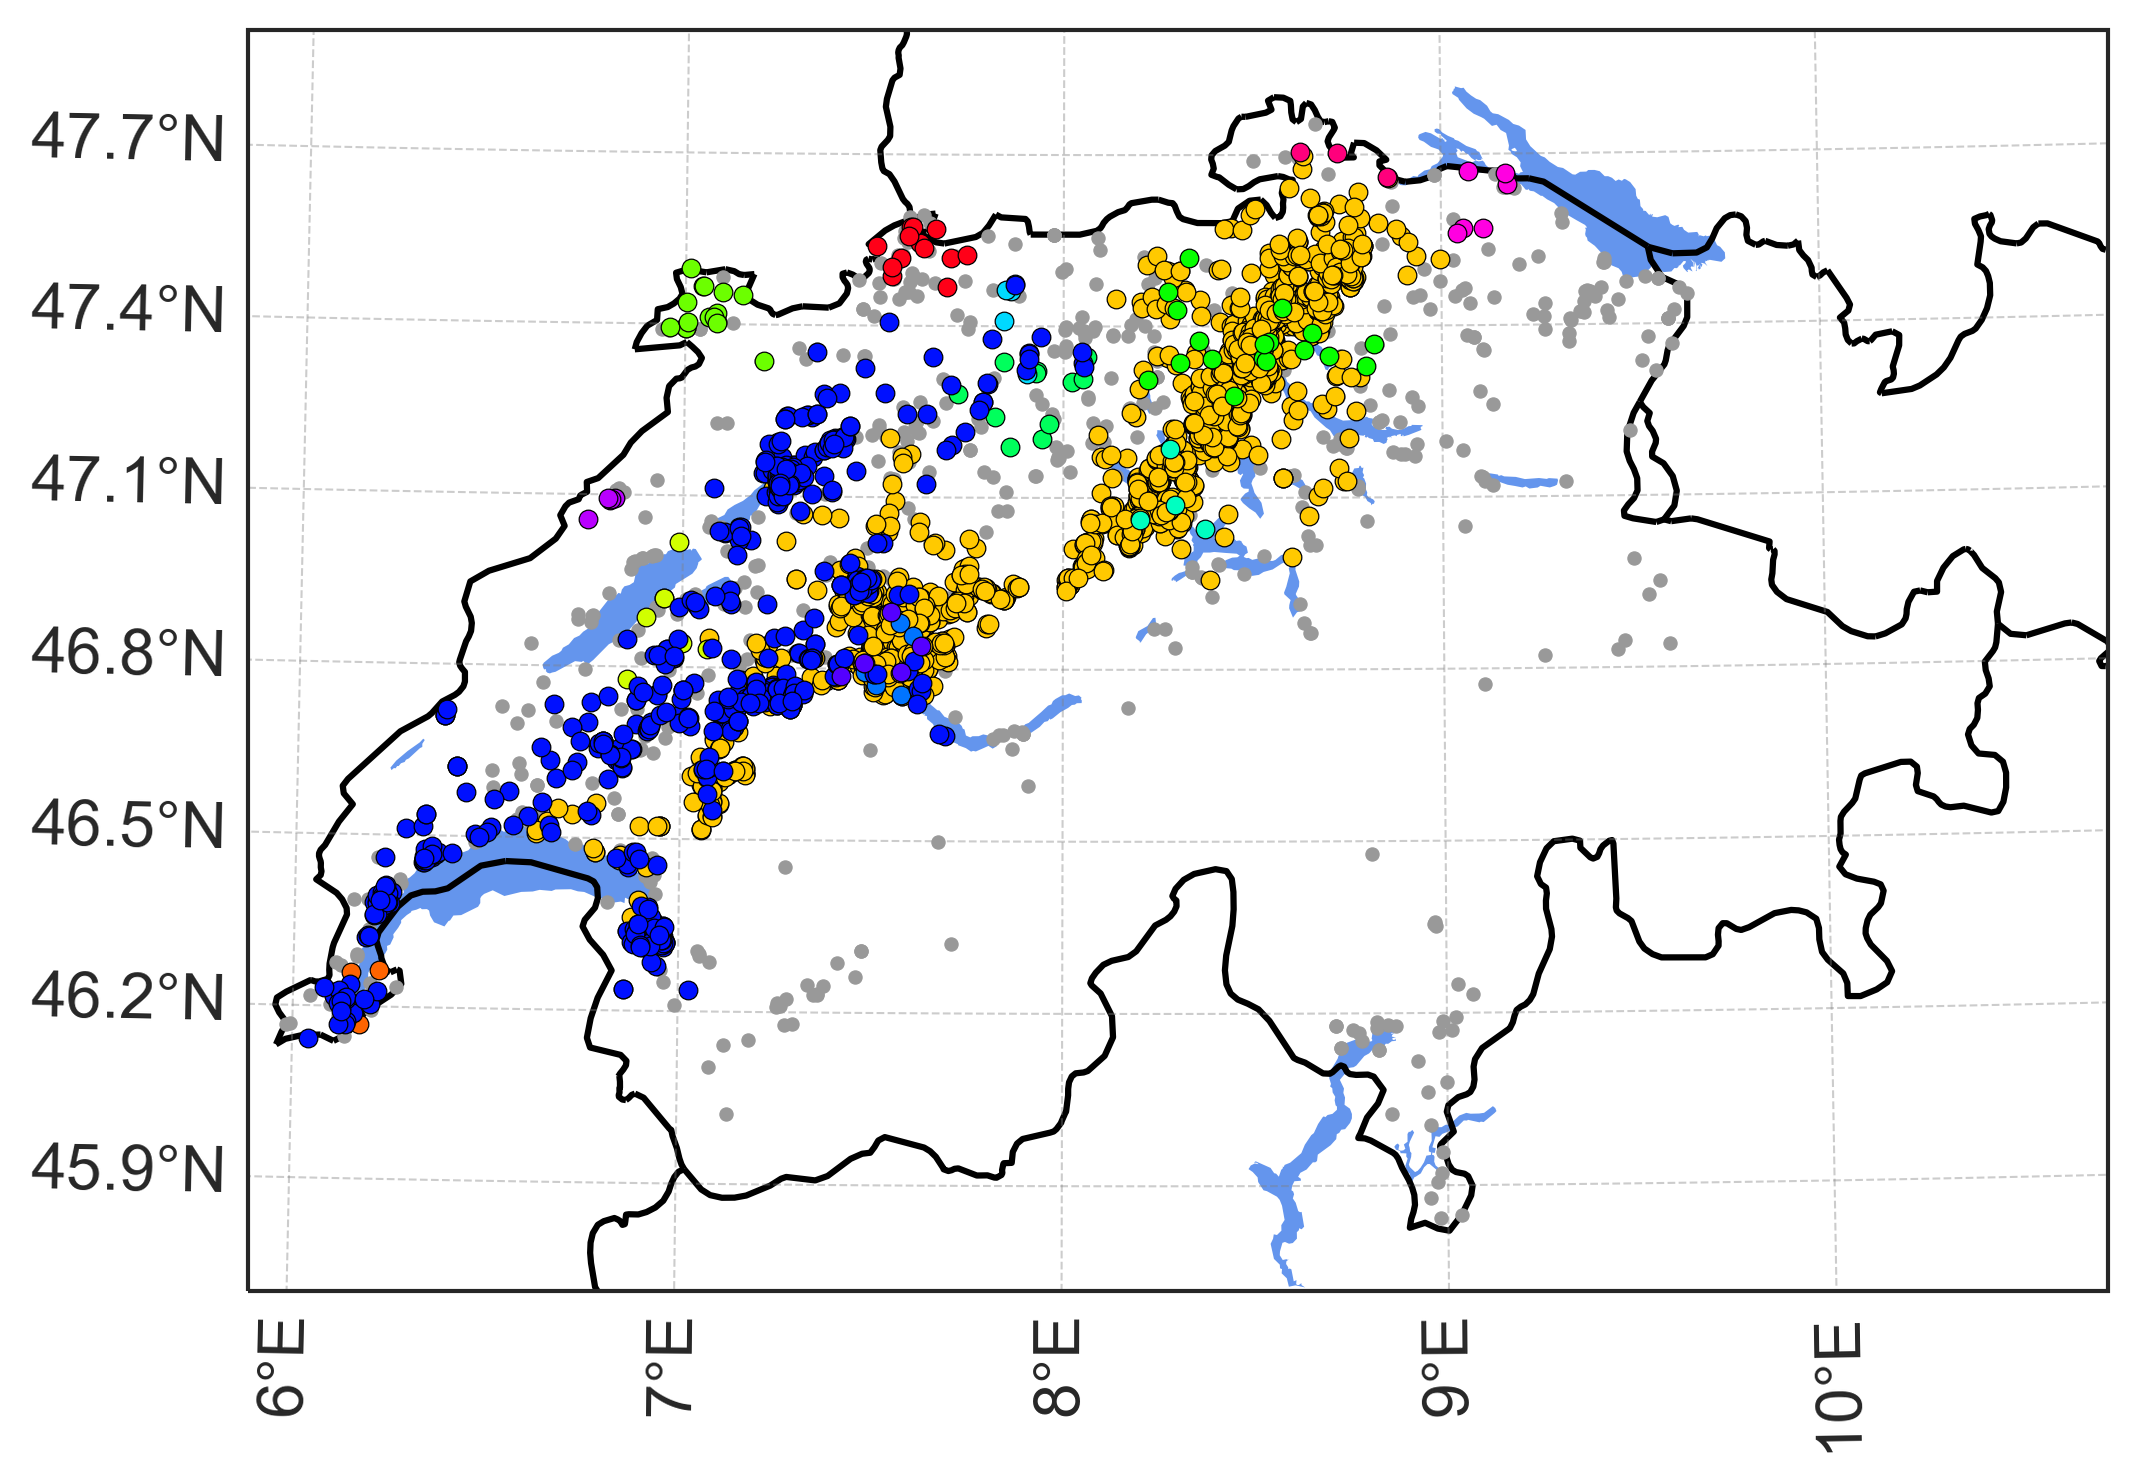

In [54]:
labels = data['labels']
cmap = get_cmap(len(labels.unique()))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
plot_clusters(data);

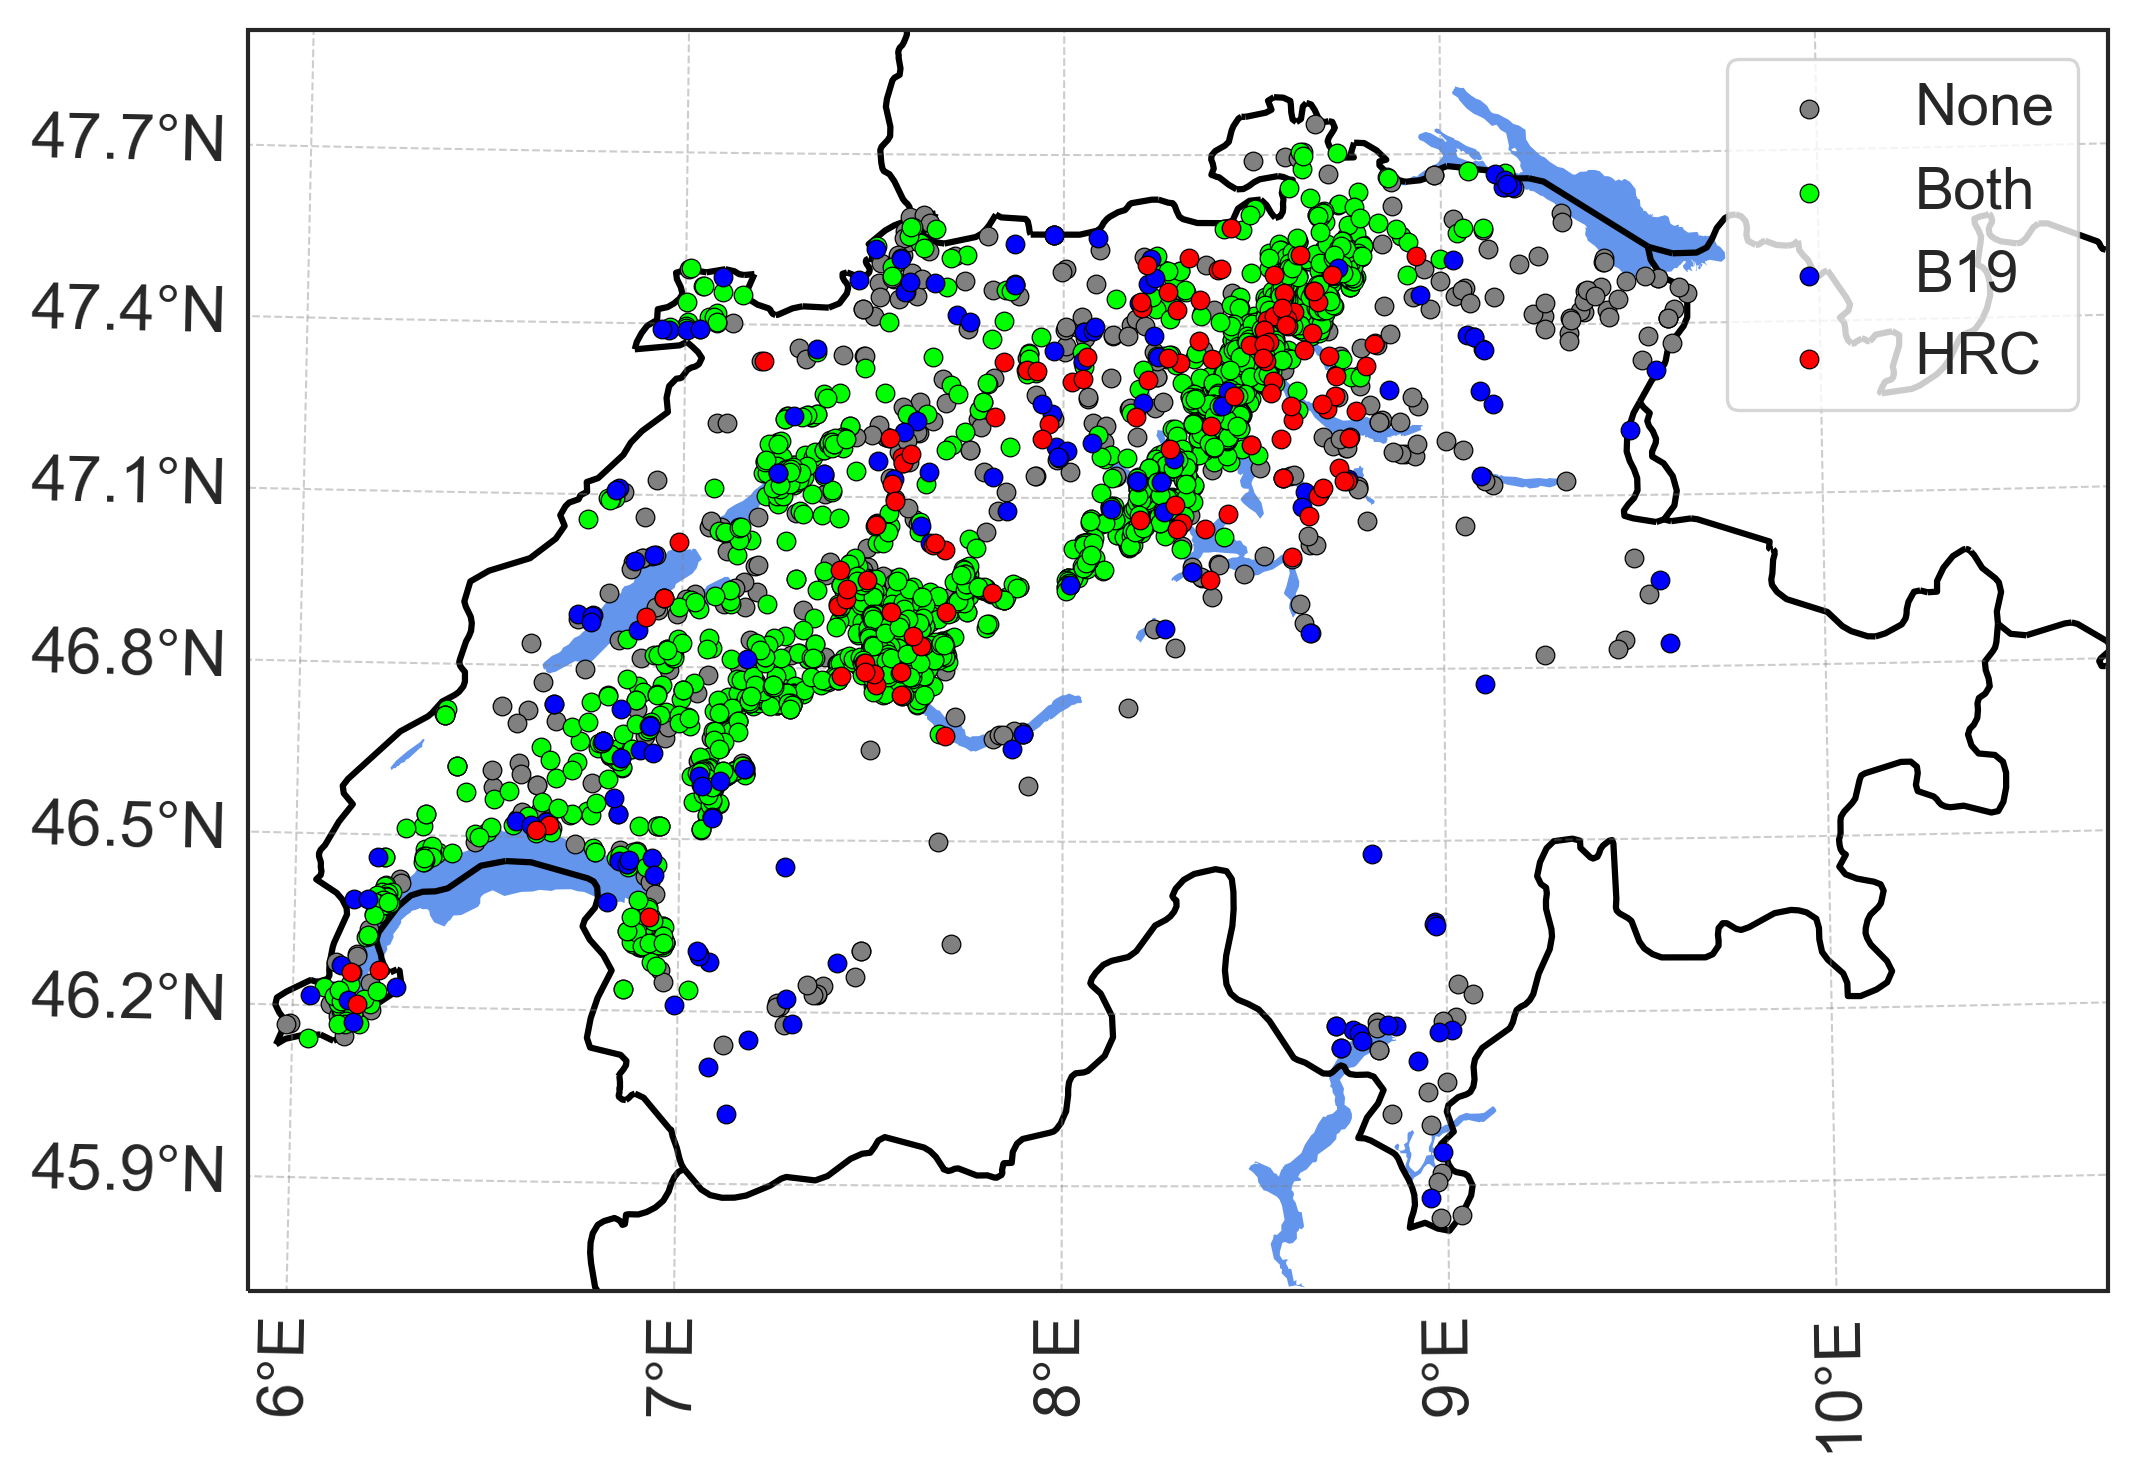

In [37]:
plot_categories(data,'cat');

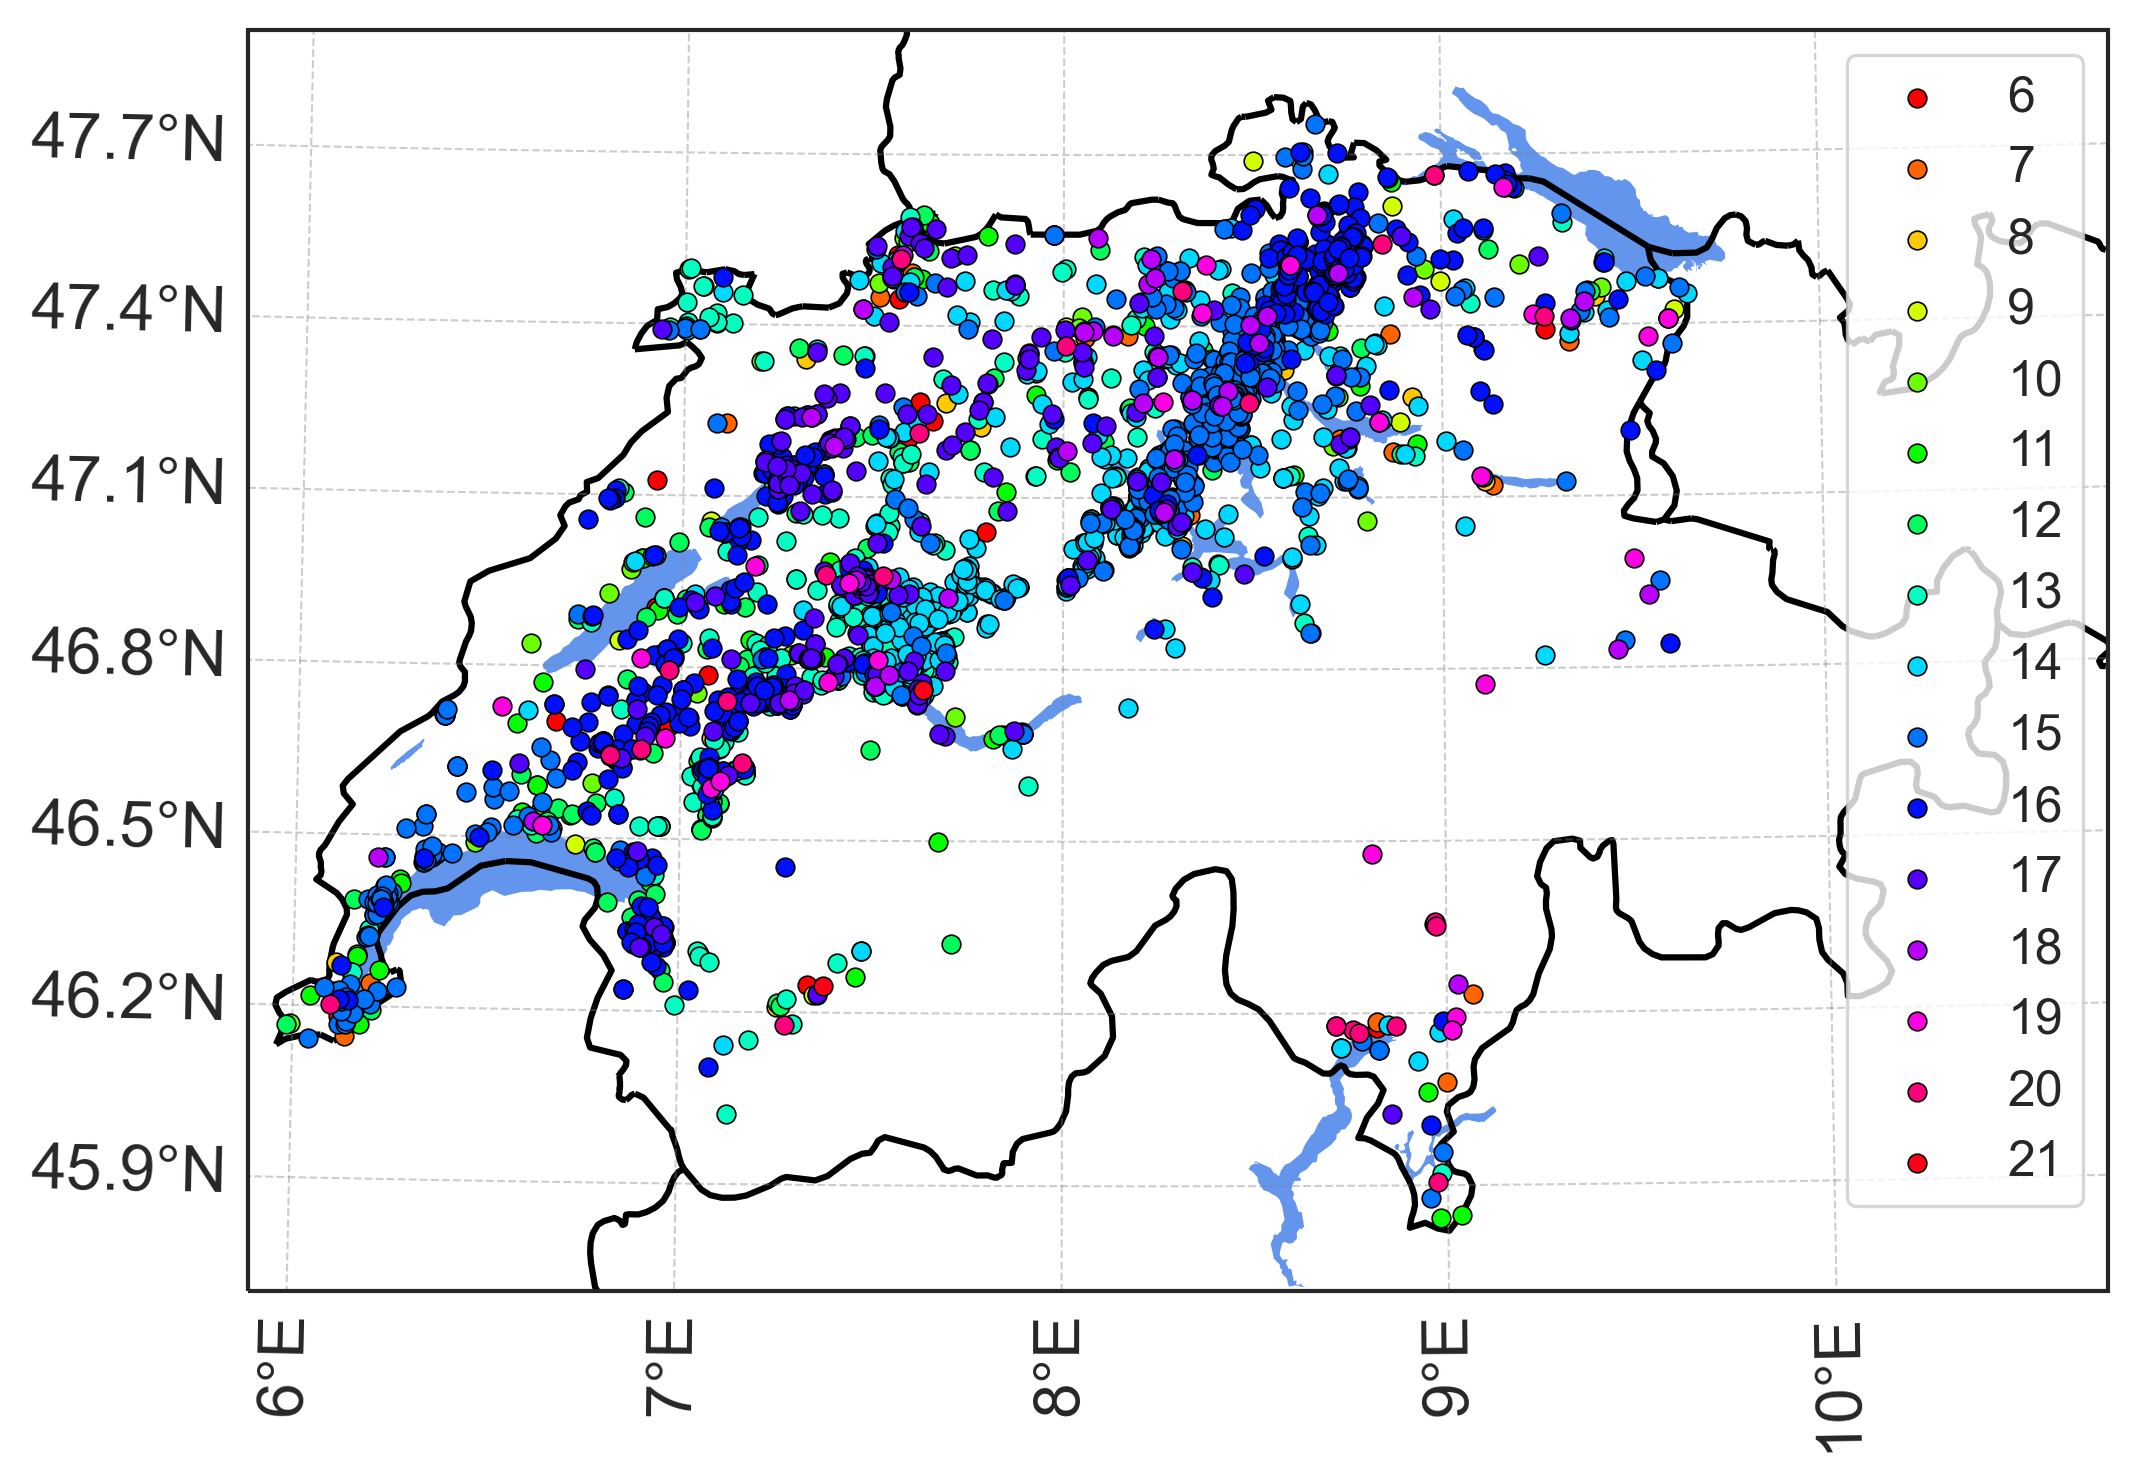

In [52]:
plot_hours(data, 'cat2');

### Functions for plotting

In [6]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [7]:
# let's load Lakes from Swisstopo
gdf_lakes = gpd.read_file("swiss-lakes-maps.json")

# cities and urban areas
import cartopy.io.shapereader as shapereader
urban = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='urban_areas')

cities = shapereader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='populated_places')
gdf_cities = gpd.read_file(cities)
swiss_cities = gdf_cities.loc[gdf_cities['NAMEASCII'].isin(['Geneva','Zurich','Lausanne',
                                      'Basel','Bern','Lugano',
                                      'Luzern','Winterthur'])]
gdf_urban = gpd.read_file(urban)

### Figure 6b

In [36]:
def plot_categories(meas_crowd, field):  
    custom_dict = {'None': 0, 'Both': 1, 'B19': 2, 'HRC': 3}
    col = ['grey','lime','blue','red']
    meas_crowd = meas_crowd.sort_values(by=[field], key=lambda x: x.map(custom_dict))
    n = meas_crowd[field].unique()
    cmap = get_cmap(len(n), name='Set1')
    cmap2 = get_cmap(2, name='Set1')

    # Spatial plot
    sns.set(style='ticks', context='paper', font_scale=1.6)
    fig = plt.figure(figsize=(8,6), dpi=300)
    prj = ccrs.AlbersEqualArea(8.222665776, 46.800663464)
    prj2 = ccrs.PlateCarree()
    ax = plt.axes(projection=prj)
    Ticino = [8.55, 9.4, 45.8, 46.3]
    Central = [7.6, 8.5, 46.5, 47.2]
    ZRH = [8.5,8.6,47.3,47.45]
    CH = [5.9, 10.7, 45.7, 47.9]

    extent = CH
    ax.set_extent(extent)
    
    for i in range(0,len(n)):
        #col = matplotlib.colors.rgb2hex(cmap(i), keep_alpha=True)
        data = meas_crowd.loc[meas_crowd[field] == n[i]]
        ax.scatter(data['Lon'],data['Lat'],
                   marker='o', zorder=4, edgecolors="black", linewidth=0.3, s=20, c=col[i], alpha=1, transform=ccrs.Geodetic(), label='%s' % n[i])

    plt.legend()

    # add lakes
    gdf_lakes.plot(ax=ax, edgecolor='none', color="cornflowerblue", transform=prj2)
    # add country border
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5)
    # add urban areas
    #gdf_urban.boundary.plot(ax=ax,transform=prj2,zorder=1.4,linewidth=1,alpha=0.4, color='black')

    gl = ax.gridlines(crs=prj2, draw_labels=True, linewidth=0.5, color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.title('')

    plt.savefig('plots/Categories_map_' + date_plot + '.png',bbox_inches = 'tight',pad_inches=0, dpi=200)
    return None

### Figure 6a

In [53]:
def plot_clusters(crowd_clust):  
    sns.set(style='ticks', context='paper', font_scale=1.6)
    #plt.figure()
    plt.figure(figsize = (8,6), dpi = 300)
    prj = ccrs.AlbersEqualArea(8.222665776, 46.800663464)
    prj2 = ccrs.PlateCarree()
    
    ax2 = plt.axes(projection=prj)
    CH = [5.9, 10.7, 45.7, 47.9]
    extent = CH
    ax2.set_extent(extent)
    labels = crowd_clust['labels'].unique()
    cmap2 = get_cmap(2, name='Set1')
        
    for count,i in enumerate(labels):
        
        if i == -1:
            #col = [0, 0, 0, 1]
            col = matplotlib.colors.rgb2hex(cmap2(1), keep_alpha=True)
            clust = crowd_clust.loc[(crowd_clust['labels']==i)]
            ax2.scatter(clust['Lon'], clust['Lat'], c=col, s=10, linewidth=0.3, zorder=4, transform=ccrs.Geodetic())
            
            #sns.scatterplot(ax=ax2, x=clust_filtered['Lon'], y=clust_filtered['Lat'], c=col, s=5, style=clust_filtered['Flag_BZC_B'], transform=ccrs.Geodetic())
        else:
            col = matplotlib.colors.rgb2hex(cmap(count), keep_alpha=True)
            clust = crowd_clust.loc[crowd_clust['labels']==i]
            ax2.scatter(clust['Lon'], clust['Lat'], c=col, s=20, edgecolors="black", linewidth=0.3, zorder=4, transform=ccrs.Geodetic())
            #ax2.scatter(clust['Lon'], clust['Lat'], c='red', s=20, edgecolors="black", linewidth=0.3, zorder=4, transform=ccrs.Geodetic())
            #sns.scatterplot(ax=ax2, x=clust['Lon'], y=clust['Lat'], c=col, s=5, style=clust['Flag_BZC_B'], transform=ccrs.Geodetic())
    
    # add lakes
    gdf_lakes.plot(ax=ax2, edgecolor='none', color="cornflowerblue", transform=prj2)
    # add country border
    ax2.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5)

    gl = ax2.gridlines(crs=prj2, draw_labels=True, linewidth=0.5, color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    plt.savefig('plots/Cluster_map_' + date_plot + '.png',bbox_inches = 'tight',pad_inches=0, dpi=200)
        
    return None

### Figure 5b

In [51]:
def plot_hours(meas_crowd, field):  

    var = 'hour'
    meas_crowd = meas_crowd.sort_values(var)
    m = meas_crowd[var].unique()
    cmap3 = get_cmap(len(m))
    
    custom_dict = {'yesCZC_yesClust': 0, 'noCZC_noClust': 1, 'yesCZC_noClust': 2, 'noCZC_yesClust': 3}
    meas_crowd = meas_crowd.sort_values(by=[field], key=lambda x: x.map(custom_dict))
    n = meas_crowd[field].unique()
    cmap = get_cmap(len(n), name='Set1')
    cmap2 = get_cmap(2, name='Set1')

    # Spatial plot
    sns.set(style='ticks', context='paper', font_scale=1.6)
    fig = plt.figure(figsize=(8,6), dpi=300)
    prj = ccrs.AlbersEqualArea(8.222665776, 46.800663464)
    prj2 = ccrs.PlateCarree()
    ax = plt.axes(projection=prj)
    Ticino = [8.55, 9.4, 45.8, 46.3]
    Central = [7.6, 8.5, 46.5, 47.2]
    ZRH = [8.5,8.6,47.3,47.45]
    CH = [5.9, 10.7, 45.7, 47.9]

    extent = CH
    ax.set_extent(extent)

    # for i in range(0,2):
    #     col = matplotlib.colors.rgb2hex(cmap2(1), keep_alpha=True)
    #     data = meas_crowd.loc[meas_crowd['cat'] == n[i]]
    #     ax.scatter(data['Lon'],data['Lat'],
    #             marker='o', zorder=4, s=10, c=col, alpha=1, transform=ccrs.Geodetic())
    for j in range(0,len(m)):
        col = matplotlib.colors.rgb2hex(cmap3(j), keep_alpha=True)
        data = meas_crowd.loc[meas_crowd[var] == m[j]]
        d1 = data
        ax.scatter(d1['Lon'],d1['Lat'], marker='o', zorder=4, s=20, linewidth=0.4, c=col, alpha=1, transform=ccrs.Geodetic(), edgecolors="black", label='%s' % m[j])
        
    # for j in range(0,len(m)):
    #     col = matplotlib.colors.rgb2hex(cmap3(j), keep_alpha=True)
    #     data = meas_crowd.loc[meas_crowd[var] == m[j]]
    #     d2 = data.loc[data[field]=='noBZC_yesClust']
    #     ax.scatter(d2['Lon'],d2['Lat'], marker='X', zorder=4, s=20, linewidth=0.4, c=col, alpha=1, transform=ccrs.Geodetic(), edgecolors="black")


    plt.legend(fontsize="12")

    # add lakes
    gdf_lakes.plot(ax=ax, edgecolor='none', color="cornflowerblue", transform=prj2)
    # add country border
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5)
    # add urban areas
    #gdf_urban.boundary.plot(ax=ax,transform=prj2,zorder=1.4,linewidth=1,alpha=0.4, color='black')

    gl = ax.gridlines(crs=prj2, draw_labels=True, linewidth=0.5, color='gray', alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.title('')

    plt.savefig('plots/hours_map_' + date_plot + '.png',bbox_inches = 'tight',pad_inches=0, dpi=200)